In [1]:
library(tidyverse)
library(ComplexHeatmap)
library(circlize)
library(maftools)
library(ggsignif)
library(RColorBrewer)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.6     ✔ dplyr   1.0.8
✔ tidyr   1.1.4     ✔ stringr 1.4.0
✔ readr   2.0.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Loading required package: grid

ComplexHeatmap version 2.10.0
Bioconductor page: http://bioconductor.org/packages/ComplexHeatmap/
Github page: https://github.com/jokergoo/ComplexHeatmap
Documentation: http://jokergoo.github.io/ComplexHeatmap-reference

If you use it in published research, please cite:
Gu, Z. Complex heatmaps reveal patterns and correlations in multidimensional 
  genomic data. Bioinformatics 2016.

The new InteractiveComplexHeatmap package can directly export static 
complex heatmaps into an interactive Shiny app with zero effort. Have a try!

This message can be suppressed by:
  suppressPa

## 0.load maf data and clinical data

### 0.1 load clin

In [2]:
library(readxl)

In [3]:
xlxs_clin = read_xlsx("../0.raw_data/sample_upload_220615_2.xlsx",sheet = 4)

Warning message in read_fun(path = enc2native(normalizePath(path)), sheet_i = sheet, :
“NA inserted for impossible 1900-02-29 datetime”
Warning message in read_fun(path = enc2native(normalizePath(path)), sheet_i = sheet, :
“NA inserted for impossible 1900-02-29 datetime”
Warning message in read_fun(path = enc2native(normalizePath(path)), sheet_i = sheet, :
“NA inserted for impossible 1900-02-29 datetime”
Warning message in read_fun(path = enc2native(normalizePath(path)), sheet_i = sheet, :
“NA inserted for impossible 1900-02-29 datetime”
Warning message in read_fun(path = enc2native(normalizePath(path)), sheet_i = sheet, :
“NA inserted for impossible 1900-02-29 datetime”
Warning message in read_fun(path = enc2native(normalizePath(path)), sheet_i = sheet, :
“NA inserted for impossible 1900-02-29 datetime”
Warning message in read_fun(path = enc2native(normalizePath(path)), sheet_i = sheet, :
“NA inserted for impossible 1900-02-29 datetime”
Warning message in read_fun(path = enc2native(no

In [4]:
xlxs_clin_noAEH = xlxs_clin %>% filter(substr(patient,4,6)!="AEH")

In [5]:
xlxs_clin_noAEH$age_group = ifelse(xlxs_clin_noAEH$age_at_diagnosis <= 40, "Early","Old")
xlxs_clin_noAEH %>% group_by(age_group) %>% summarise(n())

age_group,n()
<chr>,<int>
Early,87
Old,141
NA,22


In [6]:
xlxs_clin_noAEH_noNAage = xlxs_clin_noAEH %>% filter( age_group %in% c("Early","Old"))
xlxs_clin_noAEH_noNAage %>% group_by(age_group)%>% summarise(n())

age_group,n()
<chr>,<int>
Early,87
Old,141


In [7]:
xlxs_clin_noAEH_noNAage$Tumor_Sample_Barcode = paste0(xlxs_clin_noAEH_noNAage$patient,"_C")

In [8]:
load("../..//02.UCEC/Fig2/data/common_Clin.RDa")

### 0.2 load mut matrix 

In [9]:
total_input <- read.table("../../02.UCEC/Fig1A/mutsigmatrix.txt",sep="\t",header=T)

In [10]:
total_input[total_input==0] <- ""
mygene_new <- as.matrix(total_input)
dim(mygene_new) <- c(ncol(total_input)*nrow(total_input),1)
unique(mygene_new)

Multi_Hit
Missense_Mutation
Nonsense_Mutation
""
Splice_Site
Frame_Shift_Del
In_Frame_Del
Frame_Shift_Ins
In_Frame_Ins


In [11]:
common_sample = intersect(colnames(total_input),xlxs_clin_noAEH_noNAage$Tumor_Sample_Barcode)
length(common_sample)

[1] 215

In [12]:
common_clin_noAEH_noNAage = xlxs_clin_noAEH_noNAage %>% filter(Tumor_Sample_Barcode %in% common_sample)
common_clin_noAEH_noNAage_sort =common_clin_noAEH_noNAage %>% arrange(age_at_diagnosis)

In [13]:
common_oncopritn_input = total_input[,common_clin_noAEH_noNAage_sort$Tumor_Sample_Barcode]

## 1.Figure.2

### 1.1 Figure.2A Oncoprint

In [14]:
mycol <- colorRampPalette(brewer.pal(11,'Spectral'))(12)[12:1]
alter_fun = list(
  background = function(x, y, w, h) {
    grid.rect(x, y, w*0.9, h*0.9, gp = gpar(fill = "#dcddde", col = NA))
  },  
  Multi_Hit = function(x, y, w, h) {
    grid.rect(x, y, w*0.9, h*0.9, gp = gpar(fill = "black", col = NA)) 
  },
  Missense_Mutation = function(x, y, w, h) {
    grid.rect(x, y, w*0.9, h*0.9, gp = gpar(fill = "#219f94", col = NA)) 
  },
  Nonsense_Mutation = function(x, y, w, h) {
    grid.rect(x, y, w*0.9, h*0.9, gp = gpar(fill = "#1d6ed0", col = NA)) 
  },
  Frame_Shift_Ins = function(x, y, w, h) {
    grid.rect(x, y, w*0.9, h*0.9, gp = gpar(fill = "#2a520c", col = NA)) 
  },
  Frame_Shift_Del = function(x, y, w, h) {
    grid.rect(x, y, w*0.9, h*0.9, gp = gpar(fill = "#ff6565", col = NA)) 
  },
  In_Frame_Ins = function(x, y, w, h) {
    grid.rect(x, y, w*0.9, h*0.9, gp = gpar(fill = "#e4ed2e", col = NA)) 
  },  
  In_Frame_Del = function(x, y, w, h) {
    grid.rect(x, y, w*0.9, h*0.9, gp = gpar(fill = "#ae441f", col = NA)) 
  },
  Splice_Site = function(x, y, w, h) {
    grid.rect(x, y, w*0.9, h*0.9, gp = gpar(fill = "#d39655", col = NA)) 
  }
)

col = c("Missense_Mutation" = "#219f94", 
        "Nonsense_Mutation" = "#1d6ed0", 
        "Frame_Shift_Ins" = "#2a520c", 
        "Frame_Shift_Del" = "#ff6565", 
        "In_Frame_Ins" = "#e4ed2e", 
        "In_Frame_Del" = "#ae441f", 
        "Splice_Site" ="#d39655",
        "Multi_Hit" = "black")

In [15]:
test <- function(X){
    ifelse(X>61,"(61-74]",
           ifelse(X > 40,"(40-61]","(19-40]"))
}
common_clin_noAEH_noNAage_sort$detail_age_subtype = test(common_clin_noAEH_noNAage_sort$age_at_diagnosis)
common_clin_noAEH_noNAage_sort %>% group_by(detail_age_subtype) %>% summarise(n())

detail_age_subtype,n()
<chr>,<int>
(19-40],79
(40-61],111
(61-74],25


In [16]:
rownames(common_Clin) = common_Clin$Tumor_Sample_Barcode

In [17]:
common_tumor_t_cell = common_tumor_t_cell[ common_clin_noAEH_noNAage_sort$Tumor_Sample_Barcode,]
common_final_purity = common_final_purity[common_clin_noAEH_noNAage_sort$Tumor_Sample_Barcode,]
common_Clin = common_Clin[common_clin_noAEH_noNAage_sort$Tumor_Sample_Barcode,]
common_fga = common_fga[common_clin_noAEH_noNAage_sort$Tumor_Sample_Barcode,]

In [18]:
tjfd_pct <- read.table("../../02.UCEC/Fig1A/TJFD_use_Syn_fraction_contribution.txt",sep="\t",header=T)
tjfd_pct = tjfd_pct[,c(1:4,6,5,7)]
rownames(tjfd_pct) <- tjfd_pct[,1]
tjfd_pct <- tjfd_pct[ common_clin_noAEH_noNAage_sort$Tumor_Sample_Barcode,]
pct_input = t(apply(tjfd_pct[,-1], 1, function(x) x/sum(x)))

colnames(pct_input) <- colnames(tjfd_pct[,-1])
rownames(pct_input) <- rownames(tjfd_pct)

spectrum = HeatmapAnnotation(foo = anno_barplot(pct_input, border = F,
                                                gp = gpar(fill = c("#4276b5","#91bfdc","#e1f3f9","#fce08f","#f58d5b","#d93027"),
                                                          col= c("#4276b5","#91bfdc","#e1f3f9","#fce08f","#f58d5b","#d93027")), 
                                                bar_width = 1),
                            annotation_legend_param = list(
                                                    labels = colnames(tjfd_pct[-1]),
                                                    title  =  "Mutation Spectrum",
                                                    legnth_gp = c("#4276b5","#91bfdc","#e1f3f9","#fce08f","#f58d5b","#d93027")))
                            

In [19]:
 lgd = Legend(
            labels = colnames(tjfd_pct[-1]),
            title  =  "Mutation Spectrum",
            title_position = "leftcenter",
             direction = "horizontal",
            legend_gp = gpar(fill = c("#4276b5","#91bfdc","#e1f3f9","#fce08f","#f58d5b","#d93027")),
             nrow =1 )

In [20]:
common_clin_noAEH_noNAage_sort$Obesity = ifelse(common_clin_noAEH_noNAage_sort$BMI >= 28,"Obesity","Normal")

In [59]:
pdf("Figure.1/Figure.1A.maf_oncoprint_age.pdf",width=10,height=12)
# 绘图
m1 <- oncoPrint(common_oncopritn_input[1:30,], get_type = function(x) x,
           alter_fun = alter_fun, col = col,
          show_pct = T, #show pct in left
          column_title = "",
          #bottom_annotation = my_annotation,
          show_heatmap_legend=T,
          column_title_gp = gpar(fontsize = 8),
          row_names_gp = gpar(fontsize = 7),
          row_names_side = "left",
          pct_side = "right",
          column_names_gp = gpar(fontsize = 6),
           column_split = factor(common_clin_noAEH_noNAage_sort$age_group,levels=c("Early","Old")),
          column_order = order(common_clin_noAEH_noNAage_sort$age_at_diagnosis),
          alter_fun_is_vectorized = FALSE,
          heatmap_legend_param = list(direction = "horizontal",nrow=2, title = ""),
          #column_order= rownames(common_clin_noAEH_noNAage_sort)[order(common_clin_noAEH_noNAage_sort$age_at_diagnosis,decreasing=T)],,
           top_annotation = HeatmapAnnotation(Nonsyn_Count = anno_barplot(common_Clin$Nonsynonymous_Count,border = F,gp = gpar(fill = "#1a78b4",col="#1a78b4"),annotation_name="Nonsyn Mutations",bar_width = 0.7,height = unit(2.5, "cm")),
                                             TCGA_Subtype=common_clin_noAEH_noNAage_sort$Subtype,
                                              Figo=common_Clin$stage_subtype, 
                                             Grade = common_Clin$clinical_grade,
                                             Age = common_clin_noAEH_noNAage_sort$detail_age_subtype,
                                              Obesity = common_clin_noAEH_noNAage_sort$Obesity,
                                              BMI = common_clin_noAEH_noNAage_sort$BMI,
                                             TP53 = common_Clin$TP53_status, 
                                            T_cell_frac = common_tumor_t_cell$TCRA.tcell.fraction,
                                              consensus_normal_purity = common_final_purity$median_normalize_purity, 
                                              Purbayes =common_final_purity$PurBayes,
                                              histology = common_final_purity$histology,
                                              fga = common_fga$FGA,
                                              gain = common_fga$GAIN,
                                              loss = common_fga$LOSS,
                                              wgd = common_fga$IS_WGD,
                                              annotation_label = c("Nonsyn Mutations","TCGA Subtype","Figo Stage","Figo Grade","Age","Obesity","BMI","TP53 Status", "T cell fraction",
                                                                   "Consensus Purity","Purbayes Purity","histology purity","FGA","Gain","Loss","WGD"),
                                             col = list(TCGA_Subtype = c("CN high" = "#d82249","CN low" = "#e5e3c9","MSI_hypermutated" = "#9adcff" , "POLE_ultramutated" = "#925e9f"),
                                                        Grade = c("G1"="#4fd3c4","G2"="#70b2d2","G3"="#d82148"),
                                                        Figo = c("AEH" = "#0072b5","IA" = "#7876b1","IB-II" = "#ffdc91","III-IV" = "#ee4c97"),
                                                        Age = c("(19-40]" = "#b0e2fe","(40-61]" = "#33cd2e","(61-74]" = "#1c8c1c"),
                                                       wgd = c("FALSE"="#bebebe","TRUE"="#ffdc91")),
                                            show_annotation_name = TRUE,
                                            annotation_name_side = "left",
                                            annotation_name_gp = gpar(fontsize = 8)),
         bottom_annotation = HeatmapAnnotation(Spectrum = anno_barplot(pct_input, border = F,
                                                axis_param = list(at = c(0,0.2, 0.4, 0.6, 0.8,1.0), labels =c(0,0.2, 0.4, 0.6, 0.8,1.0)),
                                                gp = gpar(fill = c("#4276b5","#91bfdc","#e1f3f9","#fce08f","#f58d5b","#d93027"),
                                                          col= c("#4276b5","#91bfdc","#e1f3f9","#fce08f","#f58d5b","#d93027")), 
                                                bar_width = 1,height = unit(2.5, "cm")),
                                               show_annotation_name = FALSE),
          right_annotation = rowAnnotation(rbar = anno_oncoprint_barplot(show_fraction = T)))
draw(m1,merge_legends = FALSE,heatmap_legend_side = "bottom", heatmap_legend_list = list(lgd))
dev.off()

All mutation types: Multi_Hit, Missense_Mutation, Nonsense_Mutation,
Splice_Site, In_Frame_Del, Frame_Shift_Del, Frame_Shift_Ins,
In_Frame_Ins.

Warning message:
“You defined `cell_fun` for a heatmap with more than 100 rows or
columns, which might be very slow to draw. Consider to use the
vectorized version `layer_fun`.”


png 
  2

In [65]:
pdf("Figure.1/Figure.1A.maf_oncoprint_age_cluster.pdf",width=10,height=12)
# 绘图
#col_hclust = hclust(dist(common_oncopritn_input[1:30,]))
m1 <- oncoPrint(common_oncopritn_input[1:30,], get_type = function(x) x,
           alter_fun = alter_fun, col = col,
          show_pct = T, #show pct in left
          column_title = "",
          #bottom_annotation = my_annotation,
          show_heatmap_legend=T,
          column_title_gp = gpar(fontsize = 8),
          row_names_gp = gpar(fontsize = 7),
          row_names_side = "left",
          #cluster_columns = col_hclust,
          #row_km = 4,
          pct_side = "right",
          column_names_gp = gpar(fontsize = 6),
           column_split = factor(common_clin_noAEH_noNAage_sort$age_group,levels=c("Early","Old")),
          #column_order = order(common_clin_noAEH_noNAage_sort$age_at_diagnosis),
          alter_fun_is_vectorized = FALSE,
          heatmap_legend_param = list(direction = "horizontal",nrow=2, title = ""),
          #column_order= rownames(common_clin_noAEH_noNAage_sort)[order(common_clin_noAEH_noNAage_sort$age_at_diagnosis,decreasing=T)],,
           top_annotation = HeatmapAnnotation(Nonsyn_Count = anno_barplot(common_Clin$Nonsynonymous_Count,border = F,gp = gpar(fill = "#1a78b4",col="#1a78b4"),annotation_name="Nonsyn Mutations",bar_width = 0.7,height = unit(2.5, "cm")),
                                             TCGA_Subtype=common_clin_noAEH_noNAage_sort$Subtype,
                                              Figo=common_Clin$stage_subtype, 
                                             Grade = common_Clin$clinical_grade,
                                              Age_detail =  common_clin_noAEH_noNAage_sort$age_at_diagnosis,
                                             Age = common_clin_noAEH_noNAage_sort$detail_age_subtype,
                                              Obesity = common_clin_noAEH_noNAage_sort$Obesity,
                                              BMI = common_clin_noAEH_noNAage_sort$BMI,
                                             TP53 = common_Clin$TP53_status, 
                                            T_cell_frac = common_tumor_t_cell$TCRA.tcell.fraction,
                                              consensus_normal_purity = common_final_purity$median_normalize_purity, 
                                              Purbayes =common_final_purity$PurBayes,
                                              histology = common_final_purity$histology,
                                              fga = common_fga$FGA,
                                              gain = common_fga$GAIN,
                                              loss = common_fga$LOSS,
                                              wgd = common_fga$IS_WGD,
                                              annotation_label = c("Nonsyn Mutations","TCGA Subtype","Figo Stage","Figo Grade","Age","Age Subtype","Obesity","BMI","TP53 Status", "T cell fraction",
                                                                   "Consensus Purity","Purbayes Purity","histology purity","FGA","Gain","Loss","WGD"),
                                             col = list(TCGA_Subtype = c("CN high" = "#d82249","CN low" = "#e5e3c9","MSI_hypermutated" = "#9adcff" , "POLE_ultramutated" = "#925e9f"),
                                                        Grade = c("G1"="#4fd3c4","G2"="#70b2d2","G3"="#d82148"),
                                                        Figo = c("AEH" = "#0072b5","IA" = "#7876b1","IB-II" = "#ffdc91","III-IV" = "#ee4c97"),
                                                        Age = c("(19-40]" = "#b0e2fe","(40-61]" = "#33cd2e","(61-74]" = "#1c8c1c"),
                                                       wgd = c("FALSE"="#bebebe","TRUE"="#ffdc91")),
                                            show_annotation_name = TRUE,
                                            annotation_name_side = "left",
                                            annotation_name_gp = gpar(fontsize = 8)),
         bottom_annotation = HeatmapAnnotation(Spectrum = anno_barplot(pct_input, border = F,
                                                axis_param = list(at = c(0,0.2, 0.4, 0.6, 0.8,1.0), labels =c(0,0.2, 0.4, 0.6, 0.8,1.0)),
                                                gp = gpar(fill = c("#4276b5","#91bfdc","#e1f3f9","#fce08f","#f58d5b","#d93027"),
                                                          col= c("#4276b5","#91bfdc","#e1f3f9","#fce08f","#f58d5b","#d93027")), 
                                                bar_width = 1,height = unit(2.5, "cm")),
                                               show_annotation_name = FALSE),
          right_annotation = rowAnnotation(rbar = anno_oncoprint_barplot(show_fraction = T)))
draw(m1,merge_legends = FALSE,heatmap_legend_side = "bottom", heatmap_legend_list = list(lgd))
dev.off()

All mutation types: Multi_Hit, Missense_Mutation, Nonsense_Mutation,
Splice_Site, In_Frame_Del, Frame_Shift_Del, Frame_Shift_Ins,
In_Frame_Ins.

Warning message:
“You defined `cell_fun` for a heatmap with more than 100 rows or
columns, which might be very slow to draw. Consider to use the
vectorized version `layer_fun`.”


png 
  2

In [67]:
pdf("Figure.1/Figure.1A.maf_oncoprint_obesity.pdf",width=10,height=12)
# 绘图
#col_hclust = hclust(dist(common_oncopritn_input[1:30,]))
m1 <- oncoPrint(common_oncopritn_input[1:30,], get_type = function(x) x,
           alter_fun = alter_fun, col = col,
          show_pct = T, #show pct in left
          column_title = "",
          #bottom_annotation = my_annotation,
          show_heatmap_legend=T,
          column_title_gp = gpar(fontsize = 8),
          row_names_gp = gpar(fontsize = 7),
          row_names_side = "left",
          #cluster_columns = col_hclust,
          #row_km = 4,
          pct_side = "right",
          column_names_gp = gpar(fontsize = 6),
           column_split = factor(common_clin_noAEH_noNAage_sort$Obesity,levels=c("Obesity","Normal")),
          #column_order = order(common_clin_noAEH_noNAage_sort$age_at_diagnosis),
          alter_fun_is_vectorized = FALSE,
          heatmap_legend_param = list(direction = "horizontal",nrow=2, title = ""),
          #column_order= rownames(common_clin_noAEH_noNAage_sort)[order(common_clin_noAEH_noNAage_sort$age_at_diagnosis,decreasing=T)],,
           top_annotation = HeatmapAnnotation(Nonsyn_Count = anno_barplot(common_Clin$Nonsynonymous_Count,border = F,gp = gpar(fill = "#1a78b4",col="#1a78b4"),annotation_name="Nonsyn Mutations",bar_width = 0.7,height = unit(2.5, "cm")),
                                             TCGA_Subtype=common_clin_noAEH_noNAage_sort$Subtype,
                                              Figo=common_Clin$stage_subtype, 
                                             Grade = common_Clin$clinical_grade,
                                              Age_detail =  common_clin_noAEH_noNAage_sort$age_at_diagnosis,
                                             Age = common_clin_noAEH_noNAage_sort$detail_age_subtype,
                                              Obesity = common_clin_noAEH_noNAage_sort$Obesity,
                                              BMI = common_clin_noAEH_noNAage_sort$BMI,
                                             TP53 = common_Clin$TP53_status, 
                                            T_cell_frac = common_tumor_t_cell$TCRA.tcell.fraction,
                                              consensus_normal_purity = common_final_purity$median_normalize_purity, 
                                              Purbayes =common_final_purity$PurBayes,
                                              histology = common_final_purity$histology,
                                              fga = common_fga$FGA,
                                              gain = common_fga$GAIN,
                                              loss = common_fga$LOSS,
                                              wgd = common_fga$IS_WGD,
                                              annotation_label = c("Nonsyn Mutations","TCGA Subtype","Figo Stage","Figo Grade","Age","Age Subtype","Obesity","BMI","TP53 Status", "T cell fraction",
                                                                   "Consensus Purity","Purbayes Purity","histology purity","FGA","Gain","Loss","WGD"),
                                             col = list(TCGA_Subtype = c("CN high" = "#d82249","CN low" = "#e5e3c9","MSI_hypermutated" = "#9adcff" , "POLE_ultramutated" = "#925e9f"),
                                                        Grade = c("G1"="#4fd3c4","G2"="#70b2d2","G3"="#d82148"),
                                                        Figo = c("AEH" = "#0072b5","IA" = "#7876b1","IB-II" = "#ffdc91","III-IV" = "#ee4c97"),
                                                        Age = c("(19-40]" = "#b0e2fe","(40-61]" = "#33cd2e","(61-74]" = "#1c8c1c"),
                                                       wgd = c("FALSE"="#bebebe","TRUE"="#ffdc91")),
                                            show_annotation_name = TRUE,
                                            annotation_name_side = "left",
                                            annotation_name_gp = gpar(fontsize = 8)),
         bottom_annotation = HeatmapAnnotation(Spectrum = anno_barplot(pct_input, border = F,
                                                axis_param = list(at = c(0,0.2, 0.4, 0.6, 0.8,1.0), labels =c(0,0.2, 0.4, 0.6, 0.8,1.0)),
                                                gp = gpar(fill = c("#4276b5","#91bfdc","#e1f3f9","#fce08f","#f58d5b","#d93027"),
                                                          col= c("#4276b5","#91bfdc","#e1f3f9","#fce08f","#f58d5b","#d93027")), 
                                                bar_width = 1,height = unit(2.5, "cm")),
                                               show_annotation_name = FALSE),
          right_annotation = rowAnnotation(rbar = anno_oncoprint_barplot(show_fraction = T)))
draw(m1,merge_legends = FALSE,heatmap_legend_side = "bottom", heatmap_legend_list = list(lgd))
dev.off()

All mutation types: Multi_Hit, Missense_Mutation, Nonsense_Mutation,
Splice_Site, In_Frame_Del, Frame_Shift_Del, Frame_Shift_Ins,
In_Frame_Ins.

Warning message:
“You defined `cell_fun` for a heatmap with more than 100 rows or
columns, which might be very slow to draw. Consider to use the
vectorized version `layer_fun`.”


png 
  2

### 1.2 Figure.2B/C lollipopplot(CTNNB1)

In [68]:
total_maf = read_tsv("../../../DNAseq/UCEC_un_annovar/10_maf_merge/merge.total.unannovar.maf")

Rows: 522813 Columns: 114
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (56): Hugo_Symbol, Center, NCBI_Build, Chromosome, Strand, Variant_Class...
dbl (34): Entrez_Gene_Id, Start_Position, End_Position, t_depth, t_ref_count...
lgl (23): dbSNP_Val_Status, Tumor_Validation_Allele1, Tumor_Validation_Allel...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [70]:
common_clin_noAEH_noNAage_sort_early = common_clin_noAEH_noNAage_sort %>% filter(age_group == "Early")
common_clin_noAEH_noNAage_sort_old = common_clin_noAEH_noNAage_sort %>% filter(age_group == "Old")
common_early_maf = total_maf %>% filter(Tumor_Sample_Barcode %in% common_clin_noAEH_noNAage_sort_early$Tumor_Sample_Barcode)
common_early_laml = read.maf(common_early_maf,clinicalData = common_clin_noAEH_noNAage_sort_early)
common_old_maf = total_maf %>% filter(Tumor_Sample_Barcode %in% common_clin_noAEH_noNAage_sort_old$Tumor_Sample_Barcode)
common_old_laml = read.maf(common_old_maf,clinicalData = common_clin_noAEH_noNAage_sort_old)

-Validating
-Silent variants: 62767 
-Summarizing
--Possible FLAGS among top ten genes:
  TTN
  OBSCN
  MUC16
  AHNAK2
-Processing clinical data
-Finished in 6.417s elapsed (55.9s cpu) 
-Validating
-Silent variants: 211580 
-Summarizing
--Possible FLAGS among top ten genes:
  TTN
  MUC16
  OBSCN
  SYNE2
-Processing clinical data
-Finished in 22.7s elapsed (00:03:03 cpu) 


In [69]:
common_maf = total_maf %>% filter(Tumor_Sample_Barcode %in% common_clin_noAEH_noNAage_sort$Tumor_Sample_Barcode)
common_age_laml = read.maf(common_maf,clinicalData = common_clin_noAEH_noNAage_sort)

-Validating
-Silent variants: 274347 
-Summarizing
--Possible FLAGS among top ten genes:
  TTN
  MUC16
  OBSCN
  SYNE1
-Processing clinical data
-Finished in 33.5s elapsed (00:03:57 cpu) 


In [4]:
library(maftools)

Assuming protein change information are stored under column HGVSp_Short. Use argument AACol to override if necessary.

3 transcripts available. Use arguments refSeqID or proteinID to manually specify tx name.



     HGNC    refseq.ID   protein.ID aa.length
1: CTNNB1 NM_001098209 NP_001091679       781
2: CTNNB1 NM_001098210 NP_001091680       781
3: CTNNB1    NM_001904    NP_001895       781


Using longer transcript NM_001098209 for now.



    pos       conv count Variant_Classification
 1:  25 W25_H36del     1           In_Frame_Del
 2:  32       D32Y     4      Missense_Mutation
 3:  32       D32V     1      Missense_Mutation
 4:  32       D32A     2      Missense_Mutation
 5:  32       D32G     1      Missense_Mutation
 6:  33       S33A     2      Missense_Mutation
 7:  33       S33C     4      Missense_Mutation
 8:  33       S33Y     1      Missense_Mutation
 9:  34 G34_I35del     1           In_Frame_Del
10:  34       G34V     4      Missense_Mutation
11:  34       G34R     3      Missense_Mutation
12:  34       G34E     1      Missense_Mutation
13:  35 I35_G38del     1           In_Frame_Del
14:  37       S37F     8      Missense_Mutation
15:  37       S37C     5      Missense_Mutation
16:  41       T41I     2      Missense_Mutation
17:  96       A96T     1      Missense_Mutation
18: 292      K292T     1      Missense_Mutation
19: 538      Q538K     1      Missense_Mutation


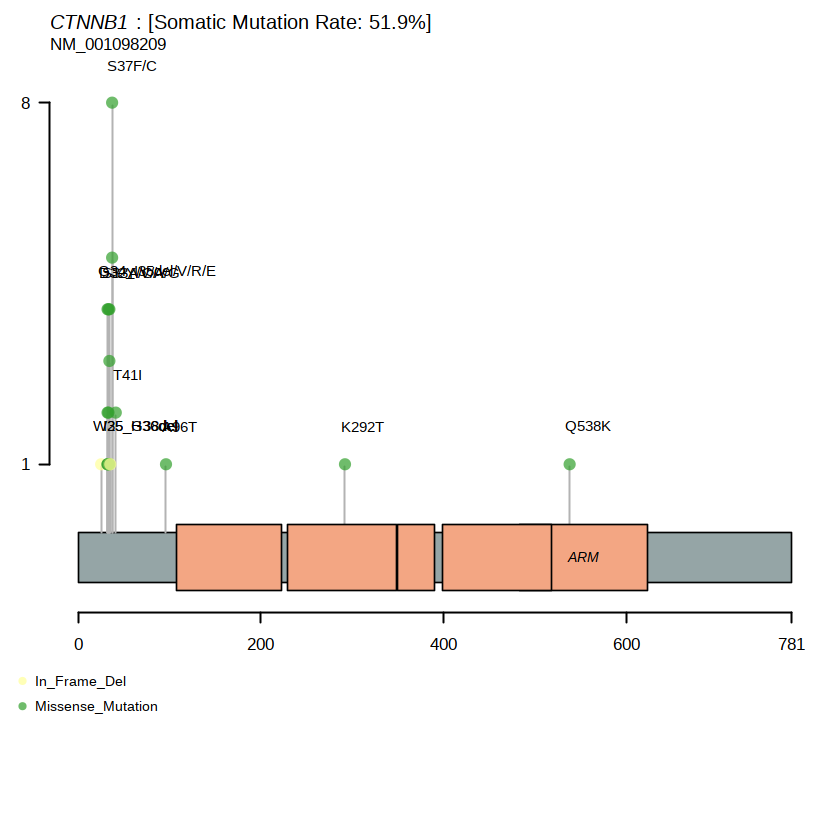

In [5]:
lollipopPlot(common_early_laml,gene="CTNNB1",labelPos = "all",printCount = T)


Assuming protein change information are stored under column HGVSp_Short. Use argument AACol to override if necessary.

3 transcripts available. Use arguments refSeqID or proteinID to manually specify tx name.



     HGNC    refseq.ID   protein.ID aa.length
1: CTNNB1 NM_001098209 NP_001091679       781
2: CTNNB1 NM_001098210 NP_001091680       781
3: CTNNB1    NM_001904    NP_001895       781


Using longer transcript NM_001098209 for now.



    pos  conv count Variant_Classification
 1:  32  D32N     1      Missense_Mutation
 2:  32  D32Y     3      Missense_Mutation
 3:  33  S33Y     1      Missense_Mutation
 4:  33  S33C     1      Missense_Mutation
 5:  33  S33F     1      Missense_Mutation
 6:  34  G34E     1      Missense_Mutation
 7:  34  G34V     2      Missense_Mutation
 8:  37  S37A     1      Missense_Mutation
 9:  37  S37C     1      Missense_Mutation
10:  45  S45F     2      Missense_Mutation
11:  67  E67A     1      Missense_Mutation
12: 131 M131L     1      Missense_Mutation
13: 161 N161H     1      Missense_Mutation
14: 187 A187T     1      Missense_Mutation
15: 200 R200C     1      Missense_Mutation
16: 293 F293L     1      Missense_Mutation
17: 383 W383L     1      Missense_Mutation
18: 710 R710H     1      Missense_Mutation


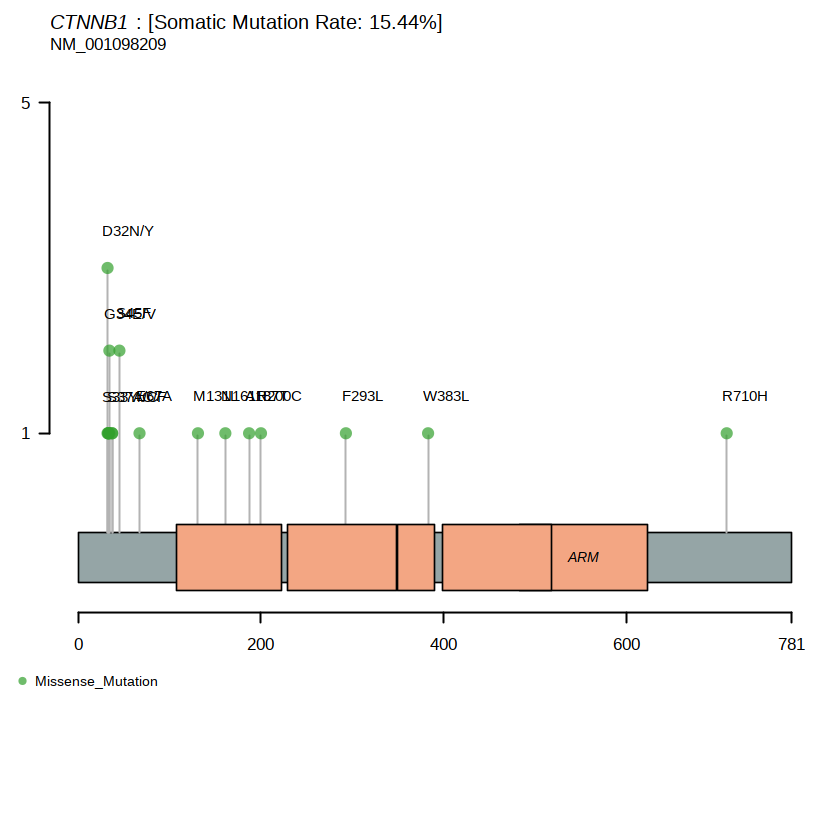

In [6]:
lollipopPlot(common_old_laml,gene="CTNNB1",labelPos = "all",printCount = T)


In [72]:
for (i in 1: nrow(common_oncopritn_input)){
    gene_name = rownames(common_oncopritn_input)[i]
    pdf(paste0("Figure.1/lollipop/",gene_name,"_with_label.pdf"))
    lollipopPlot2(common_early_laml,common_old_laml,gene =gene_name,
              AACol1 = "HGVSp_Short",AACol2="HGVSp_Short",m1_name="Early_total",m2_name="Old_total",
             m1_label = "all",m2_label="all")
    dev.off()
    }

Gene: PTEN

Gene: ARID1A

2 transcripts available. Use arguments refSeqID or proteinID to manually specify tx name.



     HGNC refseq.ID protein.ID aa.length
1: ARID1A NM_006015  NP_006006      2285
2: ARID1A NM_139135  NP_624361      2068


Using longer transcript NM_006015 for now.

2 transcripts available. Use arguments refSeqID or proteinID to manually specify tx name.



     HGNC refseq.ID protein.ID aa.length
1: ARID1A NM_006015  NP_006006      2285
2: ARID1A NM_139135  NP_624361      2068


Using longer transcript NM_006015 for now.

Gene: PIK3CA

Gene: CTNNB1

3 transcripts available. Use arguments refSeqID or proteinID to manually specify tx name.



     HGNC    refseq.ID   protein.ID aa.length
1: CTNNB1 NM_001098209 NP_001091679       781
2: CTNNB1 NM_001098210 NP_001091680       781
3: CTNNB1    NM_001904    NP_001895       781


Using longer transcript NM_001098209 for now.

3 transcripts available. Use arguments refSeqID or proteinID to manually specify tx name.



     HGNC    refseq.ID   protein.ID aa.length
1: CTNNB1 NM_001098209 NP_001091679       781
2: CTNNB1 NM_001098210 NP_001091680       781
3: CTNNB1    NM_001904    NP_001895       781


Using longer transcript NM_001098209 for now.

Gene: PIK3R1

4 transcripts available. Use arguments refSeqID or proteinID to manually specify tx name.



     HGNC    refseq.ID   protein.ID aa.length
1: PIK3R1 NM_001242466 NP_001229395       361
2: PIK3R1    NM_181504    NP_852556       454
3: PIK3R1    NM_181523    NP_852664       724
4: PIK3R1    NM_181524    NP_852665       424


Using longer transcript NM_181523 for now.

4 transcripts available. Use arguments refSeqID or proteinID to manually specify tx name.



     HGNC    refseq.ID   protein.ID aa.length
1: PIK3R1 NM_001242466 NP_001229395       361
2: PIK3R1    NM_181504    NP_852556       454
3: PIK3R1    NM_181523    NP_852664       724
4: PIK3R1    NM_181524    NP_852665       424


Using longer transcript NM_181523 for now.

Gene: MUC4

3 transcripts available. Use arguments refSeqID or proteinID to manually specify tx name.



   HGNC refseq.ID protein.ID aa.length
1: MUC4 NM_004532  NP_004523      1176
2: MUC4 NM_018406  NP_060876      5412
3: MUC4 NM_138297  NP_612154      1125


Using longer transcript NM_018406 for now.

3 transcripts available. Use arguments refSeqID or proteinID to manually specify tx name.



   HGNC refseq.ID protein.ID aa.length
1: MUC4 NM_004532  NP_004523      1176
2: MUC4 NM_018406  NP_060876      5412
3: MUC4 NM_138297  NP_612154      1125


Using longer transcript NM_018406 for now.

Gene: CTCF

2 transcripts available. Use arguments refSeqID or proteinID to manually specify tx name.



   HGNC    refseq.ID   protein.ID aa.length
1: CTCF NM_001191022 NP_001177951       399
2: CTCF    NM_006565    NP_006556       727


Using longer transcript NM_006565 for now.

2 transcripts available. Use arguments refSeqID or proteinID to manually specify tx name.



   HGNC    refseq.ID   protein.ID aa.length
1: CTCF NM_001191022 NP_001177951       399
2: CTCF    NM_006565    NP_006556       727


Using longer transcript NM_006565 for now.

Gene: KRAS

2 transcripts available. Use arguments refSeqID or proteinID to manually specify tx name.



   HGNC refseq.ID protein.ID aa.length
1: KRAS NM_004985  NP_004976       188
2: KRAS NM_033360  NP_203524       189


Using longer transcript NM_033360 for now.

2 transcripts available. Use arguments refSeqID or proteinID to manually specify tx name.



   HGNC refseq.ID protein.ID aa.length
1: KRAS NM_004985  NP_004976       188
2: KRAS NM_033360  NP_203524       189


Using longer transcript NM_033360 for now.

Gene: CHD4

Gene: ATM

Gene: ASCC3

Gene: SYTL2

9 transcripts available. Use arguments refSeqID or proteinID to manually specify tx name.



    HGNC    refseq.ID   protein.ID aa.length
1: SYTL2 NM_001162951 NP_001156423       934
2: SYTL2 NM_001162952 NP_001156424       336
3: SYTL2 NM_001162953 NP_001156425       935
4: SYTL2    NM_032379    NP_115755       376
5: SYTL2    NM_032943    NP_116561       910
6: SYTL2    NM_206927    NP_996810      1272
7: SYTL2    NM_206928    NP_996811      1256
8: SYTL2    NM_206929    NP_996812       376
9: SYTL2    NM_206930    NP_996813       365


Using longer transcript NM_206927 for now.

9 transcripts available. Use arguments refSeqID or proteinID to manually specify tx name.



    HGNC    refseq.ID   protein.ID aa.length
1: SYTL2 NM_001162951 NP_001156423       934
2: SYTL2 NM_001162952 NP_001156424       336
3: SYTL2 NM_001162953 NP_001156425       935
4: SYTL2    NM_032379    NP_115755       376
5: SYTL2    NM_032943    NP_116561       910
6: SYTL2    NM_206927    NP_996810      1272
7: SYTL2    NM_206928    NP_996811      1256
8: SYTL2    NM_206929    NP_996812       376
9: SYTL2    NM_206930    NP_996813       365


Using longer transcript NM_206927 for now.

Gene: INPPL1

Gene: JAK1

Gene: PDE4DIP

9 transcripts available. Use arguments refSeqID or proteinID to manually specify tx name.



      HGNC    refseq.ID   protein.ID aa.length
1: PDE4DIP NM_001002810 NP_001002810       173
2: PDE4DIP NM_001002811 NP_001002811      1132
3: PDE4DIP NM_001002812 NP_001002812       969
4: PDE4DIP NM_001195260 NP_001182189       141
5: PDE4DIP NM_001195261 NP_001182190       176
6: PDE4DIP NM_001198832 NP_001185761      2240
7: PDE4DIP NM_001198834 NP_001185763      2362
8: PDE4DIP    NM_014644    NP_055459      2346
9: PDE4DIP    NM_022359    NP_071754       310


Using longer transcript NM_001198834 for now.

9 transcripts available. Use arguments refSeqID or proteinID to manually specify tx name.



      HGNC    refseq.ID   protein.ID aa.length
1: PDE4DIP NM_001002810 NP_001002810       173
2: PDE4DIP NM_001002811 NP_001002811      1132
3: PDE4DIP NM_001002812 NP_001002812       969
4: PDE4DIP NM_001195260 NP_001182189       141
5: PDE4DIP NM_001195261 NP_001182190       176
6: PDE4DIP NM_001198832 NP_001185761      2240
7: PDE4DIP NM_001198834 NP_001185763      2362
8: PDE4DIP    NM_014644    NP_055459      2346
9: PDE4DIP    NM_022359    NP_071754       310


Using longer transcript NM_001198834 for now.

Gene: CDC27

2 transcripts available. Use arguments refSeqID or proteinID to manually specify tx name.



    HGNC    refseq.ID   protein.ID aa.length
1: CDC27 NM_001114091 NP_001107563       830
2: CDC27    NM_001256    NP_001247       824


Using longer transcript NM_001114091 for now.

2 transcripts available. Use arguments refSeqID or proteinID to manually specify tx name.



    HGNC    refseq.ID   protein.ID aa.length
1: CDC27 NM_001114091 NP_001107563       830
2: CDC27    NM_001256    NP_001247       824


Using longer transcript NM_001114091 for now.

Gene: RASA1

2 transcripts available. Use arguments refSeqID or proteinID to manually specify tx name.



    HGNC refseq.ID protein.ID aa.length
1: RASA1 NM_002890  NP_002881      1047
2: RASA1 NM_022650  NP_072179       870


Using longer transcript NM_002890 for now.

2 transcripts available. Use arguments refSeqID or proteinID to manually specify tx name.



    HGNC refseq.ID protein.ID aa.length
1: RASA1 NM_002890  NP_002881      1047
2: RASA1 NM_022650  NP_072179       870


Using longer transcript NM_002890 for now.

Gene: MBD6

Gene: LILRA1

Gene: TTK

2 transcripts available. Use arguments refSeqID or proteinID to manually specify tx name.



   HGNC    refseq.ID   protein.ID aa.length
1:  TTK NM_001166691 NP_001160163       856
2:  TTK    NM_003318    NP_003309       857


Using longer transcript NM_003318 for now.

2 transcripts available. Use arguments refSeqID or proteinID to manually specify tx name.



   HGNC    refseq.ID   protein.ID aa.length
1:  TTK NM_001166691 NP_001160163       856
2:  TTK    NM_003318    NP_003309       857


Using longer transcript NM_003318 for now.

Gene: TDRD5

5 transcripts available. Use arguments refSeqID or proteinID to manually specify tx name.



    HGNC    refseq.ID   protein.ID aa.length
1: TDRD5 NM_001199085 NP_001186014      1035
2: TDRD5 NM_001199089 NP_001186018      1035
3: TDRD5 NM_001199091 NP_001186020       981
4: TDRD5 NM_001199092 NP_001186021       536
5: TDRD5    NM_173533    NP_775804       981


Using longer transcript NM_001199085 for now.

5 transcripts available. Use arguments refSeqID or proteinID to manually specify tx name.



    HGNC    refseq.ID   protein.ID aa.length
1: TDRD5 NM_001199085 NP_001186014      1035
2: TDRD5 NM_001199089 NP_001186018      1035
3: TDRD5 NM_001199091 NP_001186020       981
4: TDRD5 NM_001199092 NP_001186021       536
5: TDRD5    NM_173533    NP_775804       981


Using longer transcript NM_001199085 for now.

Gene: FOXA2

2 transcripts available. Use arguments refSeqID or proteinID to manually specify tx name.



    HGNC refseq.ID protein.ID aa.length
1: FOXA2 NM_021784  NP_068556       463
2: FOXA2 NM_153675  NP_710141       457


Using longer transcript NM_021784 for now.

2 transcripts available. Use arguments refSeqID or proteinID to manually specify tx name.



    HGNC refseq.ID protein.ID aa.length
1: FOXA2 NM_021784  NP_068556       463
2: FOXA2 NM_153675  NP_710141       457


Using longer transcript NM_021784 for now.

Gene: RNF43

Gene: TRAK2

Gene: RALGAPB



ERROR: Error in get_lp_data(maf = m1, geneID = gene, AACol = AACol1, refSeqID = refSeqID, : Structure for protein RALGAPB not found.


### 1.3 Figure.2D Freq Compare chisq

In [76]:
common_freq_input = as.data.frame(t(common_oncopritn_input))
common_freq_input = cbind(common_clin_noAEH_noNAage_sort$age_group,common_freq_input)
freq_input_wide = cbind(rownames(common_freq_input),common_freq_input)
colnames(freq_input_wide)[1]="Tumor_Sample_Barcode"
colnames(freq_input_wide)[2]="age_group"

In [81]:
library(reshape)
freq_input_long = melt(freq_input_wide,
                       id.vars=c("Tumor_Sample_Barcode","age_group"),
                       variable.name = "gene",
                       value.name = "status")
colnames(freq_input_long)[3:4] = c("gene","status")

In [84]:
freq_input_long_noNA = freq_input_long %>% filter (status != "")
total_age_count = common_clin_noAEH_noNAage_sort %>% group_by(age_group) %>% summarise(n())
total_age_count = as.data.frame(total_age_count)

In [85]:
total_age_count

age_group,n()
<chr>,<int>
Early,79
Old,136


In [86]:
df = data.frame()
for (i in 1:nrow(common_oncopritn_input)){
    gene_name = rownames(common_oncopritn_input)[i]
    gene_mut_data = freq_input_long_noNA %>% filter(gene == gene_name) %>% group_by(age_group) %>% summarise(n())
    gene_mut_data = as.data.frame(gene_mut_data)
    if (nrow(gene_mut_data) !=2) {
        gene_mut_data$age_group = as.character(gene_mut_data$age_group)
        if (!"young" %in% gene_mut_data$age_group){
            gene_mut_data = rbind(gene_mut_data,c("Early","0"))
            }
        if (!"old" %in% gene_mut_data$age_group){
            gene_mut_data = rbind(gene_mut_data,c("Old","0"))
            }
        }
    gene_mut_data$age_group = factor(gene_mut_data$age_group,levels=c("Early","Old"))
    gene_mut_data = gene_mut_data[order(gene_mut_data$age_group),]
    gene_mut_data$`n()` = as.integer( gene_mut_data$`n()`)
    chi_input = cbind(gene_mut_data[,2],total_age_count[,2]-gene_mut_data[,2])
    age_freq = gene_mut_data[,2]/total_age_count[,2]
    df = rbind(df, data.frame(
        gene = gene_name,
        total_mut = sum(gene_mut_data[,2]),
        total_sample = sum(total_age_count[,2]),
        total_freq = sum(gene_mut_data[,2])/sum(total_age_count[,2]),
        early_mut = gene_mut_data[1,2],
        early_total = total_age_count[1,2],
        early_freq = age_freq[1],
        old_mut = gene_mut_data[2,2],
        old_total = total_age_count[2,2],
        old_freq = age_freq[2],
        chisq_p_value = chisq.test(chi_input)$p.value,
        fisher_p_value = fisher.test(chi_input)$p.value
        ))
    }

Warning message in chisq.test(chi_input):
“Chi-squared approximation may be incorrect”
Warning message in chisq.test(chi_input):
“Chi-squared approximation may be incorrect”
Warning message in chisq.test(chi_input):
“Chi-squared approximation may be incorrect”
Warning message in chisq.test(chi_input):
“Chi-squared approximation may be incorrect”
Warning message in chisq.test(chi_input):
“Chi-squared approximation may be incorrect”
Warning message in chisq.test(chi_input):
“Chi-squared approximation may be incorrect”
Warning message in chisq.test(chi_input):
“Chi-squared approximation may be incorrect”
Warning message in chisq.test(chi_input):
“Chi-squared approximation may be incorrect”
Warning message in chisq.test(chi_input):
“Chi-squared approximation may be incorrect”


In [91]:
df$gene = factor(df$gene,levels=df[order(df$total_freq,decreasing = T),]$gene) 
df = df%>% arrange(gene)

In [92]:
df %>% filter(chisq_p_value < 0.05)

gene,total_mut,total_sample,total_freq,early_mut,early_total,early_freq,old_mut,old_total,old_freq,chisq_p_value,fisher_p_value
<fct>,<int>,<int>,<dbl>,<int>,<int>,<dbl>,<int>,<int>,<dbl>,<dbl>,<dbl>
ARID1A,107,215,0.49767442,26,79,0.32911392,81,136,0.59558824,2.877981e-04,2.181081e-04
CTNNB1,62,215,0.28837209,41,79,0.51898734,21,136,0.15441176,3.147542e-08,2.369880e-08
CTCF,42,215,0.19534884,9,79,0.11392405,33,136,0.24264706,3.428131e-02,3.131517e-02
CHD4,41,215,0.19069767,9,79,0.11392405,32,136,0.23529412,4.507764e-02,3.139532e-02
ATM,41,215,0.19069767,6,79,0.07594937,35,136,0.25735294,2.041059e-03,1.027707e-03
PDE4DIP,29,215,0.13488372,5,79,0.06329114,24,136,0.17647059,3.275355e-02,2.214384e-02
CDC27,26,215,0.12093023,3,79,0.03797468,23,136,0.16911765,8.629034e-03,4.218245e-03
LILRA1,23,215,0.10697674,16,79,0.20253165,7,136,0.05147059,1.254901e-03,9.817000e-04
TTK,23,215,0.10697674,3,79,0.03797468,20,136,0.14705882,2.344900e-02,1.191827e-02


In [110]:
df_input = rbind(df[ df$chisq_p_value <=0.05,],df[c(12,27),])

In [102]:
df_long = melt(df[,c(1,7,10)],
                       id.vars=c("gene"),
                       variable.name = "risk_group",
                       value.name = "freq")
colnames(df_long)[2:3] = c("age_group","freq")
head(df_long)
df_long =  df_long%>% arrange(gene)
head(df_long)

,gene,age_group,freq
,<fct>,<fct>,<dbl>
1,PTEN,early_freq,0.6455696
2,ARID1A,early_freq,0.3291139
3,PIK3CA,early_freq,0.4177215
4,CTNNB1,early_freq,0.5189873
5,PIK3R1,early_freq,0.2658228
6,MUC4,early_freq,0.1898734


,gene,age_group,freq
,<fct>,<fct>,<dbl>
1,PTEN,early_freq,0.6455696
2,PTEN,old_freq,0.5808824
3,ARID1A,early_freq,0.3291139
4,ARID1A,old_freq,0.5955882
5,PIK3CA,early_freq,0.4177215
6,PIK3CA,old_freq,0.4411765


In [103]:
df_long$age_group = gsub("early_freq","Young",df_long$age_group)
df_long$age_group = gsub("old_freq","Old",df_long$age_group)
df_long$age_group = factor(df_long$age_group,levels=c("Young","Old"))
df_long$pct = scales::percent(df_long$freq, 1)

In [113]:
p1 = ggplot(data=df_long, mapping= aes(
    x= gene,y=freq,fill=age_group))+
    geom_col(position = position_dodge(0.70),
           width = 0.6)+
    #theme(legend.position="top",
         #legend.title = element_text(face="bold",family = "Playfair",color="grey"))+ 
    #guides(fill=guide_legend(title="Risk Group",title.theme = ))+
    theme_minimal() + 
    theme(legend.title = element_text(face="bold"),
         legend.position = c(.85, .65))+
    scale_y_continuous(expand = c(0,0),
                     limits = c(-0.01,0.8))+
    theme(panel.grid = element_blank(),
            axis.line.x = element_line(),
            axis.line.y = element_line(),
            axis.ticks.y = element_line())+
    labs(x="Driver Genes",
           y="Mutation Frequency")+
    scale_fill_manual(name = "Age Group",
                    labels=c("Early-Onset Group (n=79)    ",
                               "Old-Onset Group (n=136)    "),
                    values = c("#95e1d3",
                               "#f38181"))

In [114]:
p_withfreq = p1+
        geom_text(aes(label = pct), vjust = 0,check_overlap = FALSE, colour = "#7e5b51", position = position_dodge(.7), size = 3.2)

In [115]:
ggsave(p_withfreq,device = "pdf",file="Figure.1/Figure1D.age_group_diff_withfreq.pdf", width =24, height =8)

In [111]:
df_input$position = rownames(df_input)
stat.test = df_input[,c(1,4,13,12,11)]
p2star =function(x){
    ifelse(x <=0.001,"***",
          ifelse(x <=0.01,"**","*"))}
stat.test$signif = p2star(stat.test$chisq_p_value)
stat.test$position = as.double(stat.test$position)
stat.test$xmin = stat.test$position -0.2
stat.test$xmax = stat.test$position +0.2
stat.test$y_position = stat.test$total_freq + 0.08
stat.test$y_position[1] = 0.64
stat.test$y_position[2] = 0.58
stat.test$y_position[5] = 0.29
stat.test$y_position[8] = 0.25

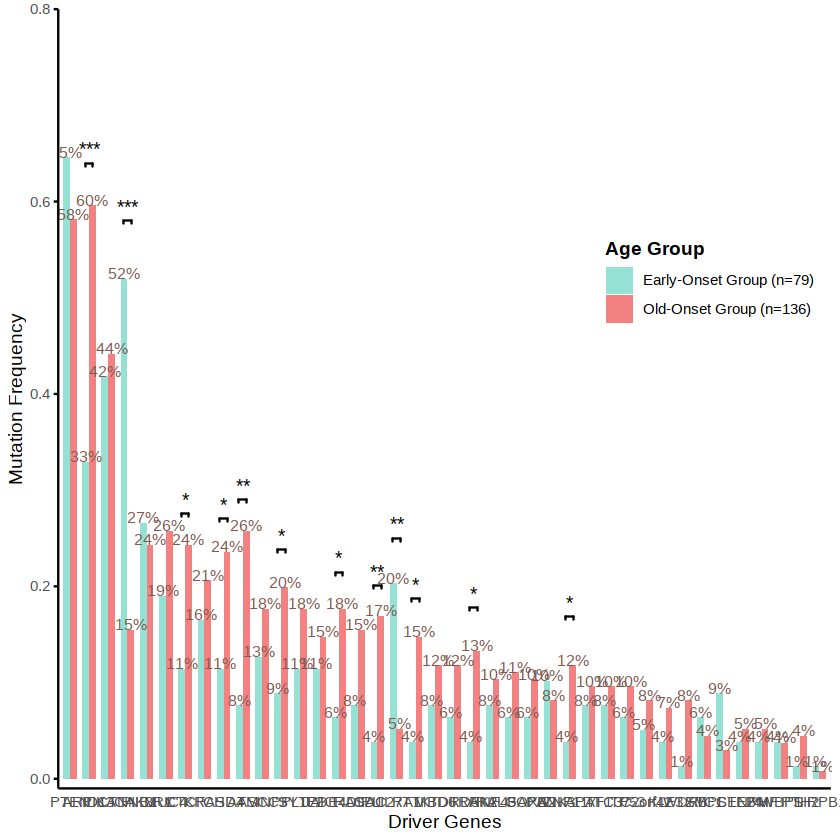

In [116]:
p_signif = p_withfreq + geom_signif(
    xmin = stat.test$xmin, xmax = stat.test$xmax, y_position = stat.test$y_position, 
    annotations =stat.test$signif, tip_length = 0.005
    )
p_signif
ggsave(p_signif,device = "pdf",file="Figure.1/Figure1D.age_group_diff_withsignif.pdf", width =24, height = 4)

### 1.4 Figure 2E BMI、TMB、LVSI、Subtype Compare

#### 1.4.1 TMB

In [21]:
library(viridis)
library(hrbrthemes)
library(ggsignif)
library(ggbeeswarm)

Loading required package: viridisLite

NOTE: Either Arial Narrow or Roboto Condensed fonts are required to use these themes.

      Please use hrbrthemes::import_roboto_condensed() to install Roboto Condensed and

      if Arial Narrow is not on your system, please see https://bit.ly/arialnarrow



In [22]:
common_clin_noAEH_noNAage_sort$age_group = factor(common_clin_noAEH_noNAage_sort$age_group,levels=c("Early","Old"))

In [23]:
common_Clin$detail_age_subtype = common_Clin$age_subtype
common_Clin$age_group = common_clin_noAEH_noNAage_sort$age_group

In [136]:
Figure1E = common_Clin %>% 
ggplot( aes(x=age_group , y=TMB_Nonsyno))+
stat_boxplot(geom ="errorbar", width = .3, size=.7,  coef = 1) +
  geom_boxplot(width = .55, outlier.shape = NA,  coef = 1) +
  geom_point(position = position_jitter(seed = 2021, width = .25),
             aes(color = age_group), alpha = .4, size = 3) +
  #scale_color_manual(values =  c("#3B9AB2", "#00A08A","#8479E1","#F4BBBB"))+
 #scale_x_discrete(position = "top") +
#facet_wrap(~ TCGA_Subtype,  nrow = 1, strip.position = "right") 
  theme_bw()+
  theme(strip.text = element_blank(),
        panel.spacing = unit(0, "cm"),
        axis.title.x = element_blank(),
        #axis.title.y=element_text("TMB"),
        axis.text.x = element_text(size = 12, vjust = 1,color="black"),
        axis.ticks.x.top = element_line(color = "black", size = .5),
        axis.ticks.length = unit(-0.2, "cm"),
        axis.ticks.y = element_line(color = "black", size = .5),
        axis.text.y = element_text(size = 10,color="black"),
        #legend.position = c(0.8,0.7),
        panel.grid = element_blank(),
        plot.margin=unit(c(0.5,0.1,0.5,0.1),"cm")) +
       #geom_rect(xmin=1, xmax=2, ymin=-1.7, ymax=-2.3, color="black", fill="white", size = .5)+
       geom_signif(comparisons = list(c("Early","Old")),
              map_signif_level=T,vjust=0.5,color="black",
              textsize=5,test=t.test,step_increase=0.1)+
        labs(title = "TMB of different Age Group in Total")+
    scale_color_manual(name = "Age Group",
                    labels=c("Early-Onset Group (n=79)    ",
                               "Old-Onset Group (n=136)    "),
                    values = c("#95e1d3",
                               "#f38181"))

In [137]:
pdf("Figure.1/Figure1E.age_group_diff_tmb.pdf")

Figure1E
dev.off()

Warning message:
“Removed 3 rows containing non-finite values (stat_boxplot).”
Warning message:
“Removed 3 rows containing non-finite values (stat_boxplot).”
Warning message:
“Removed 3 rows containing non-finite values (stat_signif).”
Warning message:
“Removed 3 rows containing missing values (geom_point).”


png 
  2

#### 1.4.2 BMI

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Warning message:
“Removed 43 rows containing missing values (stat_slabinterval).”
Warning message:
“Removed 43 rows containing non-finite values (stat_boxplot).”
Warning message:
“Removed 43 rows containing non-finite values (stat_signif).”
Warning message:
“Removed 43 rows containing missing values (geom_point).”


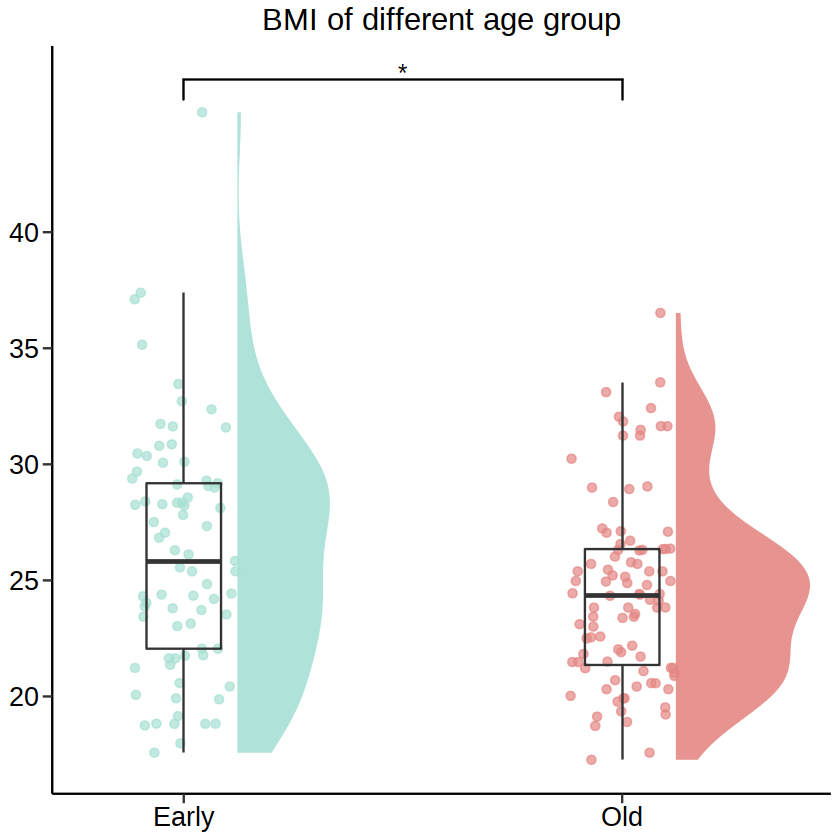

In [164]:
### 方案三
Figure1G=ggplot(common_clin_noAEH_noNAage_sort,aes(age_group,BMI))+
  ggdist::stat_halfeye(mapping = aes(fill=age_group),width = .34, .width = 0, justification = -.4, point_colour = NA,alpha=0.9) + 
  geom_jitter(mapping = aes(color=age_group),width = .12, alpha = .7,size=1.9)+
  geom_boxplot(width = .17, outlier.shape = NA,fill=NA,size=0.5)+
  labs(title = "BMI of different age group")+
  scale_y_continuous(expand = c(0.02,0))+
  scale_x_discrete(expand = c(0,0.3))+
  scale_fill_manual(values = c("Early"="#a6dfd3","Old"="#e48784"))+
  scale_color_manual(values = c("Early"="#a6dfd3","Old"="#e48784"))+

scale_y_continuous(breaks=c(20,25,30,35,40))+
 geom_signif(comparisons = list(c("Early","Old")),
              map_signif_level=T,vjust=0.5,color="black",
              textsize=5,test=wilcox.test,step_increase=0.1)

mytheme=theme_classic()+
  theme(
    axis.text.x.bottom = element_text(angle = 0,hjust = 0.5,size = 16,color = "black"),
    axis.text.y.left = element_text(size = 16,color = "black"),
    axis.title.y.left = element_blank(),
    axis.title.x.bottom = element_blank(),
    axis.ticks.length=unit(.2, "cm"),
    plot.title = element_text(size = 18,hjust = 0.5),
    legend.position = "none",
  )
Figure1G=Figure1G+mytheme
Figure1G

In [165]:
ggsave(Figure1G,file = "Figure.1/Figure1G.age_group_diff_bmi.pdf")

Saving 6.67 x 6.67 in image

Warning message:
“Removed 43 rows containing missing values (stat_slabinterval).”
Warning message:
“Removed 43 rows containing non-finite values (stat_boxplot).”
Warning message:
“Removed 43 rows containing non-finite values (stat_signif).”
Warning message:
“Removed 43 rows containing missing values (geom_point).”


#### 1.4.3 LVSI

In [167]:
library(ggstatsplot)
Figure1H = ggbarstats(common_clin_noAEH_noNAage_sort,y=age_group,x=Obesity)+
scale_fill_manual(values=c("Obesity"="#e56186","Normal"="#cee6ce"))

Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.



In [169]:
ggsave(Figure1H,file = "Figure.1/Figure1H.age_group_diff_obesity.pdf")

Saving 6.67 x 6.67 in image



In [170]:
table(common_clin_noAEH_noNAage_sort$`LVSI(无/有)`)


 无  有 
131  84 

In [172]:
common_clin_noAEH_noNAage_sort$LVSI_Status = common_clin_noAEH_noNAage_sort$`LVSI(无/有)`
common_clin_noAEH_noNAage_sort$LVSI_Status = gsub("无","No",common_clin_noAEH_noNAage_sort$LVSI_Status)
common_clin_noAEH_noNAage_sort$LVSI_Status = gsub("有","Broad",common_clin_noAEH_noNAage_sort$LVSI_Status)
focal_clin = common_clin_noAEH_noNAage_sort %>% filter(`LVSI（局灶/广泛）`=="局灶")
common_clin_noAEH_noNAage_sort[common_clin_noAEH_noNAage_sort$patient %in% focal_clin$patient,]$LVSI_Status = "Focal"

In [173]:
table(common_clin_noAEH_noNAage_sort$LVSI_Status)


Broad Focal    No 
   56    28   131 

In [176]:
common_clin_noAEH_noNAage_sort$LVSI_Status = factor(common_clin_noAEH_noNAage_sort$LVSI_Status,levels = c("No","Focal","Broad"))

In [178]:
Figure1H = ggbarstats(common_clin_noAEH_noNAage_sort,y=age_group,x=LVSI_Status)+
scale_fill_manual(values=c("Broad"="#e56186","Focal"="#f3aaab","No"="#cee6ce"))

Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.



In [180]:
ggsave(Figure1H,file = "Figure.1/Figure1H.age_group_diff_lvsi.pdf")

Saving 6.67 x 6.67 in image



#### 1.4.4 Subtype

In [24]:
# 加载包及导入数据
library(ggplot2)
library(ggthemes)
library(tidyverse)
library(ggalluvial)
library(ggsci)
library(cowplot)
library(tastypie)


Attaching package: ‘cowplot’


The following object is masked from ‘package:ggthemes’:

    theme_map


            $$  $$  $$
          __||__||__||__
         | * * * * * * *|
         |* * * * * * * |
         | * * * * * * *|
         |______________|
 _              _              _
| |_  ___  ___ | |_  _ _  ___ |_| ___
|  _|| .'||_ -||  _|| | || . || || -_|
|_|  |__,||___||_|  |_  ||  _||_||___|
                    |___||_|          



In [25]:
subtype_early = common_clin_noAEH_noNAage_sort %>% filter(age_at_diagnosis <= 40 )%>% group_by(Subtype) %>% summarise(n())
subtype_old = common_clin_noAEH_noNAage_sort %>% filter(age_at_diagnosis > 40 )%>% group_by(Subtype) %>% summarise(n())

In [26]:
subtype_early$age = "Early"
subtype_early$pct = subtype_early$`n()` / sum(subtype_early$`n()`)
subtype_old$age = "Old"
subtype_old$pct = subtype_old$`n()` / sum(subtype_old$`n()`)
subtype_input = rbind(subtype_early,subtype_old)
colnames(subtype_input)[2] = "Count"
subtype_input$Subtype = factor(subtype_input$Subtype, 
                               levels = c("POLE_ultramutated",
                                          "MSI_hypermutated",
                                          "CN low",
                                          "CN high"))
subtype_input$age = factor(subtype_input$age, 
                               levels = c("Early",
                                          "Old"))

In [29]:
subtype_input_chisq_test = data.frame(CNH=c(2,5),CNL=c(60,78),MSI=c(13,39),POLE=c(4,14))
subtype_input_chisq_test
fisher.test(subtype_input_chisq_test)
chisq.test(subtype_input_chisq_test)

CNH,CNL,MSI,POLE
<dbl>,<dbl>,<dbl>,<dbl>
2,60,13,4
5,78,39,14



	Fisher's Exact Test for Count Data

data:  subtype_input_chisq_test
p-value = 0.05302
alternative hypothesis: two.sided


Warning message in chisq.test(subtype_input_chisq_test):
“Chi-squared approximation may be incorrect”



	Pearson's Chi-squared test

data:  subtype_input_chisq_test
X-squared = 7.6125, df = 3, p-value = 0.05474


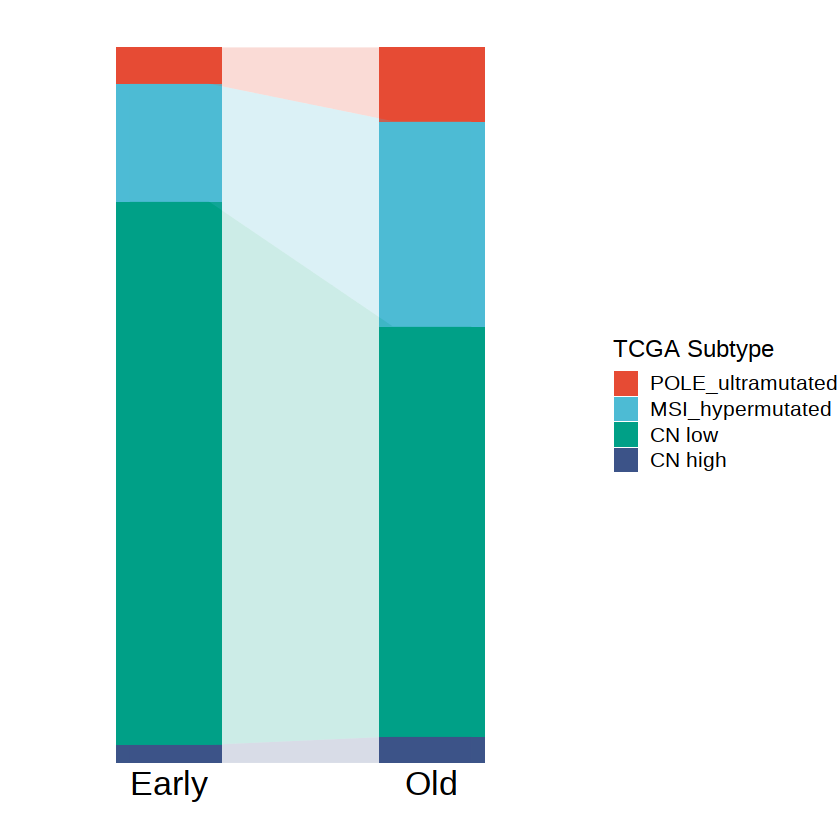

In [145]:
Figure1F= ggplot(subtype_input, 
       aes(x = age,y=pct,fill = Subtype,
          stratum = Subtype, alluvium = Subtype)) +
  geom_bar(stat="identity",position = "fill",width=0.4)+
  theme_base()+
geom_alluvium( width = 0.3,alpha = 0.2,knot.pos = 0,segments=10)+
  scale_fill_manual(values = pal_npg()(4))+
  theme_map()+
  theme(axis.text.x=element_text(size=20,vjust = 5),
        )+
labs(fill = "TCGA Subtype")

Figure1F

In [147]:
ggsave(Figure1F,file="Figure.1/Figure1F.age_group_diff_subtype.pdf")

Saving 6.67 x 6.67 in image



## 2.Figure.3

### 2.1 Age_sort Signature barplot

In [191]:
library(deconstructSigs)
library(sigminer)
library(NMF)

sigminer version 2.1.2
- Star me at https://github.com/ShixiangWang/sigminer
- Run hello() to see usage and citation.


Attaching package: ‘sigminer’


The following object is masked from ‘package:maftools’:

    MAF


Loading required package: pkgmaker

Loading required package: registry

Loading required package: rngtools

Loading required package: cluster

NMF - BioConductor layer [OK] | Shared memory capabilities [OK] | Cores 31/32



In [192]:
mats <- mt_tally <- sig_tally(
  common_age_laml,
  ref_genome = "BSgenome.Hsapiens.UCSC.hg19",
  useSyn = TRUE,
  mode = "ALL"
)

ℹ [2022-06-18 13:55:32]: Started.

ℹ [2022-06-18 13:56:06]: We would assume you marked all variants' position in + strand.


Attaching package: ‘S4Vectors’


The following object is masked from ‘package:NMF’:

    nrun


The following object is masked from ‘package:pkgmaker’:

    new2


The following objects are masked from ‘package:reshape’:

    expand, rename


The following objects are masked from ‘package:dplyr’:

    first, rename


The following object is masked from ‘package:tidyr’:

    expand


The following objects are masked from ‘package:base’:

    expand.grid, I, unname



Attaching package: ‘IRanges’


The following objects are masked from ‘package:dplyr’:

    collapse, desc, slice


The following object is masked from ‘package:purrr’:

    reduce



Attaching package: ‘XVector’


The following object is masked from ‘package:purrr’:

    compact



Attaching package: ‘Biostrings’


The following object is masked from ‘package:grid’:

    pattern


The following object

In [193]:
cosmic_legacy_absolute_fit <- sig_fit(mt_tally$SBS_96 %>% t(), 
                             sig_index = "ALL", 
                             sig_db = "legacy",
                             db_type = "human-exome",
                             type = "absolute",
                              mode = "SBS")
cosmic_legacy_relative_fit <- sig_fit(mt_tally$SBS_96 %>% t(), 
                             sig_index = "ALL", 
                             sig_db = "legacy",
                             db_type = "human-exome",
                             type = "relative",
                              mode = "SBS")
head(cosmic_legacy_absolute_fit)
head(cosmic_legacy_relative_fit)

ℹ [2022-06-18 13:59:35]: Started.

✔ [2022-06-18 13:59:35]: Signature index detected.

ℹ [2022-06-18 13:59:35]: Checking signature database in package.

ℹ [2022-06-18 13:59:35]: Checking signature index.

ℹ [2022-06-18 13:59:35]: Valid index for db 'legacy':
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30

✔ [2022-06-18 13:59:35]: Database and index checked.

✔ [2022-06-18 13:59:35]: Signature normalized.

ℹ [2022-06-18 13:59:35]: Checking row number for catalog matrix and signature matrix.

✔ [2022-06-18 13:59:35]: Checked.

ℹ [2022-06-18 13:59:35]: Checking rownames for catalog matrix and signature matrix.

ℹ [2022-06-18 13:59:35]: Matrix V and W don't have same orders. Try reordering...

✔ [2022-06-18 13:59:35]: Checked.

✔ [2022-06-18 13:59:35]: Method 'QP' detected.

✔ [2022-06-18 13:59:35]: Corresponding function generated.

ℹ [2022-06-18 13:59:35]: Calling function.

ℹ [2022-06-18 13:59:35]: Fitting sample: FD_BY_004_C

ℹ [2022-06-18 13:59:35]: F

,FD_BY_004_C,FD_BY_005_C,FD_BY_006_C,FD_BY_007_C,FD_BY_008_C,FD_BY_009_C,FD_BY_010_C,FD_BY_011_C,FD_BY_012_C,FD_BY_013_C,⋯,TJ_L_018_C,TJ_L_019_C,TJ_L_020_C,TJ_L_021_C,TJ_L_022_C,TJ_L_023_C,TJ_L_024_C,TJ_L_025_C,TJ_L_026_C,TJ_L_027_C
COSMIC_1,155.90159,0.000000,300.02094,0,3.634014,18.354338,126.23650,0.000000,59.11667,0,⋯,145.912358,128.012267,25.111852,90.824350,91.93632,0,80.248268,174.07580,50.03982,1058.741
COSMIC_2,27.14713,0.977004,29.29348,0,0.000000,5.016209,21.32412,1.321186,0.00000,0,⋯,0.671305,0.000000,9.595898,0.097385,0.00000,0,3.293384,0.00000,0.00000,0.000
COSMIC_3,0.00000,0.000000,0.00000,0,0.000000,14.809913,0.00000,0.000000,0.00000,0,⋯,10.212231,13.017512,0.000000,0.000000,0.00000,0,0.000000,0.00000,0.00000,0.000
COSMIC_4,0.00000,0.000000,22.07831,0,0.000000,0.000000,0.00000,0.000000,0.00000,0,⋯,0.000000,8.314259,0.000000,0.000000,0.00000,0,0.000000,60.00840,0.00000,0.000
COSMIC_5,0.00000,0.000000,0.00000,0,3.026251,0.000000,0.00000,0.000000,0.00000,0,⋯,0.000000,29.530796,0.000000,0.000000,0.00000,0,35.484254,20.84883,0.00000,0.000
COSMIC_6,20.41475,16.210101,176.77380,0,0.664902,30.858392,910.51713,42.644054,0.00000,0,⋯,235.998088,25.463929,79.663448,10.994418,0.00000,0,16.921083,334.09439,26.70209,2454.033


,FD_BY_004_C,FD_BY_005_C,FD_BY_006_C,FD_BY_007_C,FD_BY_008_C,FD_BY_009_C,FD_BY_010_C,FD_BY_011_C,FD_BY_012_C,FD_BY_013_C,⋯,TJ_L_018_C,TJ_L_019_C,TJ_L_020_C,TJ_L_021_C,TJ_L_022_C,TJ_L_023_C,TJ_L_024_C,TJ_L_025_C,TJ_L_026_C,TJ_L_027_C
COSMIC_1,0.225617,0.000000,0.280393,0,0.259572,0.201696,0.052996,0.000000,0.117295,0,⋯,0.287229,0.263400,0.121313,0.203642,0.596989,0,0.194777,0.207480,0.257937,0.278689
COSMIC_2,0.039287,0.016016,0.027377,0,0.000000,0.055123,0.008952,0.003003,0.000000,0,⋯,0.001321,0.000000,0.046357,0.000218,0.000000,0,0.007994,0.000000,0.000000,0.000000
COSMIC_3,0.000000,0.000000,0.000000,0,0.000000,0.162746,0.000000,0.000000,0.000000,0,⋯,0.020103,0.026785,0.000000,0.000000,0.000000,0,0.000000,0.000000,0.000000,0.000000
COSMIC_4,0.000000,0.000000,0.020634,0,0.000000,0.000000,0.000000,0.000000,0.000000,0,⋯,0.000000,0.017108,0.000000,0.000000,0.000000,0,0.000000,0.071524,0.000000,0.000000
COSMIC_5,0.000000,0.000000,0.000000,0,0.216161,0.000000,0.000000,0.000000,0.000000,0,⋯,0.000000,0.060763,0.000000,0.000000,0.000000,0,0.086127,0.024850,0.000000,0.000000
COSMIC_6,0.029544,0.265739,0.165209,0,0.047493,0.339103,0.382249,0.096918,0.000000,0,⋯,0.464563,0.052395,0.384848,0.024651,0.000000,0,0.041071,0.398205,0.137640,0.645968


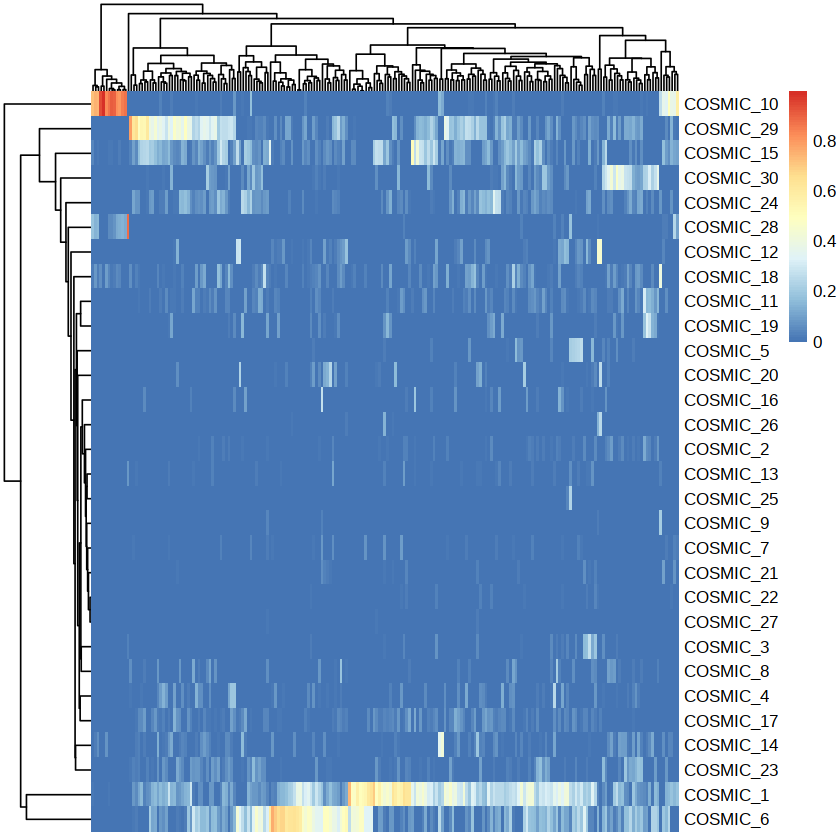

In [194]:
pheatmap::pheatmap(cosmic_legacy_relative_fit,
                   cluster_cols=T,
                   cluster_rows=T,show_colnames = F,
                   show_rownames = T)

In [195]:
library(reshape2)


Attaching package: ‘reshape2’


The following objects are masked from ‘package:reshape’:

    colsplit, melt, recast


The following object is masked from ‘package:tidyr’:

    smiths




In [196]:
cosmic_legacy_absolute_fit_input = t(cosmic_legacy_absolute_fit)
cosmic_legacy_absolute_fit_input = as.data.frame(cosmic_legacy_absolute_fit_input)
cosmic_legacy_absolute_fit_input$Sample = rownames(cosmic_legacy_absolute_fit_input)
cosmic_legacy_relative_fit_input = t(cosmic_legacy_relative_fit)
cosmic_legacy_relative_fit_input = as.data.frame(cosmic_legacy_relative_fit_input)
cosmic_legacy_relative_fit_input$Sample = rownames(cosmic_legacy_relative_fit_input)

In [197]:
data_long_m<-melt(cosmic_legacy_absolute_fit_input, id.vars = c("Sample"), #需保留的不参与聚合的变量列名
                  measure.vars = paste0("COSMIC_",1:30),#需要聚合的变量s1-s10
                  variable.name = c('Signature'),#聚合变量的新列名
                  value.name = 'Contribution')#聚合值的新列名
data_long_relative_m <-melt(cosmic_legacy_relative_fit_input, id.vars = c("Sample"), #需保留的不参与聚合的变量列名
                  measure.vars = paste0("COSMIC_",1:30),#需要聚合的变量s1-s10
                  variable.name = c('Signature'),#聚合变量的新列名
                  value.name = 'Contribution')#聚合值的新列名

In [198]:
COSMIC_29_order = data_long_relative_m %>% filter(Signature == "COSMIC_29") %>% arrange(Contribution)

In [200]:
age_order = common_clin_noAEH_noNAage_sort %>% arrange(age_at_diagnosis) 

In [219]:
Firgure.3A1 <- ggplot(data_long_relative_m %>% filter(Signature %in% paste0("COSMIC_",c(1,6,10,15,20,24,29,30))),
             aes(x = factor(Sample,levels = age_order$Tumor_Sample_Barcode), y = Contribution, fill = factor(Signature), order = Sample)) + geom_bar(stat = "identity", position = "fill") + 
  scale_y_continuous(expand = c(0,0)) + scale_x_discrete(breaks = NULL) +
  ylab("Normalized proportion \nof signature") + xlab("Patients(sorted by age-at-diagnosis)") +  
    scale_fill_manual(values = c("COSMIC_1"="#835ec1",
                               "COSMIC_6"="#d65db1",
                               "COSMIC_10"="#ff6f92",
                               "COSMIC_15"="#ff9670",
                               "COSMIC_20"="#ffc75f",
                               "COSMIC_24"="#f9f872",
                               "COSMIC_29"="#00c9a8",
                                "COSMIC_30"= "#6e69a7"
                              )) + 
  theme_classic() +
  geom_vline(aes(xintercept = 79),linetype = "dashed")+
  annotate(geom="text", x=79.5, y=1, label="Age-at-diagnosis-40",color="black", fontface="bold") +
geom_vline(aes(xintercept = 155),linetype = "dashed")+
  annotate(geom="text", x=155.5, y=1, label="Age-at-diagnosis-55",color="black", fontface="bold") +
  theme(legend.position = "none") 

Warning message:
“Removed 8 rows containing missing values (geom_bar).”


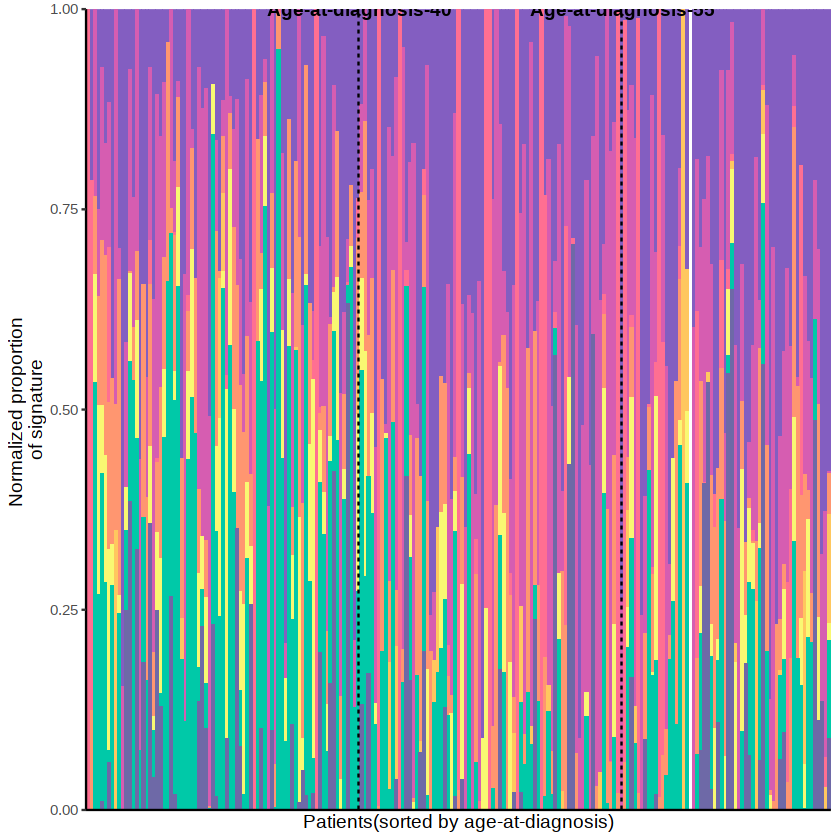

In [220]:
Firgure.3A1

In [221]:
Firgure.3A2 <- ggplot(data_long_m %>% filter(Signature %in% paste0("COSMIC_",c(1,6,10,15,20,24,29,30))), aes(x = factor(Sample,levels = age_order$Tumor_Sample_Barcode), y = Contribution, 
                               fill = factor(Signature), order = Sample)) + 
  geom_bar(stat = "identity") + 
  scale_y_continuous(expand = c(0,0)) + scale_x_discrete(breaks = NULL) +
  xlab("") + ylab("Number of mutations \n ") + 
  labs(fill="Mutation Signauture")+
  scale_fill_manual(values = c("COSMIC_1"="#835ec1",
                               "COSMIC_6"="#d65db1",
                               "COSMIC_10"="#ff6f92",
                               "COSMIC_15"="#ff9670",
                               "COSMIC_20"="#ffc75f",
                               "COSMIC_24"="#f9f872",
                               "COSMIC_29"="#00c9a8",
                                "COSMIC_30"= "#6e69a7"
                              )) + 
  theme_classic() +
  #scale_y_log10()+
  #theme(legend.position = c(0.5, 0.86)) +
  theme(legend.background = element_blank())

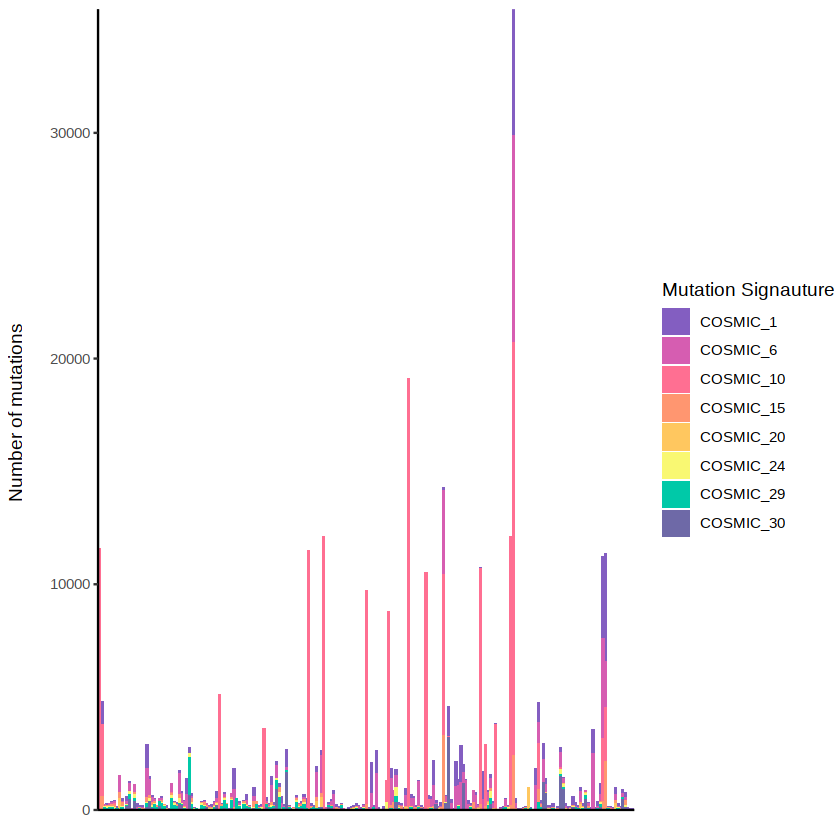

In [210]:
Firgure.3A2

In [211]:
library(patchwork)


Attaching package: ‘patchwork’


The following object is masked from ‘package:cowplot’:

    align_plots




In [225]:
Figure3A = Firgure.3A2/Firgure.3A1

Warning message:
“Removed 8 rows containing missing values (geom_bar).”


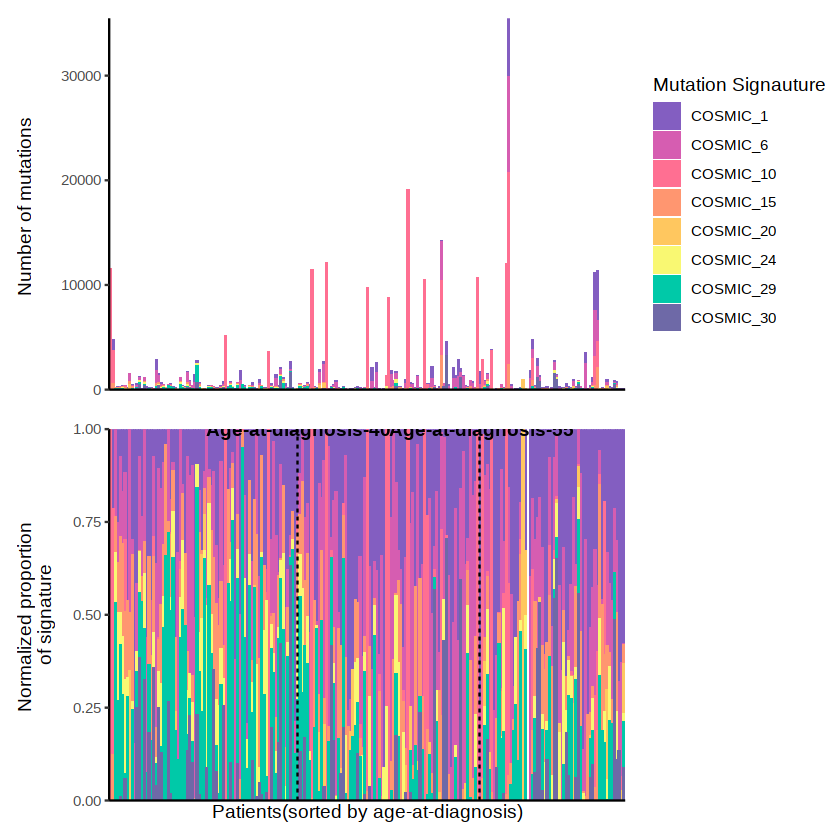

In [226]:
Figure3A

In [227]:
ggsave(Figure3,file="Figure.2/Figure.3A_signature_pct.pdf")

Saving 6.67 x 6.67 in image

Warning message:
“Removed 8 rows containing missing values (geom_bar).”


### 2.2 Age_signature pct compare 

#### denovo 

In [256]:
SBS_age_compare_plot = as.data.frame(t(mt_sig$Exposure.norm))

In [257]:
head(SBS_age_compare_plot)

,Sig1,Sig2,Sig3,Sig4,Sig5,Sig6,Sig7,Sig8,Sig9,Sig10,Sig11,Sig12,Sig13,Sig14
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
FD_BY_004_C,8.399116e-323,1.140570e-01,1.851871e-01,0.15572919,2.747271e-02,0.24219593,2.481061e-02,0.10547376,0.00000000,1.907041e-02,4.940656e-324,0.000000000,0.12297700,0.003026364
FD_BY_005_C,5.853710e-03,2.521005e-01,2.203373e-01,0.04119543,6.422853e-323,0.09944934,3.458460e-323,0.17302460,0.01870521,1.482197e-323,2.425557e-02,0.052978059,0.10464798,0.007452315
FD_BY_006_C,1.976263e-323,3.870057e-02,4.016274e-01,0.16697558,3.138372e-02,0.09900231,2.578558e-02,0.13109541,0.00604577,3.437904e-02,2.516011e-122,0.008989628,0.02717477,0.028840175
FD_BY_007_C,5.935955e-01,5.063498e-02,4.940656e-324,0.01243603,5.284481e-02,0.02436222,3.211384e-02,0.01782528,0.13531171,1.700084e-02,1.252091e-16,0.041420888,0.02055844,0.001895490
FD_BY_008_C,0.000000e+00,2.766768e-322,0.000000e+00,0.14976594,0.000000e+00,0.00000000,0.000000e+00,0.00000000,0.16487862,2.964394e-322,2.563912e-01,0.000000000,0.08044733,0.348516890
FD_BY_009_C,0.000000e+00,1.389545e-02,2.076901e-01,0.19742038,4.444568e-02,0.08086564,1.716040e-01,0.01263602,0.01822421,3.428011e-03,7.465901e-02,0.000000000,0.05223978,0.122891719


In [258]:
SBS_age_compare_plot = as.data.frame(t(mt_sig$Exposure.norm))
SBS_age_compare_plot = SBS_age_compare_plot[ common_clin_noAEH_noNAage_sort$Tumor_Sample_Barcode,]
SBS_age_compare_plot = cbind(common_clin_noAEH_noNAage_sort$age_group,SBS_age_compare_plot)
colnames(SBS_age_compare_plot)[1] ="age_group"
SBS_age_compare_plot$Tumor_Sample_Barcode = rownames(SBS_age_compare_plot)

In [259]:
SBS_age_compare_plot_long = melt(SBS_age_compare_plot,
                  id.vars=c("Tumor_Sample_Barcode","age_group"),
                  variable.name="Exposure.norm",
                  value.name="signature"
                  ) %>%
                arrange(Tumor_Sample_Barcode)
colnames(SBS_age_compare_plot_long)[c(3,4)]=c("signature","Exposure.norm")

In [260]:
SBS_age_compare_plot_long$age_group = factor(SBS_age_compare_plot_long$age_group, levels=c("Early","Old"))

Warning message:
“Removed 42 rows containing non-finite values (stat_boxplot).”


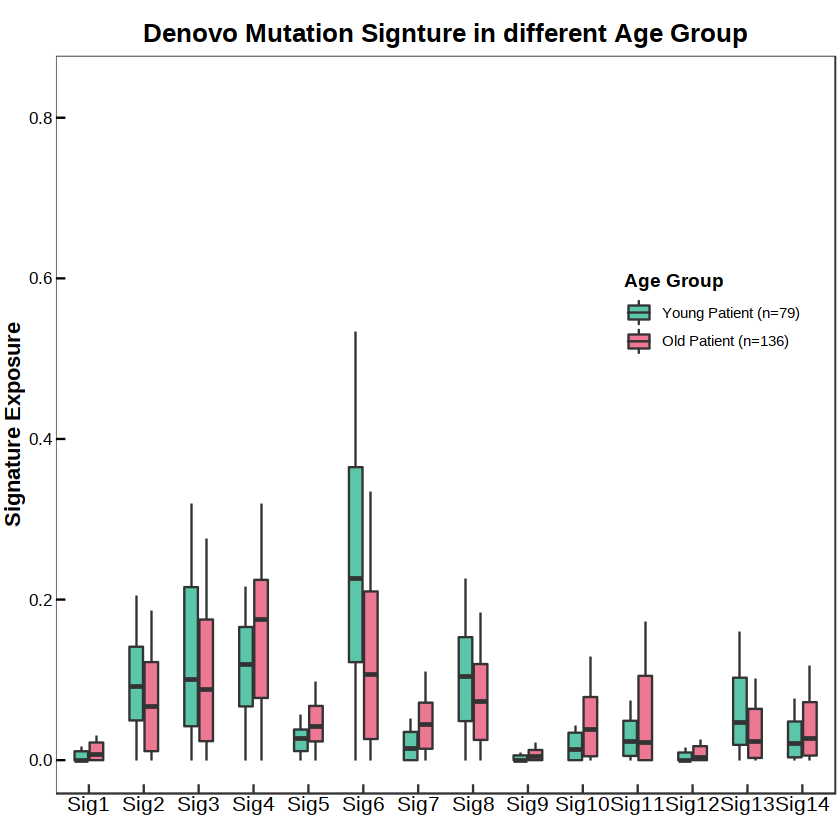

In [284]:
p1_age_newcol = SBS_age_compare_plot_long %>% 
ggplot( aes(x=signature , y=Exposure.norm,fill=age_group))+
#stat_boxplot(geom ="errorbar", width = .3, size=.7,  coef = 0.4)+
geom_boxplot(width = .55, outlier.shape = NA,  coef = 0.7)+
scale_fill_manual(values =  c("Early" ="#5bc6a9","Old"= "#ed7893"),
                 labels=c("Young Patient (n=79)    ",
                               "Old Patient (n=136)    "),
                 name = "Age Group")+
theme_bw()+
theme(legend.title = element_text(face="bold"),
      legend.position = c(.85, .65),
      plot.title = element_text(hjust=0.5,face="bold", size=15),
        strip.text = element_blank(),
        panel.spacing = unit(0, "cm"),
        axis.title.x = element_blank(),
          axis.title.y = element_text(face="bold", size=13),
        axis.text.x = element_text(size = 12, vjust = 1,color="black"),
        axis.ticks.x.top = element_line(color = "black", size = .5),
        axis.ticks.length = unit(-0.2, "cm"),
        axis.ticks.y = element_line(color = "black", size = .5),
        axis.text.y = element_text(size = 10,color="black"),
        #legend.position = "none",
        panel.grid = element_blank(),
        plot.margin=unit(c(0.5,0.1,0.5,0.1),"cm"))+
labs(y="Signature Exposure"
    ,title = "Denovo Mutation Signture in different Age Group")
p1_age_newcol

In [261]:
## prepare low_high_t_signif_input 
t_age_df = data.frame()
for (i in 1:14) {
    sig = paste0("Sig",i)
    t_input = SBS_age_compare_plot_long %>% 
                filter(signature ==sig)
    t = t.test(Exposure.norm~age_group,data=t_input)
    t_age_df = rbind(t_age_df, data.frame(
        Sig = sig,
        test_method = t$method,
        p_value = t$p.value))
    }

In [262]:
t_age_df = t_age_df[t_age_df$p_value <0.05,]

In [263]:
t_age_df = t_age_df[t_age_df$p_value <0.05,]
t_age_df$x = as.numeric(rownames(t_age_df))
t_age_df$xmin = t_age_df$x - 0.15
t_age_df$xmax = t_age_df$x + 0.15
t_age_df$y_position = c(0.37,0.13,0.58,0.14,0.27,0.16,0.24,0.20)
t_age_df$signif = p2star(t_age_df$p_value)

Warning message:
“Removed 42 rows containing non-finite values (stat_boxplot).”
Warning message:
“Removed 42 rows containing non-finite values (stat_signif).”


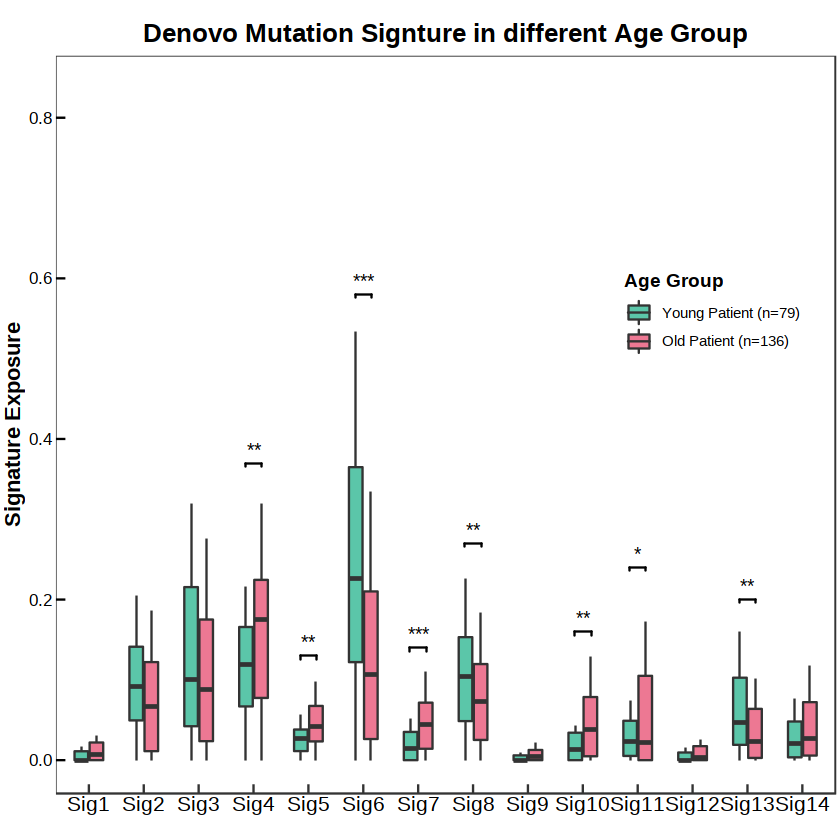

In [285]:
#2样本t检验，多样本kw检验
p1_age_withtest = 
p1_age_newcol + 
    geom_signif(
    xmin = t_age_df$xmin, xmax = t_age_df$xmax, y_position = t_age_df$y_position, 
    annotations =t_age_df$signif, tip_length = 0.005
    )
p1_age_withtest

In [286]:
ggsave(p1_age_withtest,file="Figure.2/Figure.3D_signature_pct_compare.pdf")

Saving 6.67 x 6.67 in image

Warning message:
“Removed 42 rows containing non-finite values (stat_boxplot).”
Warning message:
“Removed 42 rows containing non-finite values (stat_signif).”


### 2.3 Age signature spearman

#### load denovo signature

In [228]:
load("../../02.UCEC/Fig2/output//6.signature//SBS.signature.RDa")

In [229]:
sig_count = mt_sig$Exposure
sig_count = t(sig_count)
sig_count = as.data.frame(sig_count)
sig_count$Tumor_Sample_Barcode = rownames(sig_count)

In [232]:
common_sig_count = sig_count[ common_clin_noAEH_noNAage_sort$Tumor_Sample_Barcode,]

In [233]:
common_sig_count_clin = merge(common_sig_count,common_clin_noAEH_noNAage_sort,by="Tumor_Sample_Barcode")

In [235]:
library(ggpubr)


Attaching package: ‘ggpubr’


The following object is masked from ‘package:cowplot’:

    get_legend




`geom_smooth()` using formula 'y ~ x'



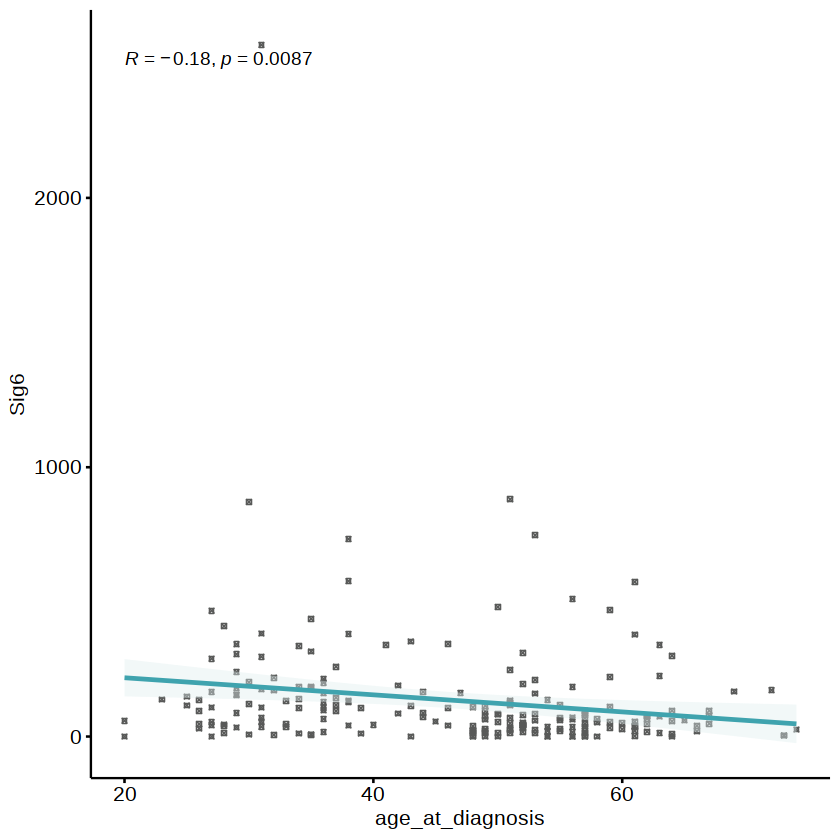

In [236]:
ggscatter(common_sig_count_clin, x = "age_at_diagnosis", y = "Sig6", 
          add = "reg.line", conf.int = TRUE, 
          add.params = list(color = "#3fa3ae", fill = "#deeded"),
          shape = 7,size= 1,color ="#585958",
          cor.coef = TRUE, cor.method = "pearson")

`geom_smooth()` using formula 'y ~ x'



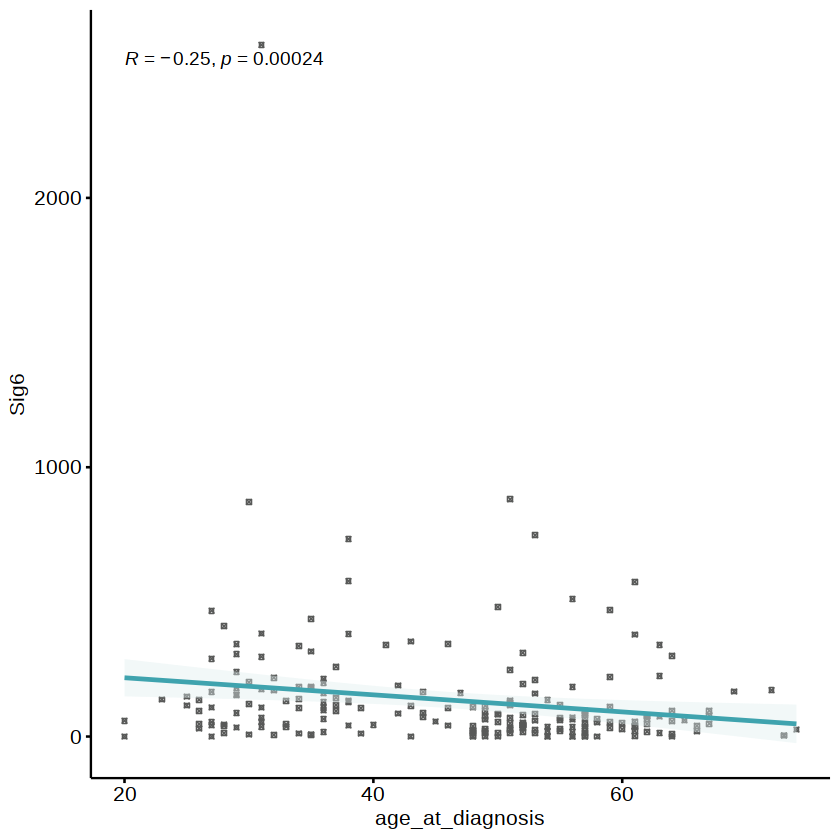

In [237]:
ggscatter(common_sig_count_clin, x = "age_at_diagnosis", y = "Sig6", 
          add = "reg.line", conf.int = TRUE, 
          add.params = list(color = "#3fa3ae", fill = "#deeded"),
          shape = 7,size= 1,color ="#585958",
          cor.coef = TRUE, cor.method = "spearman")

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'



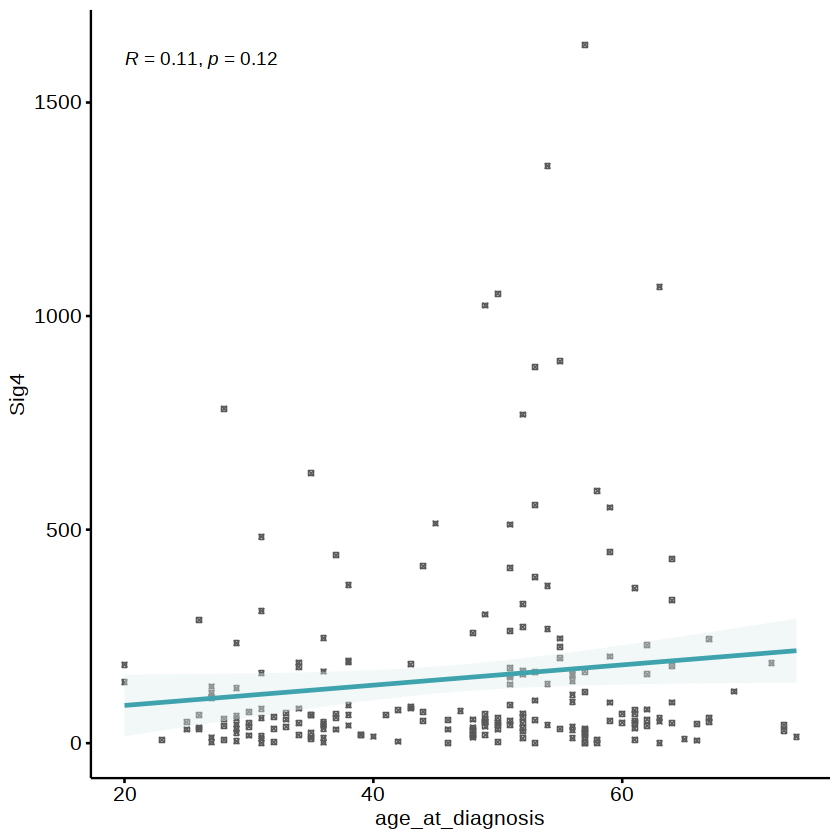

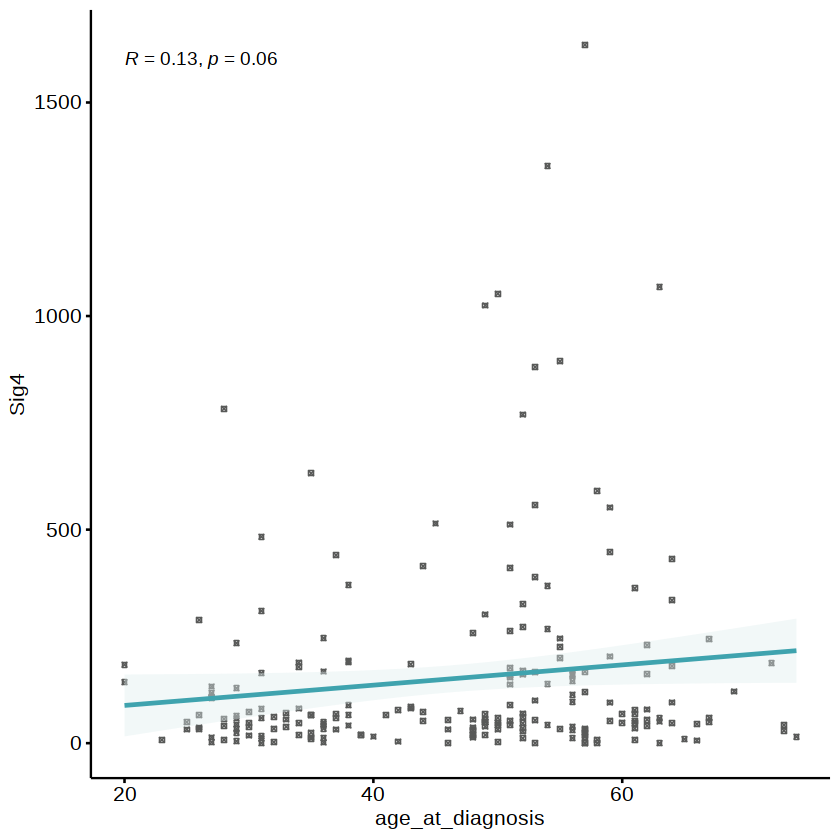

In [238]:
ggscatter(common_sig_count_clin, x = "age_at_diagnosis", y = "Sig4", 
          add = "reg.line", conf.int = TRUE, 
          add.params = list(color = "#3fa3ae", fill = "#deeded"),
          shape = 7,size= 1,color ="#585958",
          cor.coef = TRUE, cor.method = "spearman")
ggscatter(common_sig_count_clin, x = "age_at_diagnosis", y = "Sig4", 
          add = "reg.line", conf.int = TRUE, 
          add.params = list(color = "#3fa3ae", fill = "#deeded"),
          shape = 7,size= 1,color ="#585958",
          cor.coef = TRUE, cor.method = "pearson")

In [244]:
for (i in 1:14){
    p1 = ggscatter(common_sig_count_clin, x = "age_at_diagnosis", y = paste0("Sig",i), 
              add = "reg.line", conf.int = TRUE, 
              add.params = list(color = "#3fa3ae", fill = "#deeded"),
              shape = 7,size= 1,color ="#585958",
              cor.coef = TRUE, cor.method = "spearman")
    ggsave(p1,file = paste0("Figure.2/denovo_signature_spearman/denovo_signature",i,"_spearman.pdf"))

    p2 = ggscatter(common_sig_count_clin, x = "age_at_diagnosis", y =  paste0("Sig",i), 
              add = "reg.line", conf.int = TRUE, 
              add.params = list(color = "#3fa3ae", fill = "#deeded"),
              shape = 7,size= 1,color ="#585958",
              cor.coef = TRUE, cor.method = "pearson")
    
    ggsave(p2,file = paste0("Figure.2/denovo_signature_spearman/denovo_signature",i,"_pearson.pdf"))
}

Saving 6.67 x 6.67 in image

`geom_smooth()` using formula 'y ~ x'

Saving 6.67 x 6.67 in image

`geom_smooth()` using formula 'y ~ x'

Saving 6.67 x 6.67 in image

`geom_smooth()` using formula 'y ~ x'

Saving 6.67 x 6.67 in image

`geom_smooth()` using formula 'y ~ x'

Saving 6.67 x 6.67 in image

`geom_smooth()` using formula 'y ~ x'

Saving 6.67 x 6.67 in image

`geom_smooth()` using formula 'y ~ x'

Saving 6.67 x 6.67 in image

`geom_smooth()` using formula 'y ~ x'

Saving 6.67 x 6.67 in image

`geom_smooth()` using formula 'y ~ x'

Saving 6.67 x 6.67 in image

`geom_smooth()` using formula 'y ~ x'

Saving 6.67 x 6.67 in image

`geom_smooth()` using formula 'y ~ x'

Saving 6.67 x 6.67 in image

`geom_smooth()` using formula 'y ~ x'

Saving 6.67 x 6.67 in image

`geom_smooth()` using formula 'y ~ x'

Saving 6.67 x 6.67 in image

`geom_smooth()` using formula 'y ~ x'

Saving 6.67 x 6.67 in image

`geom_smooth()` using formula 'y ~ x'

Saving 6.67 x 6.67 in image

`geom_smooth()` usi

#### cosmic signature

In [247]:
cosmic_legacy_absolute_fit_t = t(cosmic_legacy_absolute_fit)
cosmic_legacy_absolute_fit_t =as.data.frame(cosmic_legacy_absolute_fit_t)
cosmic_legacy_absolute_fit_t$Tumor_Sample_Barcode = rownames(cosmic_legacy_absolute_fit_t)

In [248]:
common_cosmic_count = cosmic_legacy_absolute_fit_t[ common_clin_noAEH_noNAage_sort$Tumor_Sample_Barcode,]
common_cosmic_count_clin = merge(common_cosmic_count,common_clin_noAEH_noNAage_sort,by="Tumor_Sample_Barcode")

In [249]:
common_cosmic_count_clin

Tumor_Sample_Barcode,COSMIC_1,COSMIC_2,COSMIC_3,COSMIC_4,COSMIC_5,COSMIC_6,COSMIC_7,COSMIC_8,COSMIC_9,⋯,Recur_time,Death,Dead_time,LVSI,INTEN_BI,INTEN_TRI,age_group,detail_age_subtype,Obesity,LVSI_Status
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dttm>,<dbl>,<dttm>,<dbl>,<chr>,<chr>,<fct>,<chr>,<chr>,<fct>
FD_BY_004_C,155.901590,27.147132,0.00000,0.000000,0.000000,20.414747,0.000000,0.000000,0,⋯,NA,0,NA,NA,0,0,Early,(19-40],Normal,No
FD_BY_005_C,0.000000,0.977004,0.00000,0.000000,0.000000,16.210101,0.000000,0.000000,0,⋯,2018-11-16,0,NA,NA,1,2,Early,(19-40],Obesity,No
FD_BY_006_C,300.020944,29.293484,0.00000,22.078314,0.000000,176.773801,0.000000,7.376704,0,⋯,NA,0,NA,NA,0,0,Early,(19-40],Obesity,No
FD_BY_007_C,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0,⋯,2020-06-30,0,NA,NA,1,2,Early,(19-40],Normal,No
FD_BY_008_C,3.634014,0.000000,0.00000,0.000000,3.026251,0.664902,0.000000,0.000000,0,⋯,NA,0,NA,NA,0,0,Early,(19-40],Normal,No
FD_BY_009_C,18.354338,5.016209,14.80991,0.000000,0.000000,30.858392,0.000000,0.000000,0,⋯,2019-04-11,0,NA,NA,1,2,Early,(19-40],Obesity,No
FD_BY_010_C,126.236500,21.324122,0.00000,0.000000,0.000000,910.517134,0.000000,0.000000,0,⋯,NA,0,NA,NA,0,0,Early,(19-40],Normal,No
FD_BY_011_C,0.000000,1.321186,0.00000,0.000000,0.000000,42.644054,0.000000,0.000000,0,⋯,NA,0,NA,NA,1,1,Old,(40-61],Normal,No
FD_BY_012_C,59.116667,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0,⋯,NA,0,NA,NA,0,0,Early,(19-40],Normal,No


In [250]:
for (i in 1:30){
    p1 = ggscatter(common_cosmic_count_clin, x = "age_at_diagnosis", y = paste0("COSMIC_",i), 
              add = "reg.line", conf.int = TRUE, 
              add.params = list(color = "#3fa3ae", fill = "#deeded"),
              shape = 7,size= 1,color ="#585958",
              cor.coef = TRUE, cor.method = "spearman")
    ggsave(p1,file = paste0("Figure.2/cosmic_signature_spearman/cosmic_signature",i,"_spearman.pdf"))

    p2 = ggscatter(common_cosmic_count_clin, x = "age_at_diagnosis", y =  paste0("COSMIC_",i), 
              add = "reg.line", conf.int = TRUE, 
              add.params = list(color = "#3fa3ae", fill = "#deeded"),
              shape = 7,size= 1,color ="#585958",
              cor.coef = TRUE, cor.method = "pearson")
    
    ggsave(p2,file = paste0("Figure.2/cosmic_signature_spearman/cosmic_signature",i,"_pearson.pdf"))
}

Saving 6.67 x 6.67 in image

`geom_smooth()` using formula 'y ~ x'

Saving 6.67 x 6.67 in image

`geom_smooth()` using formula 'y ~ x'

Saving 6.67 x 6.67 in image

`geom_smooth()` using formula 'y ~ x'

Saving 6.67 x 6.67 in image

`geom_smooth()` using formula 'y ~ x'

Saving 6.67 x 6.67 in image

`geom_smooth()` using formula 'y ~ x'

Saving 6.67 x 6.67 in image

`geom_smooth()` using formula 'y ~ x'

Saving 6.67 x 6.67 in image

`geom_smooth()` using formula 'y ~ x'

Saving 6.67 x 6.67 in image

`geom_smooth()` using formula 'y ~ x'

Saving 6.67 x 6.67 in image

`geom_smooth()` using formula 'y ~ x'

Saving 6.67 x 6.67 in image

`geom_smooth()` using formula 'y ~ x'

Saving 6.67 x 6.67 in image

`geom_smooth()` using formula 'y ~ x'

Saving 6.67 x 6.67 in image

`geom_smooth()` using formula 'y ~ x'

Saving 6.67 x 6.67 in image

`geom_smooth()` using formula 'y ~ x'

Saving 6.67 x 6.67 in image

`geom_smooth()` using formula 'y ~ x'

Saving 6.67 x 6.67 in image

`geom_smooth()` usi

`geom_smooth()` using formula 'y ~ x'

Warning message:
“Removed 3 rows containing non-finite values (stat_smooth).”
Warning message:
“Removed 3 rows containing non-finite values (stat_cor).”
Warning message:
“Removed 3 rows containing missing values (geom_point).”
`geom_smooth()` using formula 'y ~ x'

Warning message:
“Removed 3 rows containing non-finite values (stat_smooth).”
Warning message:
“Removed 3 rows containing non-finite values (stat_cor).”
Warning message:
“Removed 3 rows containing missing values (geom_point).”


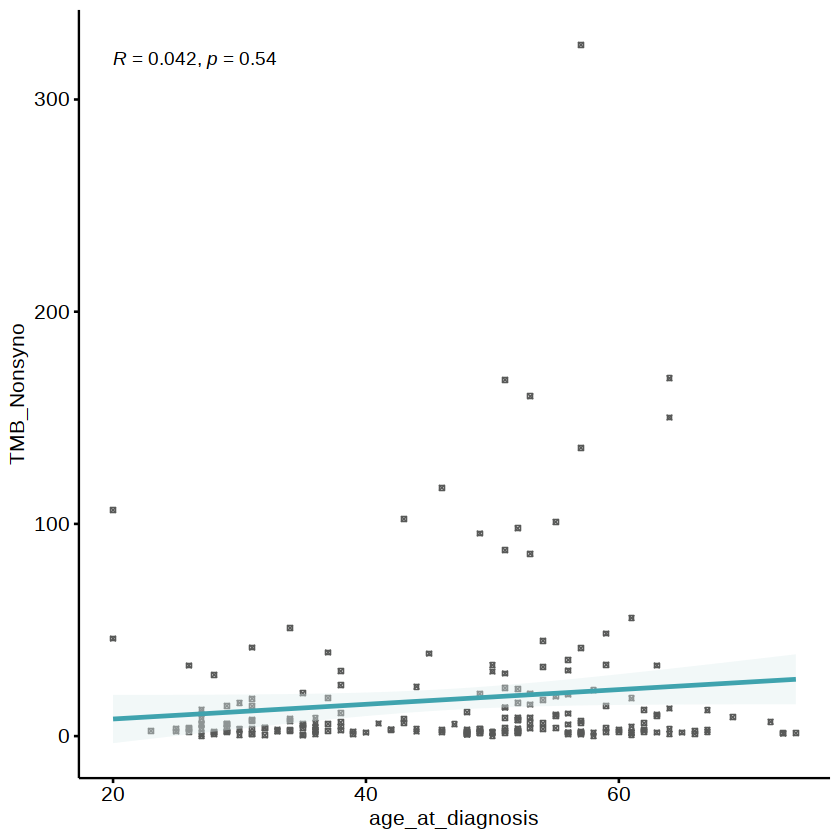

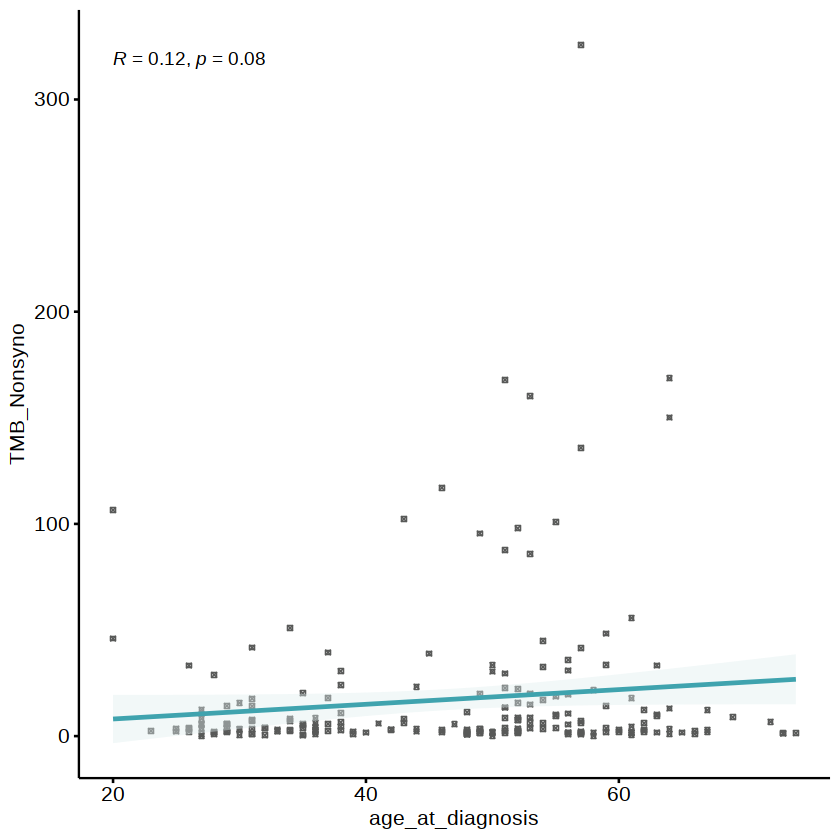

In [253]:
 p1 = ggscatter(common_Clin, x = "age_at_diagnosis", y = "TMB_Nonsyno", 
              add = "reg.line", conf.int = TRUE, 
              add.params = list(color = "#3fa3ae", fill = "#deeded"),
              shape = 7,size= 1,color ="#585958",
              cor.coef = TRUE, cor.method = "spearman")
p1
p2 = ggscatter(common_Clin, x = "age_at_diagnosis", y = "TMB_Nonsyno", 
              add = "reg.line", conf.int = TRUE, 
              add.params = list(color = "#3fa3ae", fill = "#deeded"),
              shape = 7,size= 1,color ="#585958",
              cor.coef = TRUE, cor.method = "pearson")
p2

In [254]:
ggsave(p1,filename = "Figure.2/TMB_spearman.pdf")
ggsave(p2,filename = "Figure.2/TMB_pearson.pdf")

Saving 6.67 x 6.67 in image

`geom_smooth()` using formula 'y ~ x'

Warning message:
“Removed 3 rows containing non-finite values (stat_smooth).”
Warning message:
“Removed 3 rows containing non-finite values (stat_cor).”
Warning message:
“Removed 3 rows containing missing values (geom_point).”
Saving 6.67 x 6.67 in image

`geom_smooth()` using formula 'y ~ x'

Warning message:
“Removed 3 rows containing non-finite values (stat_smooth).”
Warning message:
“Removed 3 rows containing non-finite values (stat_cor).”
Warning message:
“Removed 3 rows containing missing values (geom_point).”


### 2.4 Age Mutation/TMB logistic

In [309]:
common_nonsyn_maf =common_maf %>% filter(Variant_Classification %in% c("Missense_Mutation","Nonsense_Mutation","In_Frame_Ins","In_Frame_Del",
                                                                         "Frame_Shift_Ins","Frame_Shift_Del","Splice_Region"))

In [310]:
total_gene = unique(common_nonsyn_maf$Hugo_Symbol) 
total_sample = unique(common_nonsyn_maf$Tumor_Sample_Barcode)
common_nonsyn_matrix = matrix(0,nrow = length(total_sample),ncol=length(total_gene))
colnames(common_nonsyn_matrix)=total_gene
rownames(common_nonsyn_matrix)=total_sample
for (i in 1:length(total_sample)){
    sample_name = total_sample[i]
    sample_maf = common_nonsyn_maf %>% filter(Tumor_Sample_Barcode == sample_name)
    for (j in 1:length(total_gene)){
        gene_name = total_gene [j]
        if (gene_name %in% sample_maf$Hugo_Symbol){
            common_nonsyn_matrix[i,j] = 1
            }
    }
    }

In [312]:
head(common_nonsyn_matrix)
dim(common_nonsyn_matrix)

,ZBTB17,CROCC,HNRNPR,SLC30A2,RPS6KA1,EYA3,TXLNA,PHC2,ZMYM4,ERMAP,⋯,VAMP5,HIST1H3A,ZFP41,C9orf66,HRK,KRT14,LGALS7B,CNFN,PIH1D1,IFT27
FD_BY_004_C,1,1,1,1,1,1,1,1,1,1,⋯,0,0,0,0,0,0,0,0,0,0
FD_BY_005_C,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
FD_BY_006_C,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
FD_BY_007_C,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
FD_BY_008_C,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
FD_BY_009_C,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


[1]   215 18956

In [314]:
common_nonsyn_matrix = common_nonsyn_matrix[ common_clin_noAEH_noNAage_sort$Tumor_Sample_Barcode ,]

In [315]:
common_nonsyn_matrix_age = cbind(common_clin_noAEH_noNAage_sort$age_at_diagnosis,common_nonsyn_matrix)

In [317]:
colnames(common_nonsyn_matrix_age)[1] ="age_at_diagnosis"
common_nonsyn_matrix_age = as.data.frame(common_nonsyn_matrix_age)

In [318]:
logistic_df = data.frame()
for (i in 2:ncol(common_nonsyn_matrix_age)){
    gene_name = colnames(common_nonsyn_matrix_age)[i]
    common_gene_age = common_nonsyn_matrix_age[,c(1,i)]
    common_gene_age = as.data.frame(common_gene_age)
    colnames(common_gene_age)= c("age_at_diagnosis","gene")
    my_fit =glm(gene ~ age_at_diagnosis, family=binomial(link='logit'), data=common_gene_age)
    a = summary(my_fit)
    logistic_df = rbind(logistic_df,data.frame(
        gene = gene_name,
        mutation_count = colSums(common_nonsyn_matrix_age)[i],
        coef = a$coefficients["age_at_diagnosis",1],
        p =a$coefficients["age_at_diagnosis",4]))

}

Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm

In [319]:
write_tsv(logistic_df,file="total_215_age_logistic_total.tsv")

In [320]:
cgc = read_tsv("../../02.UCEC/Fig3/gene_level/cgc_gene_count.tsv")

Rows: 709 Columns: 29
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (18): gene, Cytoband, Name, Genome Location, Hallmark, Somatic, Germline...
dbl (11): C_amp_count, C_gain_count, C_del_count, C_loss_count, LN_amp_count...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [321]:
write_tsv(logistic_df %>% filter(p<0.05) %>% filter(gene %in% cgc$gene) %>% 
          arrange(-mutation_count),file="cgc_gene_total_age_logistic_total.tsv")

In [329]:
cgc_log = logistic_df %>% filter(p<0.05) %>% filter(gene %in% cgc$gene) %>% 
          arrange(-mutation_count)

In [337]:
cgc_log_plot = cgc_log %>% arrange(coef) %>% filter (mutation_count >20)

In [338]:
cgc_log_plot

,gene,mutation_count,coef,p
,<chr>,<dbl>,<dbl>,<dbl>
CTNNB1,CTNNB1,62,-0.06582055,1.022816e-06
CHD4,CHD4,43,0.02771965,4.698625e-02
ATM,ATM,41,0.02895808,4.230698e-02
APC,APC,34,0.03582865,2.248302e-02
FGFR2,FGFR2,26,0.03585868,4.158926e-02
TRRAP,TRRAP,43,0.03650607,1.082319e-02
ARID1A,ARID1A,106,0.03798903,7.766166e-04
TNC,TNC,26,0.03867249,2.950998e-02
NSD1,NSD1,32,0.03936465,1.571730e-02


In [325]:
predict_freq =data.frame(sample = rownames(common_nonsyn_matrix_age),age_at_diagnosis = common_nonsyn_matrix_age$age_at_diagnosis)

sample,age_at_diagnosis,predict,accurate
<chr>,<dbl>,<dbl>,<dbl>
TJ_E_011_C,20,0.09528947,1
TJ_L_010_C,20,0.09528947,1
FD_BY_075_C,23,0.10304670,0
FD_BY_020_C,25,0.10852417,0
FD_BY_036_C,25,0.10852417,0
FD_BY_024_C,26,0.11135769,0
FD_BY_038_C,26,0.11135769,0
FD_BY_102_C,26,0.11135769,1
TJ_L_011_C,26,0.11135769,1


In [358]:
for (i in 2:nrow(cgc_log_plot))
    {
    gene_name = rownames(cgc_log_plot)[i]
    common_gene_age = cbind(common_nonsyn_matrix_age[,1],common_nonsyn_matrix_age[,gene_name])
    common_gene_age = as.data.frame(common_gene_age)
    colnames(common_gene_age)= c("age_at_diagnosis","gene")
    my_fit =glm(gene ~ age_at_diagnosis, family=binomial(link='logit'), data=common_gene_age)
    predict_freq$predict <- predict(my_fit, newdata = predict_freq, type = "response")
    predict_freq$accurate = common_gene_age$gene
    
    my_gene_plot = ggplot(predict_freq,aes(x=age_at_diagnosis))+
                    geom_smooth(aes(y=predict),color = "#d18466")+
                    geom_point(aes(y=accurate))+
                    theme_bw()+
                    labs(x="age at diagnosis(years)",
                        y =paste0("Probability of\n",gene_name," mutation"))+
                    theme(plot.title = element_text(hjust=0.5,face="bold", size=15),
                          strip.text = element_blank(),
                          panel.spacing = unit(0, "cm"),
                          axis.title.x=element_text(vjust=2, size=15,face = "bold"),
                          axis.title.y=element_text(vjust=2, size=15,face = "bold"),
                          axis.text.x = element_text(size = 12, vjust = 1,color="black"),
                          axis.ticks.x.top = element_line(color = "black", size = .5),
                          axis.ticks.length = unit(-0.2, "cm"),
                          axis.ticks.y = element_line(color = "black", size = .5),
                          axis.text.y = element_text(size = 10,color="black"),
                          panel.grid = element_blank())+
                    annotate("text",label=paste0("p=",cgc_log_plot$p[i]),x=50,y=0.95,size = 7,fontface="bold")
     ggsave(my_gene_plot,file=paste0("Figure.2/cgc_gene_logistic/",gene_name,"_logistic.pdf"))
                     }
        

Saving 6.67 x 6.67 in image

`geom_smooth()` using method = 'loess' and formula 'y ~ x'

Saving 6.67 x 6.67 in image

`geom_smooth()` using method = 'loess' and formula 'y ~ x'

Saving 6.67 x 6.67 in image

`geom_smooth()` using method = 'loess' and formula 'y ~ x'

Saving 6.67 x 6.67 in image

`geom_smooth()` using method = 'loess' and formula 'y ~ x'

Saving 6.67 x 6.67 in image

`geom_smooth()` using method = 'loess' and formula 'y ~ x'

Saving 6.67 x 6.67 in image

`geom_smooth()` using method = 'loess' and formula 'y ~ x'

Saving 6.67 x 6.67 in image

`geom_smooth()` using method = 'loess' and formula 'y ~ x'

Saving 6.67 x 6.67 in image

`geom_smooth()` using method = 'loess' and formula 'y ~ x'

Saving 6.67 x 6.67 in image

`geom_smooth()` using method = 'loess' and formula 'y ~ x'

Saving 6.67 x 6.67 in image

`geom_smooth()` using method = 'loess' and formula 'y ~ x'

Saving 6.67 x 6.67 in image

`geom_smooth()` using method = 'loess' and formula 'y ~ x'

Saving 6.67 x 6.67 in

In [360]:
for (i in 1:1)
    {
    gene_name = rownames(cgc_log_plot)[i]
    common_gene_age = cbind(common_nonsyn_matrix_age[,1],common_nonsyn_matrix_age[,gene_name])
    common_gene_age = as.data.frame(common_gene_age)
    colnames(common_gene_age)= c("age_at_diagnosis","gene")
    my_fit =glm(gene ~ age_at_diagnosis, family=binomial(link='logit'), data=common_gene_age)
    predict_freq$predict <- predict(my_fit, newdata = predict_freq, type = "response")
    predict_freq$accurate = common_gene_age$gene
    
    my_gene_plot = ggplot(predict_freq,aes(x=age_at_diagnosis))+
                    geom_smooth(aes(y=predict),color = "#62abb5")+
                    geom_point(aes(y=accurate))+
                    theme_bw()+
                    labs(x="age at diagnosis(years)",
                        y =paste0("Probability of\n",gene_name," mutation"))+
                    theme(plot.title = element_text(hjust=0.5,face="bold", size=15),
                          strip.text = element_blank(),
                          panel.spacing = unit(0, "cm"),
                          axis.title.x=element_text(vjust=2, size=15,face = "bold"),
                          axis.title.y=element_text(vjust=2, size=15,face = "bold"),
                          axis.text.x = element_text(size = 12, vjust = 1,color="black"),
                          axis.ticks.x.top = element_line(color = "black", size = .5),
                          axis.ticks.length = unit(-0.2, "cm"),
                          axis.ticks.y = element_line(color = "black", size = .5),
                          axis.text.y = element_text(size = 10,color="black"),
                          panel.grid = element_blank())+
                    annotate("text",label=paste0("p=",cgc_log_plot$p[i]),x=50,y=0.95,size = 7,fontface="bold")
     ggsave(my_gene_plot,file=paste0("Figure.2/cgc_gene_logistic/",gene_name,"_logistic.pdf"))
                     }
        

Saving 6.67 x 6.67 in image

`geom_smooth()` using method = 'loess' and formula 'y ~ x'



## 3 Baoyu 

In [287]:
load("../../02.UCEC/Fig2/data/BY_intensive_clin.RDa")

In [288]:
SBS_BY_compare_plot = as.data.frame(t(mt_sig$Exposure.norm))
SBS_BY_compare_plot = SBS_BY_compare_plot[ noNA_merge_xlsx_BY_Clin$Tumor_Sample_Barcode,]
SBS_BY_compare_plot = cbind(noNA_merge_xlsx_BY_Clin$ insensitive_two_group,SBS_BY_compare_plot)
colnames(SBS_BY_compare_plot)[1] ="insensitive_group"
SBS_BY_compare_plot$sample = rownames(SBS_BY_compare_plot)

In [289]:
SBS_BY_compare_plot_long = melt(SBS_BY_compare_plot,
                  id.vars=c("sample","insensitive_group"),
                  variable.name="Exposure.norm",
                  value.name="signature"
                  ) %>%
                arrange(sample)
colnames(SBS_BY_compare_plot_long)[c(3,4)]=c("signature","Exposure.norm")

In [290]:
SBS_BY_compare_plot_long$insensitive_group = factor(SBS_BY_compare_plot_long$insensitive_group, levels=c("Sensitive","Insensitive"))

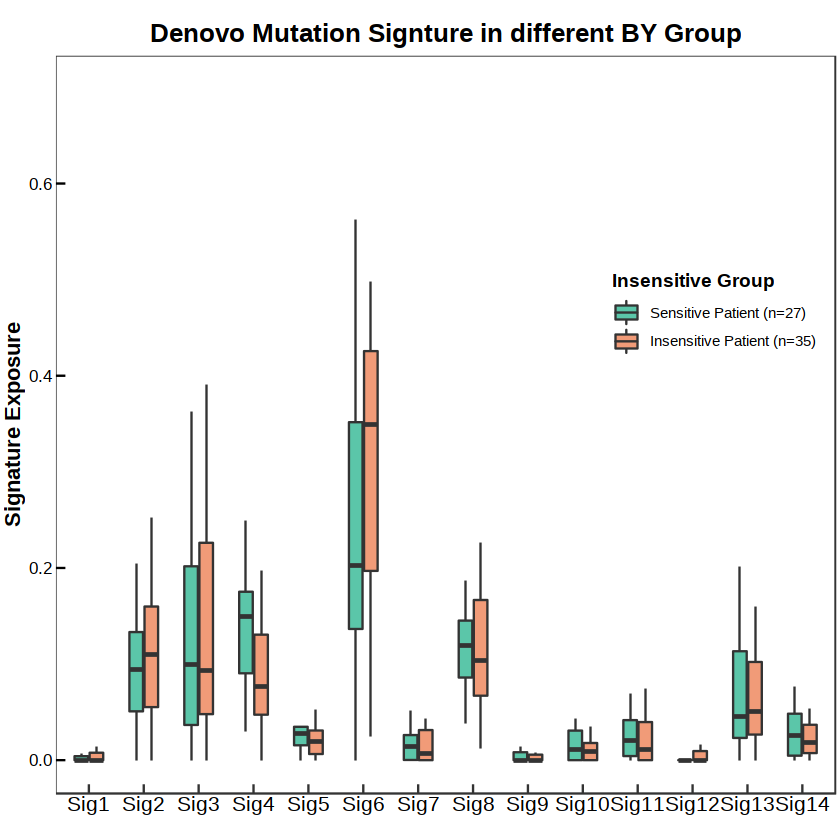

In [294]:
p1_BY_newcol = SBS_BY_compare_plot_long %>% 
ggplot( aes(x=signature , y=Exposure.norm,fill=insensitive_group))+
#stat_boxplot(geom ="errorbar", width = .3, size=.7,  coef = 0.4)+
geom_boxplot(width = .55, outlier.shape = NA,  coef = 1)+
scale_fill_manual(values =  c("#5bc6a9","#f19b78"),
                 labels=c("Sensitive Patient (n=27)    ",
                               "Insensitive Patient (n=35)    "),
                 name = "Insensitive Group")+
theme_bw()+
theme(legend.title = element_text(face="bold"),
      legend.position = c(.85, .65),
      plot.title = element_text(hjust=0.5,face="bold", size=15),
        strip.text = element_blank(),
        panel.spacing = unit(0, "cm"),
        axis.title.x = element_blank(),
          axis.title.y = element_text(face="bold", size=13),
        axis.text.x = element_text(size = 12, vjust = 1,color="black"),
        axis.ticks.x.top = element_line(color = "black", size = .5),
        axis.ticks.length = unit(-0.2, "cm"),
        axis.ticks.y = element_line(color = "black", size = .5),
        axis.text.y = element_text(size = 10,color="black"),
        #legend.position = "none",
        panel.grid = element_blank(),
        plot.margin=unit(c(0.5,0.1,0.5,0.1),"cm"))+
labs(y="Signature Exposure"
    ,title = "Denovo Mutation Signture in different BY Group")
p1_BY_newcol

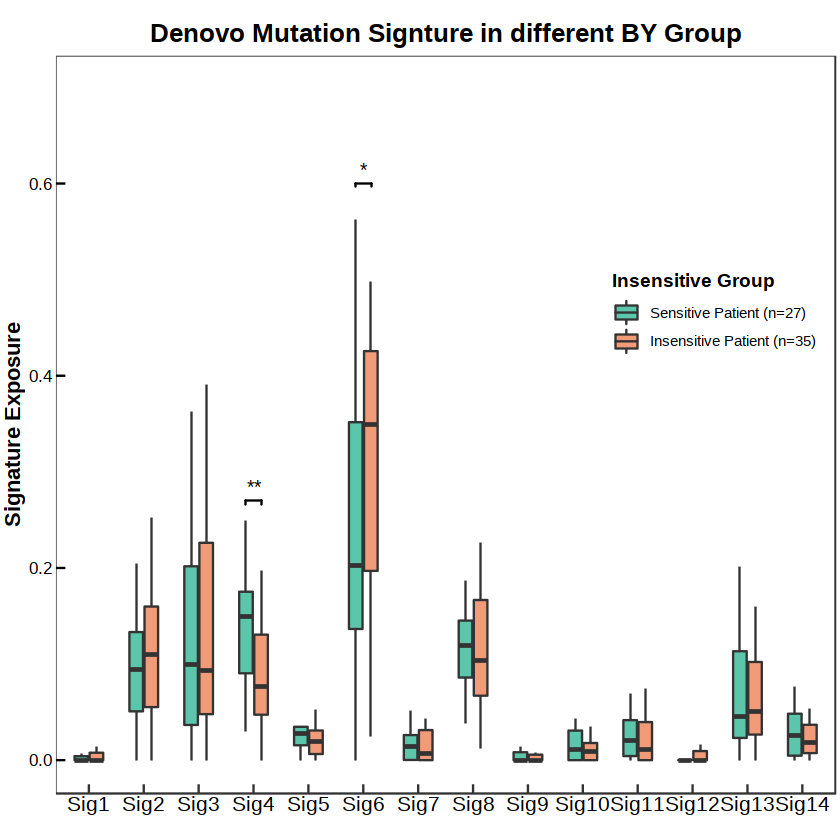

In [306]:
## prepare low_high_t_signif_input 
t_BY_df = data.frame()
for (i in 1:14) {
    sig = paste0("Sig",i)
    t_input = SBS_BY_compare_plot_long %>% 
                filter(signature ==sig)
    t = t.test(Exposure.norm~insensitive_group,data=t_input)
    t_BY_df = rbind(t_BY_df, data.frame(
        Sig = sig,
        test_method = t$method,
        p_value = t$p.value))
    }
t_BY_df = t_BY_df[t_BY_df$p_value <0.06,]

t_BY_df$x = as.numeric(rownames(t_BY_df))
t_BY_df$xmin = t_BY_df$x - 0.15
t_BY_df$xmax = t_BY_df$x + 0.15
t_BY_df$y_position = c(0.27,0.6)
t_BY_df$signif = p2star(t_BY_df$p_value)
#2样本t检验，多样本kw检验
p1_BY_withtest = 
p1_BY_newcol + 
    geom_signif(
    xmin = t_BY_df$xmin, xmax = t_BY_df$xmax, y_position = t_BY_df$y_position, 
    annotations =t_BY_df$signif, tip_length = 0.005
    )
p1_BY_withtest

In [307]:
ggsave(p1_BY_withtest,file="Figure.X.BY_sensitive_denovo_signature_diff.pdf")

Saving 6.67 x 6.67 in image



## 4.Figure.5(Pathway)

Pathway,N,n_affected_genes,fraction_affected,Mutated_samples,Fraction_mutated_samples
<chr>,<int>,<int>,<dbl>,<int>,<dbl>
NRF2,3,3,1.0000000,5,0.06329114
TP53,6,5,0.8333333,14,0.17721519
TGF-Beta,7,6,0.8571429,9,0.11392405
Cell_Cycle,15,9,0.6000000,13,0.16455696
MYC,13,12,0.9230769,18,0.22784810
PI3K,29,22,0.7586207,65,0.82278481
Hippo,38,31,0.8157895,47,0.59493671
NOTCH,71,53,0.7464789,46,0.58227848
WNT,68,53,0.7794118,62,0.78481013


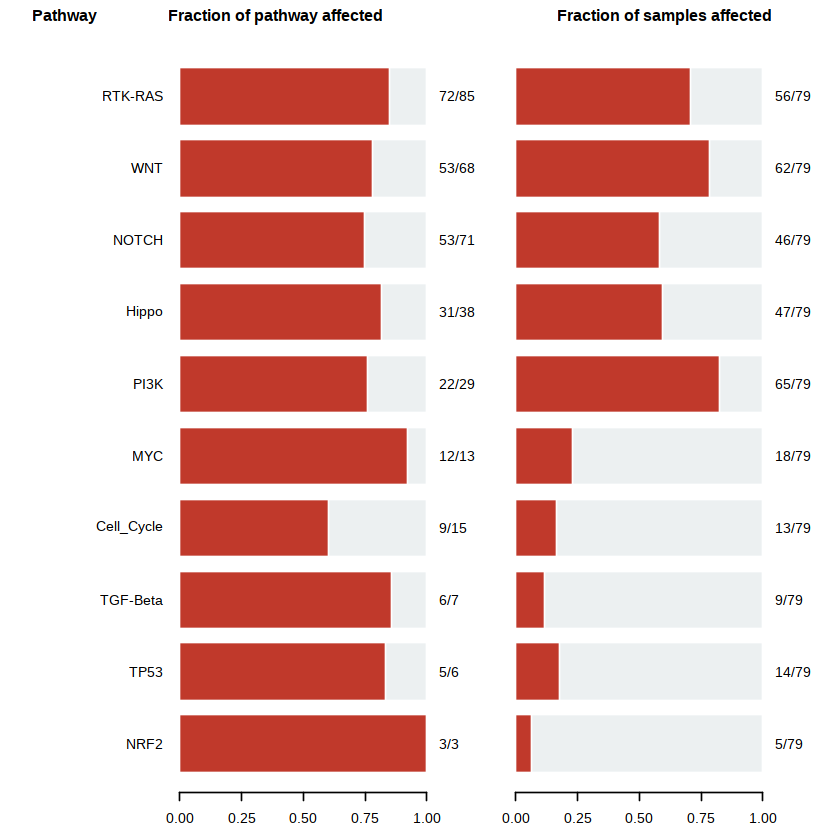

In [181]:
OncogenicPathways(maf = common_early_laml)

Pathway,N,n_affected_genes,fraction_affected,Mutated_samples,Fraction_mutated_samples
<chr>,<int>,<int>,<dbl>,<int>,<dbl>
NRF2,3,3,1.0000000,19,0.1397059
TP53,6,6,1.0000000,46,0.3382353
TGF-Beta,7,7,1.0000000,29,0.2132353
MYC,13,12,0.9230769,53,0.3897059
Cell_Cycle,15,14,0.9333333,41,0.3014706
PI3K,29,28,0.9655172,111,0.8161765
Hippo,38,37,0.9736842,86,0.6323529
NOTCH,71,66,0.9295775,92,0.6764706
WNT,68,68,1.0000000,101,0.7426471


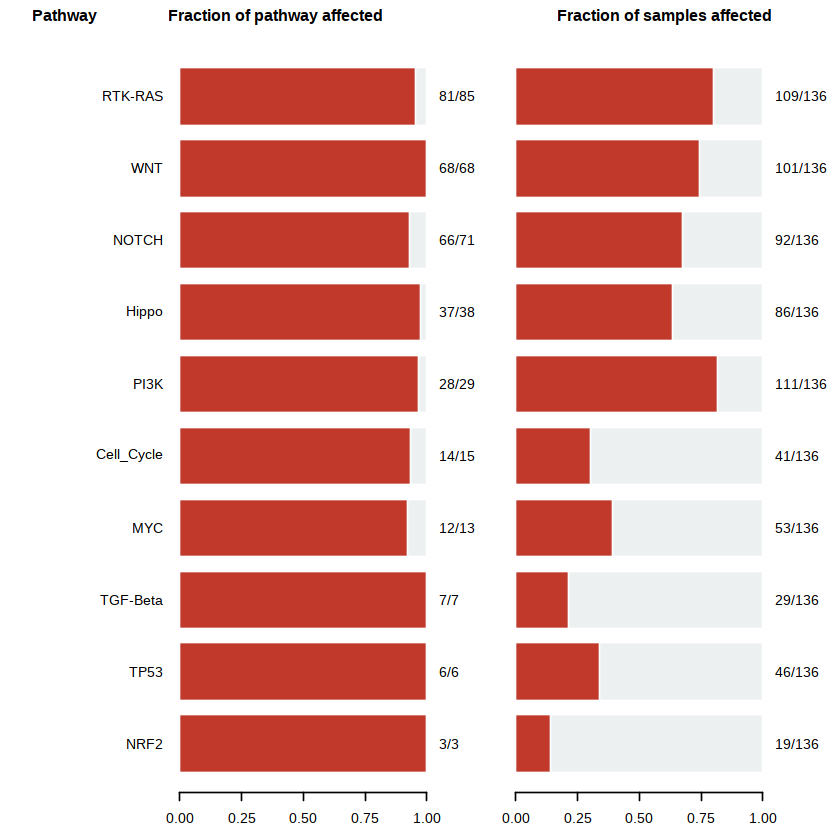

In [182]:
OncogenicPathways(maf = common_old_laml)

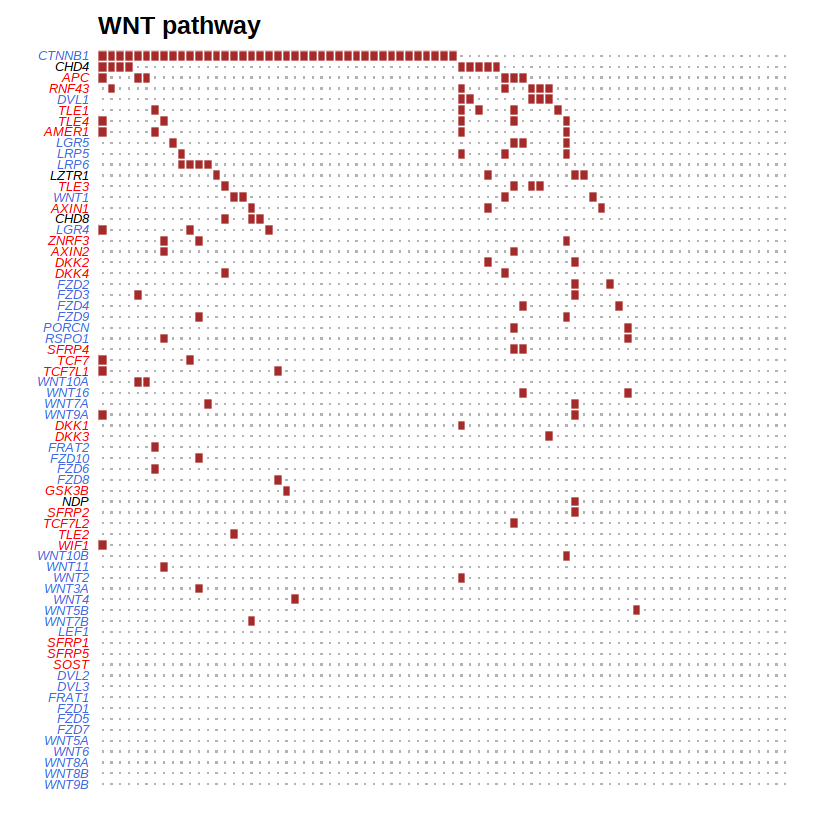

In [184]:
PlotOncogenicPathways(maf = common_early_laml, pathways = "WNT",
                     removeNonMutated = FALSE,fullPathway =TRUE)

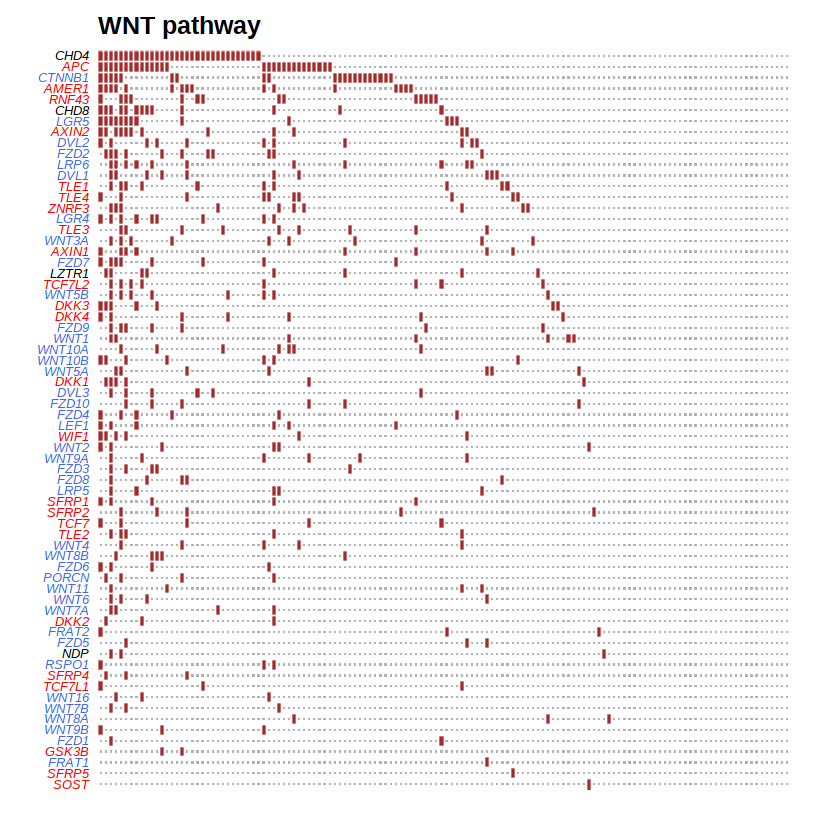

In [183]:
PlotOncogenicPathways(maf = common_old_laml, pathways = "WNT",
                     removeNonMutated = FALSE,fullPathway =TRUE)

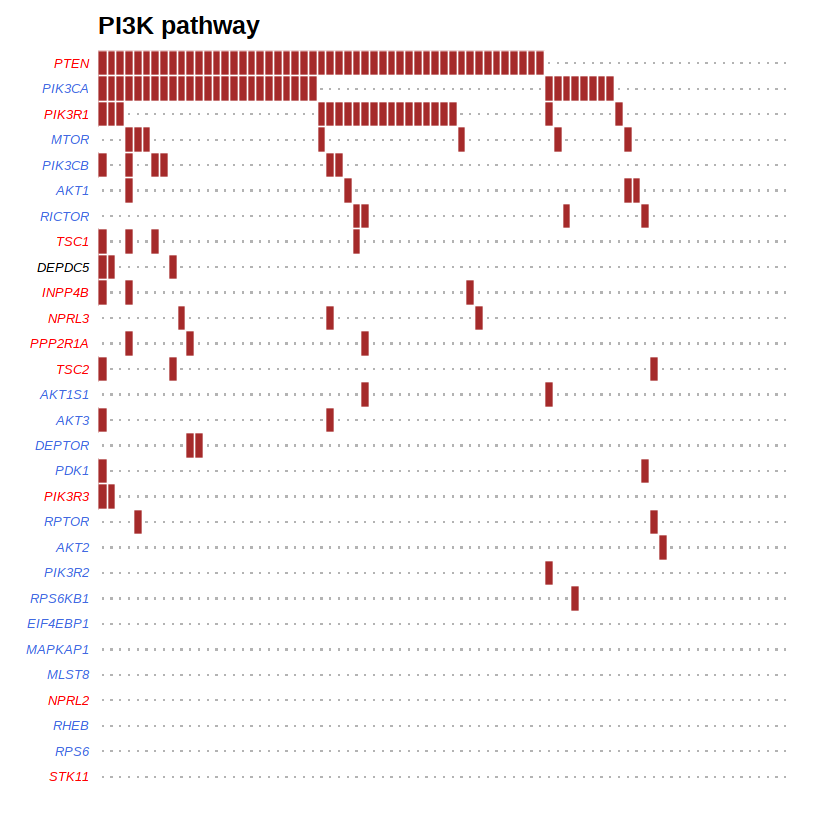

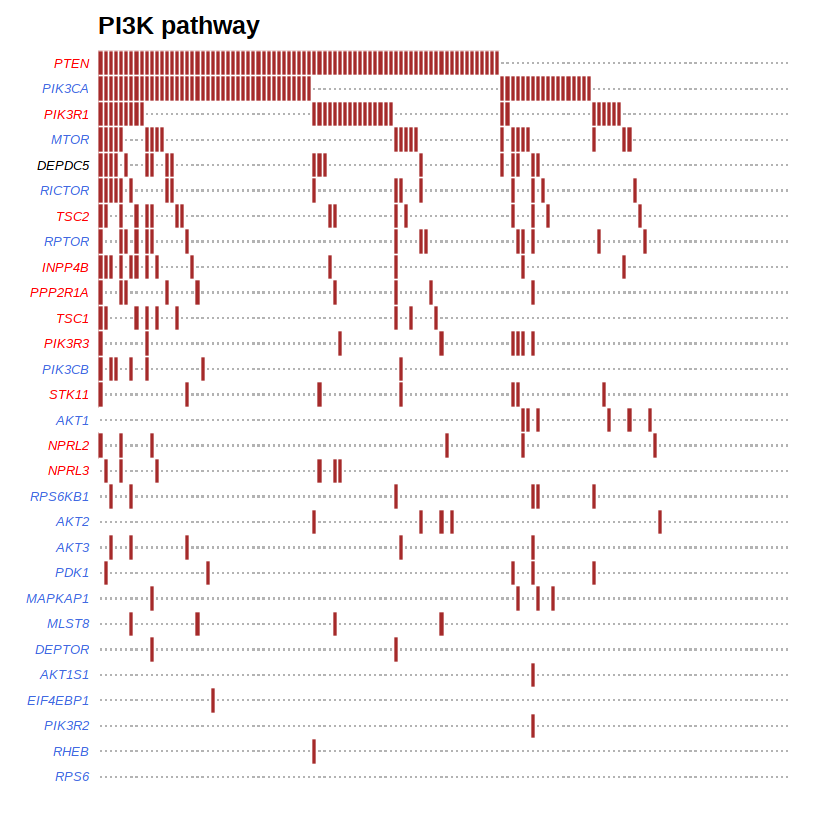

In [185]:
PlotOncogenicPathways(maf = common_early_laml, pathways = "PI3K",
                     removeNonMutated = FALSE,fullPathway =TRUE)
PlotOncogenicPathways(maf = common_old_laml, pathways = "PI3K",
                     removeNonMutated = FALSE,fullPathway =TRUE)

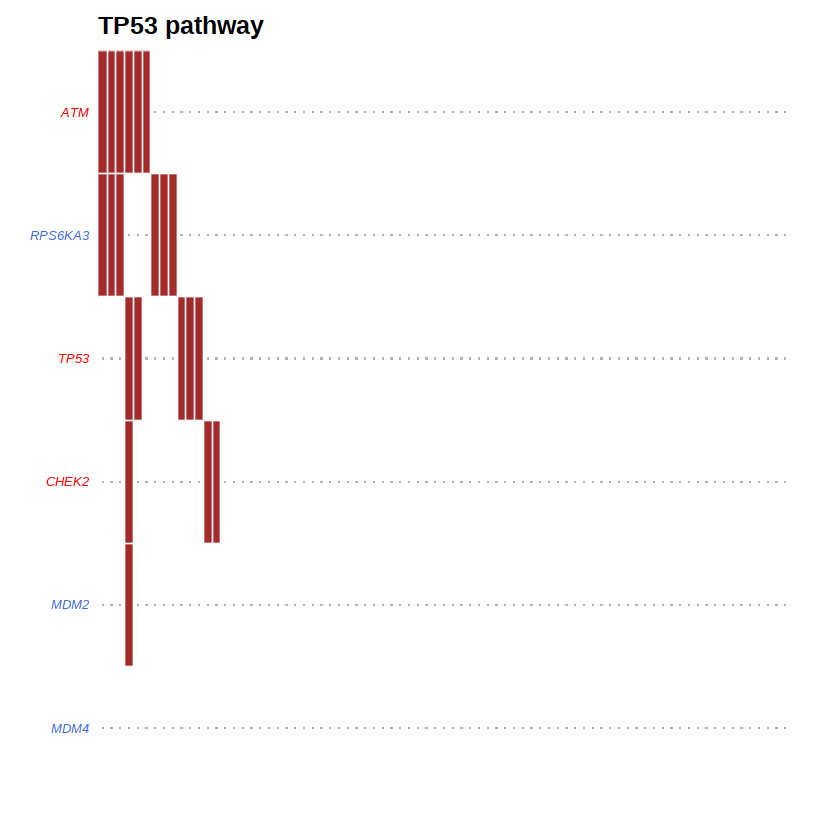

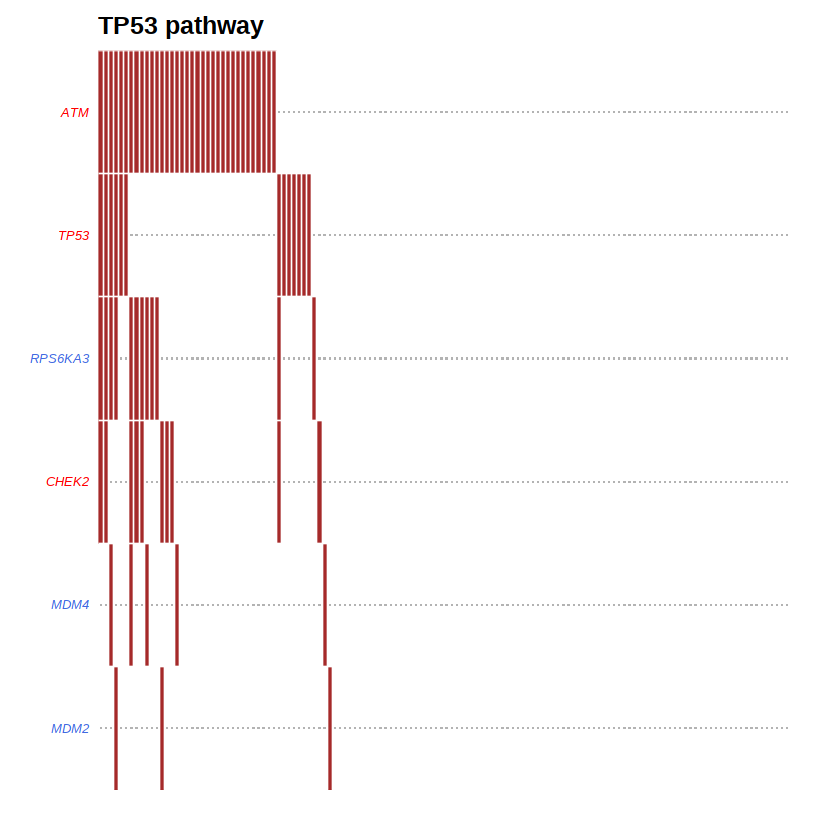

In [186]:
PlotOncogenicPathways(maf = common_early_laml, pathways = "TP53",
                     removeNonMutated = FALSE,fullPathway =TRUE)
PlotOncogenicPathways(maf = common_old_laml, pathways = "TP53",
                     removeNonMutated = FALSE,fullPathway =TRUE)

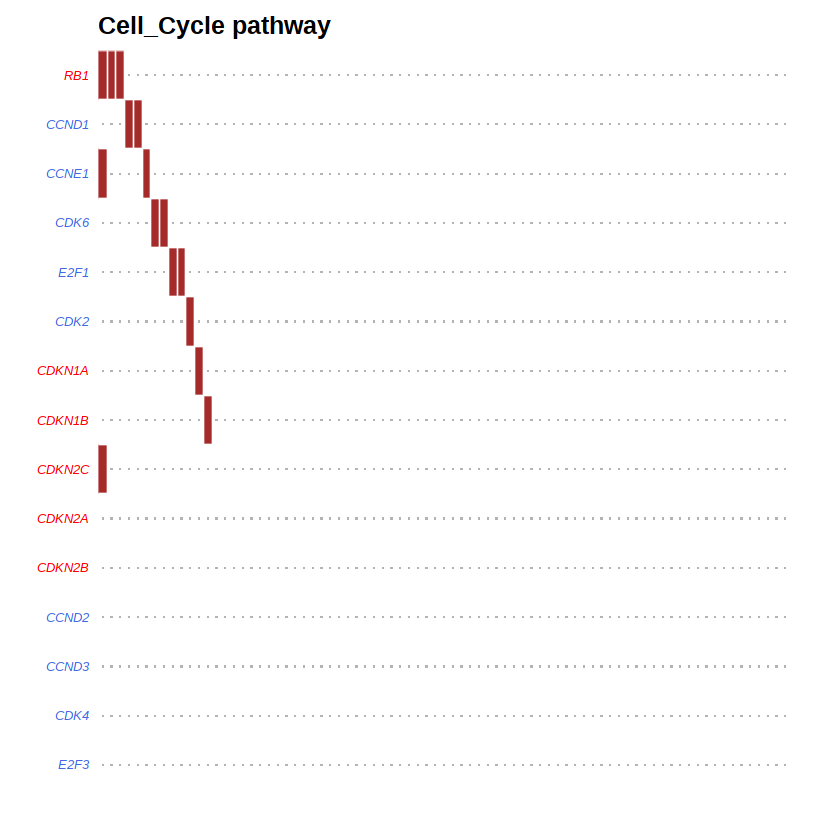

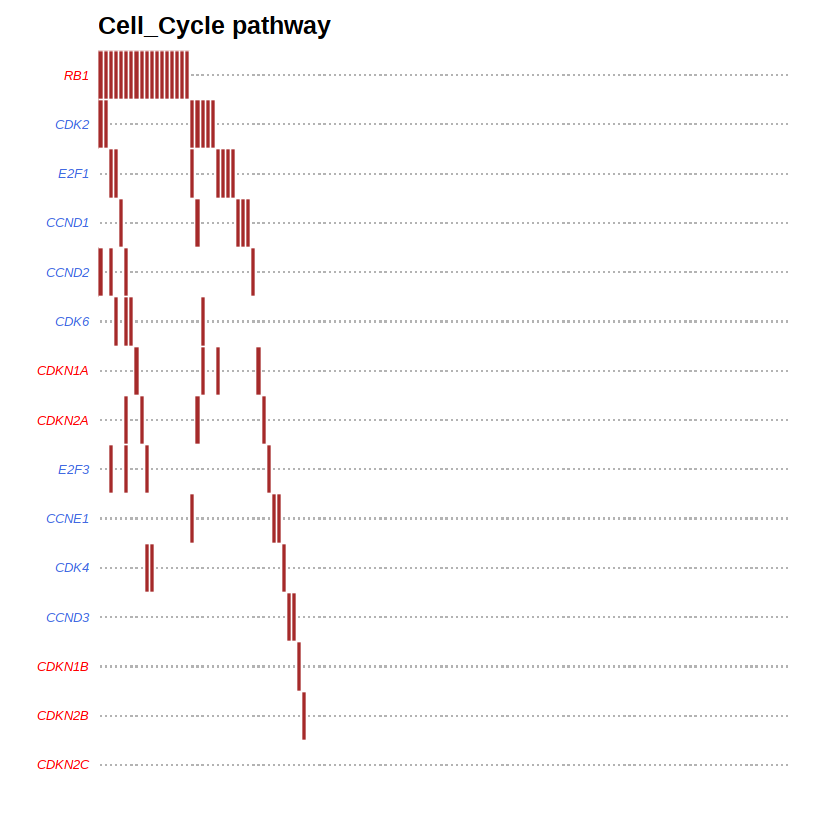

In [187]:
PlotOncogenicPathways(maf = common_early_laml, pathways = "Cell_Cycle",
                     removeNonMutated = FALSE,fullPathway =TRUE)
PlotOncogenicPathways(maf = common_old_laml, pathways = "Cell_Cycle",
                     removeNonMutated = FALSE,fullPathway =TRUE)

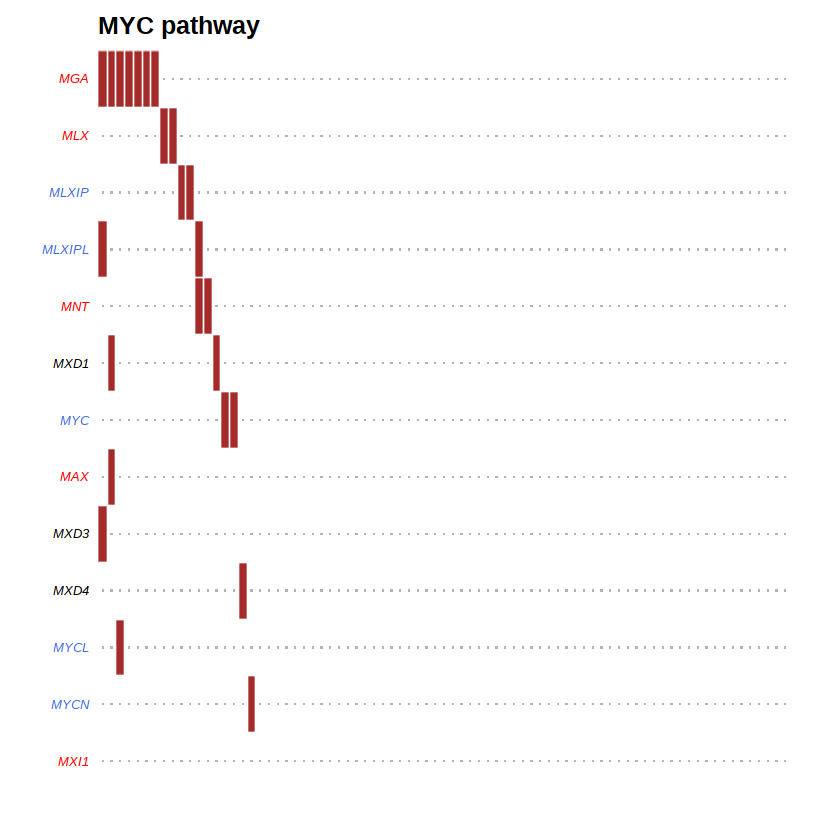

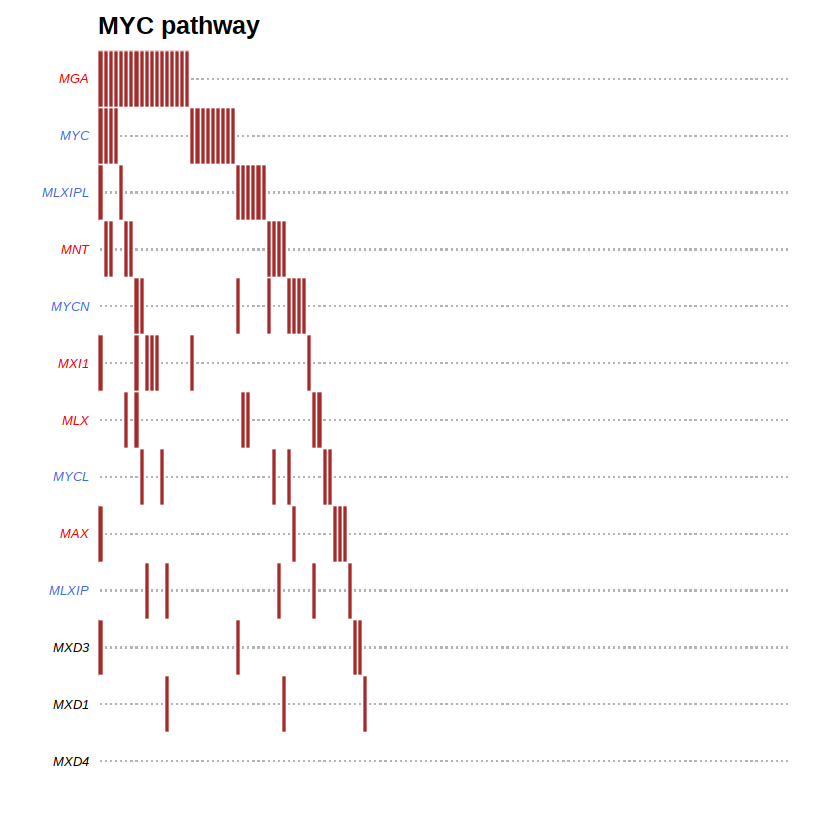

In [188]:
PlotOncogenicPathways(maf = common_early_laml, pathways = "MYC",
                     removeNonMutated = FALSE,fullPathway =TRUE)
PlotOncogenicPathways(maf = common_old_laml, pathways = "MYC",
                     removeNonMutated = FALSE,fullPathway =TRUE)

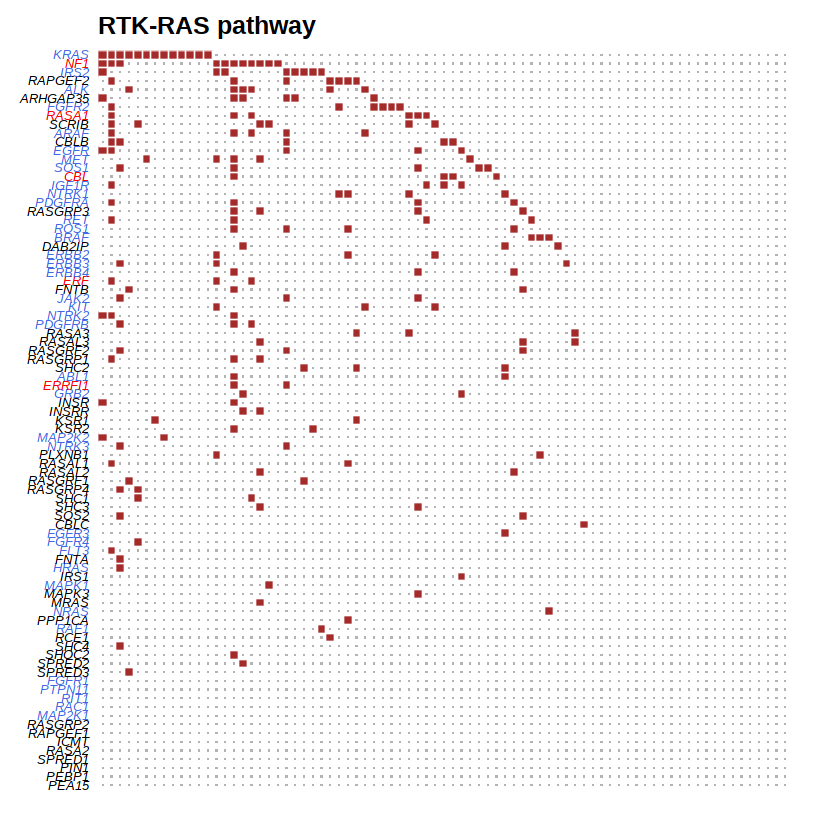

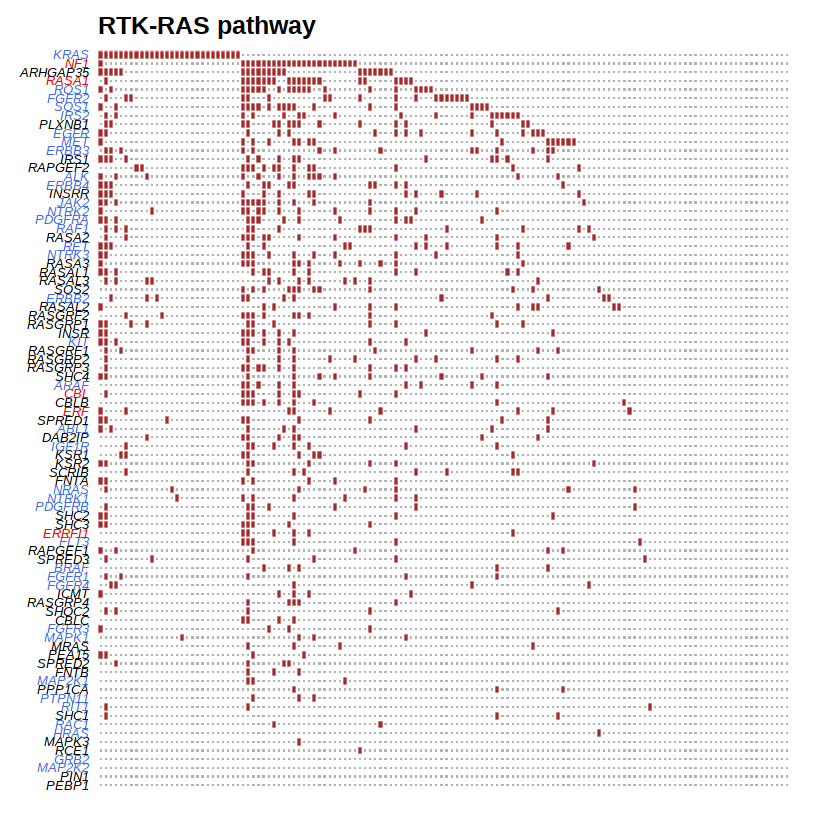

In [189]:
PlotOncogenicPathways(maf = common_early_laml, pathways = "RTK-RAS",
                     removeNonMutated = FALSE,fullPathway =TRUE)
PlotOncogenicPathways(maf = common_old_laml, pathways = "RTK-RAS",
                     removeNonMutated = FALSE,fullPathway =TRUE)

## 6.germline

### 6.1 load KCPG list

In [363]:
kcpg_list = read_xlsx("../../02.UCEC/Fig2/germline/NC_KCPG_list.xlsx")

New names:
* `` -> ...2
* `` -> ...3
* `` -> ...4
* `` -> ...5
* `` -> ...6



In [365]:
normal_germ = read_tsv("../../02.UCEC/Fig2/data//normal_germ_final.txt")

New names:
* `` -> ...13

Rows: 966 Columns: 18
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (15): sample, patient, Chr, Ref, Alt, Func.refGene, Gene.refGene, GeneDe...
dbl  (3): Start, End, avsnp

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [382]:
normal_germ_clin  = merge(normal_germ[,c(1:9,18)],
                          common_clin_noAEH_noNAage_sort[,c("patient","Tumor_Sample_Barcode","age_group","age_at_diagnosis","clinical_stage","Subtype","BMI")],
                          by="patient")

In [364]:
colnames(kcpg_list) = kcpg_list[2,]
kcpg_list = kcpg_list[3:206,]

In [366]:
known_kcpg_list = kcpg_list %>% filter(Gene_Classification != "Not Classified")

In [407]:
normal_germ_clin_kcpg = normal_germ_clin %>% filter(Gene.refGene %in% c(known_kcpg_list$`Gene  Symbol`,"RAD50"))

In [ ]:
normal_germ_clin_kcpg

In [408]:
normal_germ_clin_kcpg %>% filter(clinical_stage =="IA")%>% group_by(age_group) %>% summarise(n())

age_group,n()
<fct>,<int>
Early,20
Old,4


In [524]:
normal_germ_clin_kcpg %>% filter(clinical_stage !="IA")%>% group_by(age_group) %>% summarise(n())

age_group,n()
<fct>,<int>
Early,2
Old,19


In [526]:
old_germ =normal_germ_clin_kcpg %>% filter(age_group == "Old")

In [532]:
early_germ =normal_germ_clin_kcpg %>% filter(age_group == "Early")

In [533]:
length(unique(old_germ$patient))
length(unique(early_germ$patient))

[1] 19

[1] 19

In [534]:
k = data.frame(c1=c(19,60),c2=c(19,117))

In [538]:
t(k)

c1,19,60
c2,19,117


In [537]:
chisq.test(t(k))


	Pearson's Chi-squared test with Yates' continuity correction

data:  t(k)
X-squared = 2.8312, df = 1, p-value = 0.09245


In [ ]:
normal_germ_clin_kcpg

In [409]:
write_tsv(normal_germ_clin_kcpg,file="total_kcpg_germ_list.tsv")

#### 6.2 for total

In [509]:
common_clin_noAEH_noNAage_sort_germ = common_clin_noAEH_noNAage_sort
common_clin_noAEH_noNAage_sort_germ  = as.data.frame(common_clin_noAEH_noNAage_sort_germ)
common_clin_noAEH_noNAage_sort_germ$germ = "None"
rownames(common_clin_noAEH_noNAage_sort_germ) = common_clin_noAEH_noNAage_sort_germ$Tumor_Sample_Barcode

In [510]:
for (i in 1:nrow(normal_germ_clin_kcpg)){
    common_clin_noAEH_noNAage_sort_germ[normal_germ_clin_kcpg$Tumor_Sample_Barcode[i],"germ"] = normal_germ_clin_kcpg$Gene.refGene[i]
    } 

In [511]:
common_clin_noAEH_noNAage_sort_germ$age_at_diagnosis_na  = common_clin_noAEH_noNAage_sort_germ$age_at_diagnosis
common_clin_noAEH_noNAage_sort_germ[ common_clin_noAEH_noNAage_sort_germ$germ =="None","age_at_diagnosis_na"] = NA

In [512]:
common_clin_noAEH_noNAage_sort_germ = common_clin_noAEH_noNAage_sort_germ%>%
  mutate(order_patient = fct_reorder(patient,age_at_diagnosis))

In [520]:
common_clin_noAEH_noNAage_sort_germ %>% filter(age_at_diagnosis > 40) %>% filter(germ !="None") %>% select(patient,age_at_diagnosis,germ,Subtype,)

,patient,age_at_diagnosis,germ,Subtype
,<chr>,<dbl>,<chr>,<chr>
FD_L_030_C,FD_L_030,44,SBDS,MSI_hypermutated
FD_L_068_C,FD_L_068,48,PTEN,CN low
TJ_L_004_C,TJ_L_004,49,ATM,CN high
FD_L_044_C,FD_L_044,51,PTEN,CN low
TJ_E_021_C,TJ_E_021,51,WRN,CN low
TJ_E_042_C,TJ_E_042,52,RAD50,CN low
FD_L_032_C,FD_L_032,53,MUTYH,POLE_ultramutated
FD_L_077_C,FD_L_077,53,TSC2,MSI_hypermutated
FD_E_009_C,FD_E_009,54,NF1,MSI_hypermutated


Warning message:
“Removed 177 rows containing missing values (geom_point).”


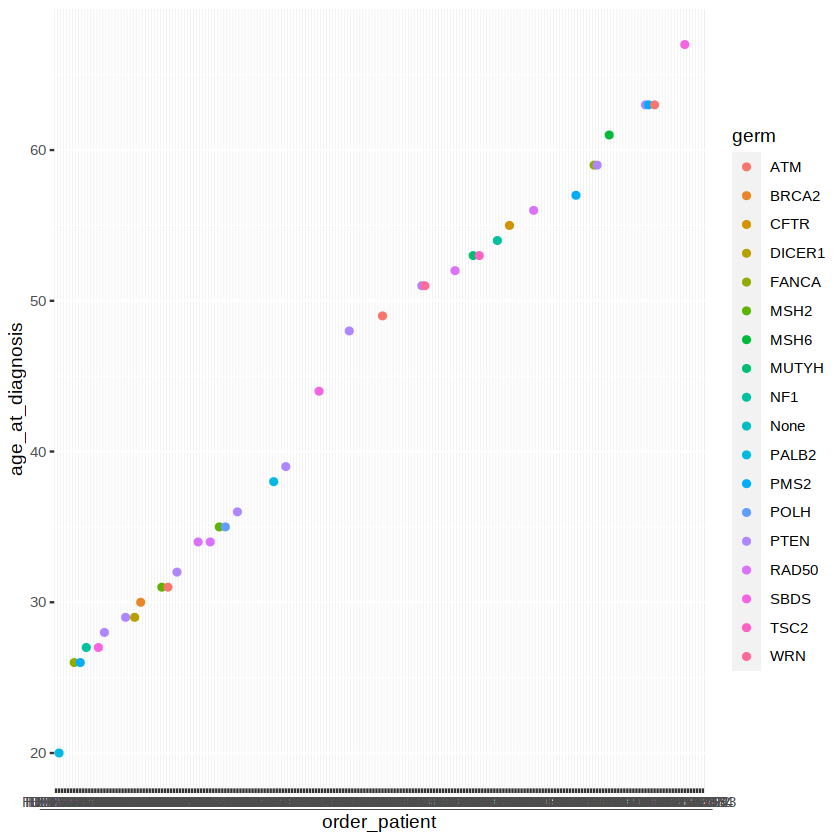

In [513]:
ggplot(common_clin_noAEH_noNAage_sort_germ,aes(x = order_patient,
                y=age_at_diagnosis,color = germ))+
geom_point(aes(y= age_at_diagnosis_na))

Warning message:
“Removed 177 rows containing missing values (geom_point).”
Warning message:
“Removed 4 rows containing missing values (geom_segment).”


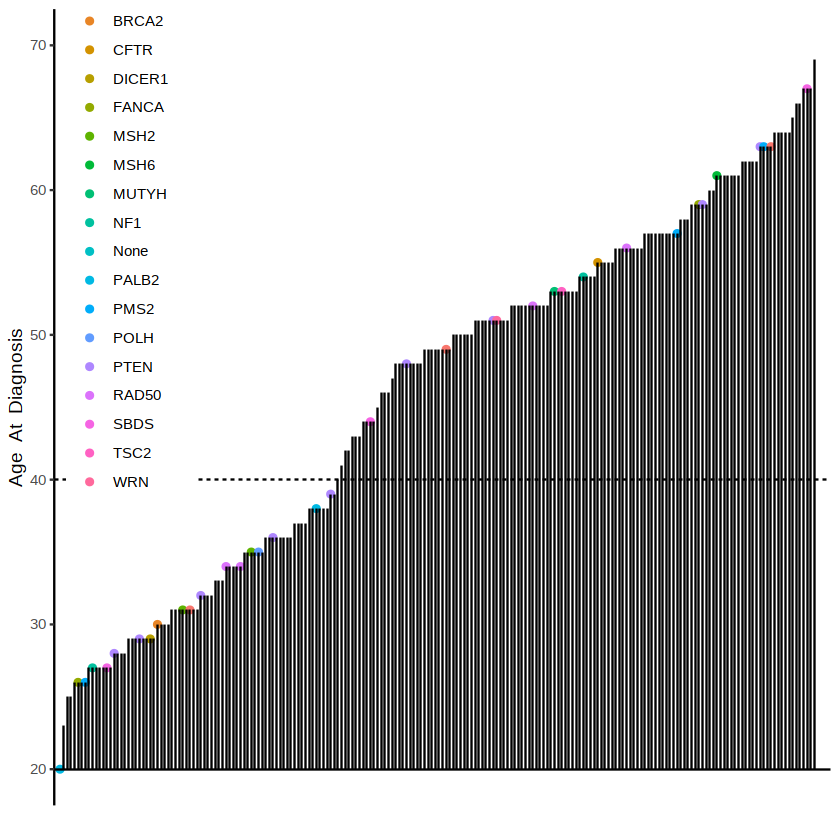

In [515]:
ggplot(common_clin_noAEH_noNAage_sort_germ,aes(x = order_patient,
                y=age_at_diagnosis))+
  geom_point(aes(y= age_at_diagnosis_na,color = germ))+
  geom_segment(aes(x=reorder(patient,age_at_diagnosis),xend=reorder(patient,age_at_diagnosis),
                   y=20,yend=age_at_diagnosis))+
  theme_bw()+
  labs(x="",
      y = "Age  At  Diagnosis",
      color = "Germline PTV")+
  geom_hline(yintercept = 40,linetype="dashed")+
  scale_y_continuous(limits = c(20, 70))+
theme(legend.position = c(0.10,0.73),
  panel.grid =element_blank()) +   ## 删去网格线
  theme(axis.text.x = element_blank()) +   ## 删去刻度标签
  theme(axis.ticks.x = element_blank()) +   ## 删去刻度线
  theme(panel.border = element_blank()) +   ## 删去外层边框
  theme(axis.line.y = element_line(size=0.5, colour = "black"))+## 再加上坐标轴（无刻度、无标签）
  geom_hline(yintercept = 20)

#### 6.3 for IA

In [411]:
plot_gene = unique(normal_germ_clin_kcpg$Gene.refGene)

In [481]:
normal_germ_clin_kcpg %>% filter(`Gene.refGene` =="WRN")

patient,sample,Chr,Start,End,Ref,Alt,Func.refGene,Gene.refGene,clinvar,Tumor_Sample_Barcode,age_group,age_at_diagnosis,clinical_stage,Subtype,BMI
<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<fct>,<dbl>,<chr>,<chr>,<dbl>
TJ_E_021,TJ_E_021_N,8,31004588,31004588,-,A,exonic,WRN,Pathogenic,TJ_E_021_C,Old,51,II,CN low,28.93407


In [482]:
plot_gene

[1] "PTEN"   "MSH6"   "RAD50"  "NF1"    "BRCA2"  "MSH2"   "PTCH1"  "FANCA" 
 [9] "PALB2"  "ATM"    "DICER1" "SBDS"   "POLH"   "CFTR"   "MUTYH"  "APC"   
[17] "TSC2"   "WRN"    "PMS2"

In [483]:
common_clin_noAEH_noNAage_sort_IA = common_clin_noAEH_noNAage_sort %>%filter(clinical_stage =="IA")

In [484]:
dim(common_clin_noAEH_noNAage_sort_IA)

[1] 108  89

In [485]:
common_clin_noAEH_noNAage_sort_IA$germ = "None"

In [486]:
normal_germ_clin_kcpg_IA = normal_germ_clin_kcpg %>% filter(clinical_stage =="IA")

In [474]:
#normal_germ_clin_kcpg_IA = normal_germ_clin_kcpg_IA[c(1:2,4:8,10:19,22:24),]

In [487]:
common_clin_noAEH_noNAage_sort_IA = as.data.frame(common_clin_noAEH_noNAage_sort_IA)

In [488]:
table(normal_germ_clin_kcpg_IA$patient)


FD_BY_005 FD_BY_006 FD_BY_008 FD_BY_009 FD_BY_017 FD_BY_032 FD_BY_034 FD_BY_037 
        1         2         1         1         1         1         1         2 
FD_BY_038 FD_BY_043 FD_BY_065 FD_BY_070 FD_BY_072 FD_BY_083 FD_BY_091 FD_BY_096 
        1         1         1         1         1         1         1         1 
FD_BY_100  FD_E_009  TJ_E_029  TJ_E_042 
        2         2         1         1 

In [489]:
rownames(common_clin_noAEH_noNAage_sort_IA) = common_clin_noAEH_noNAage_sort_IA$Tumor_Sample_Barcode

In [490]:
for (i in 1:nrow(normal_germ_clin_kcpg_IA)){
    common_clin_noAEH_noNAage_sort_IA[normal_germ_clin_kcpg_IA$Tumor_Sample_Barcode[i],"germ"] = normal_germ_clin_kcpg_IA$Gene.refGene[i]
    } 

In [465]:
common_clin_noAEH_noNAage_sort_IA[normal_germ_clin_kcpg_IA$Tumor_Sample_Barcode[i],"germ"] 

[1] "RAD50"

In [491]:
dim(common_clin_noAEH_noNAage_sort_IA)

[1] 108  90

In [492]:
table(common_clin_noAEH_noNAage_sort_IA$germ)


   ATM  BRCA2 DICER1  FANCA   MSH2    NF1   None  PALB2   PMS2   POLH   PTEN 
     1      1      1      1      2      2     88      1      1      1      5 
 RAD50   SBDS 
     3      1 

In [493]:
table(normal_germ_clin_kcpg_IA$Tumor_Sample_Barcode)


FD_BY_005_C FD_BY_006_C FD_BY_008_C FD_BY_009_C FD_BY_017_C FD_BY_032_C 
          1           2           1           1           1           1 
FD_BY_034_C FD_BY_037_C FD_BY_038_C FD_BY_043_C FD_BY_065_C FD_BY_070_C 
          1           2           1           1           1           1 
FD_BY_072_C FD_BY_083_C FD_BY_091_C FD_BY_096_C FD_BY_100_C  FD_E_009_C 
          1           1           1           1           2           2 
 TJ_E_029_C  TJ_E_042_C 
          1           1 

In [455]:
normal_germ_clin_kcpg_IA %>% filter(Tumor_Sample_Barcode %in% c("FD_BY_006_C","FD_BY_037_C","FD_BY_100_C","FD_E_009_C"))

patient,sample,Chr,Start,End,Ref,Alt,Func.refGene,Gene.refGene,clinvar,Tumor_Sample_Barcode,age_group,age_at_diagnosis,clinical_stage,Subtype,BMI
<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<fct>,<dbl>,<chr>,<chr>,<dbl>
FD_BY_006,FD_BY_006_N,2,48030640,48030640,C,-,exonic,MSH6,Pathogenic,FD_BY_006_C,Early,34,IA,MSI_hypermutated,29.13632
FD_BY_006,FD_BY_006_N,5,131944382,131944382,A,-,exonic,RAD50,Pathogenic,FD_BY_006_C,Early,34,IA,MSI_hypermutated,29.13632
FD_BY_037,FD_BY_037_N,9,98270530,98270530,C,-,exonic,PTCH1,Pathogenic/Likely_pathogenic,FD_BY_037_C,Early,29,IA,CN low,37.10938
FD_BY_037,FD_BY_037_N,10,89720650,89720650,G,A,splicing,PTEN,Pathogenic/Likely_pathogenic,FD_BY_037_C,Early,29,IA,CN low,37.10938
FD_BY_100,FD_BY_100_B,13,32913703,32913706,TACT,-,exonic,BRCA2,Pathogenic,FD_BY_100_C,Early,34,IA,CN low,22.05805
FD_BY_100,FD_BY_100_B,5,131945032,131945035,AAAG,-,exonic,RAD50,Pathogenic,FD_BY_100_C,Early,34,IA,CN low,22.05805
FD_E_009,FD_E_009_N,11,108214065,108214074,TTTCAGTGCC,-,exonic,ATM,Pathogenic/Likely_pathogenic,FD_E_009_C,Old,54,IA,MSI_hypermutated,27.23922
FD_E_009,FD_E_009_N,17,29508503,29508503,A,-,exonic,NF1,Pathogenic,FD_E_009_C,Old,54,IA,MSI_hypermutated,27.23922


In [494]:
common_clin_noAEH_noNAage_sort_IA["FD_BY_037_C","germ"]
common_clin_noAEH_noNAage_sort_IA["FD_E_009_C","germ"]
common_clin_noAEH_noNAage_sort_IA["FD_BY_006_C","germ"] ="MSH6"
common_clin_noAEH_noNAage_sort_IA["FD_BY_100_C","germ"] ="BRCA2"


[1] "PTEN"

[1] "NF1"

In [495]:
common_clin_noAEH_noNAage_sort_IA$germ = factor(common_clin_noAEH_noNAage_sort_IA$germ,levels = c("None","PTEN","MSH2","MSH6","PMS2",
                                                                "BRCA2","FANCA","PALB2","RAD50","NF1",
                                                                "ATM","POLH","SBDS","DICER1"
                                                               ))

In [496]:
common_clin_noAEH_noNAage_sort_IA = common_clin_noAEH_noNAage_sort_IA%>%
  mutate(order_patient = fct_reorder(patient,age_at_diagnosis))

In [440]:
common_clin_noAEH_noNAage_sort_IA

,patient,name,WES,PROTEIN,Subtype,gender,identity_card,contact,year_of_birth,primary_diagnosis,⋯,INTEN_BI,INTEN_TRI,age_group,Tumor_Sample_Barcode,detail_age_subtype,Obesity,LVSI_Status,germ,order_patient,age_at_diagnosis_na
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<lgl>,<lgl>,<lgl>,<chr>,⋯,<chr>,<chr>,<fct>,<chr>,<chr>,<chr>,<fct>,<fct>,<fct>,<dbl>
1,FD_BY_075,王佳佳,WES,PROTEIN,CN low,F,NA,NA,NA,子宫内膜癌,⋯,1,1,Early,FD_BY_075_C,(19-40],Obesity,No,None,FD_BY_075,NA
2,FD_BY_020,夏远,WES,PROTEIN,CN low,F,NA,NA,NA,子宫内膜癌,⋯,0,0,Early,FD_BY_020_C,(19-40],Normal,No,None,FD_BY_020,NA
3,FD_BY_036,刘静芸,WES,PROTEIN,CN high,F,NA,NA,NA,子宫内膜癌,⋯,1,1,Early,FD_BY_036_C,(19-40],Normal,No,None,FD_BY_036,NA
4,FD_BY_024,朱梦楠,WES,PROTEIN,MSI_hypermutated,F,NA,NA,NA,子宫内膜癌,⋯,1,1,Early,FD_BY_024_C,(19-40],Normal,No,None,FD_BY_024,NA
5,FD_BY_038,赵旻,WES,PROTEIN,CN low,F,NA,NA,NA,子宫内膜癌,⋯,1,2,Early,FD_BY_038_C,(19-40],Normal,No,None,FD_BY_038,NA
6,FD_BY_102,冉玉霞,WES,NA,CN low,F,NA,NA,NA,子宫内膜癌,⋯,0,0,Early,FD_BY_102_C,(19-40],Normal,No,None,FD_BY_102,NA
7,FD_BY_004,叶邱宁,WES,PROTEIN,CN low,F,NA,NA,NA,子宫内膜癌,⋯,0,0,Early,FD_BY_004_C,(19-40],Normal,No,None,FD_BY_004,NA
8,FD_BY_008,朱静雯,WES,PROTEIN,MSI_hypermutated,F,NA,NA,NA,子宫内膜癌,⋯,0,0,Early,FD_BY_008_C,(19-40],Normal,No,None,FD_BY_008,NA
9,FD_BY_018,黄锐,WES,PROTEIN,CN low,F,NA,NA,NA,子宫内膜癌,⋯,0,0,Early,FD_BY_018_C,(19-40],Obesity,No,None,FD_BY_018,NA


In [431]:
common_clin_noAEH_noNAage_sort_IA$germ

[1] None   None   None   None   None   None   None   None   None   None  
 [11] None   None   None   None   None   None   None   None   None   None  
 [21] None   None   None   None   None   None   None   None   None   None  
 [31] None   None   None   None   None   None   None   None   None   None  
 [41] None   None   None   None   None   None   None   None   None   None  
 [51] None   None   None   None   None   None   None   None   None   None  
 [61] None   None   None   None   None   None   None   None   None   None  
 [71] None   None   None   None   None   None   None   None   None   None  
 [81] None   None   None   None   None   None   None   None   None   None  
 [91] None   None   None   None   None   None   None   None   None   None  
[101] None   None   None   None   None   None   None   None   PTEN   MSH6  
[111] NF1    BRCA2  PTEN   MSH2   PTEN   PTEN   FANCA  PTEN   PALB2  ATM   
[121] DICER1 SBDS   MSH2   POLH   BRCA2  NF1    PMS2   RAD50 
14 Levels: None PTEN MSH2 MSH6 PMS2 BRCA2 FANCA PALB2 RAD50 NF1 ATM ... DICER1

In [497]:
common_clin_noAEH_noNAage_sort_IA$age_at_diagnosis_na  = common_clin_noAEH_noNAage_sort_IA$age_at_diagnosis
common_clin_noAEH_noNAage_sort_IA[ common_clin_noAEH_noNAage_sort_IA$germ =="None","age_at_diagnosis_na"] = NA

In [436]:
common_clin_noAEH_noNAage_sort_IA$age_at_diagnosis

[1] 23 25 25 26 26 26 27 27 27 27 27 27 28 28 28 28 29 29 29 29 29 29 29 29 30
 [26] 30 30 30 31 31 31 31 31 31 31 32 32 32 33 33 33 34 34 34 34 34 35 35 35 35
 [51] 35 36 36 36 36 36 36 36 37 37 37 37 38 38 38 38 38 39 40 41 42 42 43 43 44
 [76] 46 48 48 49 49 50 51 51 52 52 52 52 53 53 53 53 54 54 55 56 57 57 57 58 59
[101] 60 63 64 64 65 67 73 74 NA NA NA NA NA NA NA NA NA NA NA NA NA NA NA NA NA
[126] NA NA NA

In [439]:
common_clin_noAEH_noNAage_sort_IA$order_patient

[1] FD_BY_075 FD_BY_020 FD_BY_036 FD_BY_024 FD_BY_038 FD_BY_102 FD_BY_004
  [8] FD_BY_008 FD_BY_018 FD_BY_019 FD_BY_044 FD_BY_083 FD_BY_017 FD_BY_031
 [15] FD_BY_074 FD_BY_098 FD_BY_016 FD_BY_025 FD_BY_029 FD_BY_037 FD_BY_056
 [22] FD_BY_059 FD_BY_072 FD_BY_089 FD_BY_009 FD_BY_058 FD_BY_071 FD_BY_097
 [29] FD_BY_010 FD_BY_015 FD_BY_022 FD_BY_032 FD_BY_060 FD_BY_070 FD_BY_084
 [36] FD_BY_005 FD_BY_064 FD_BY_094 FD_BY_028 FD_BY_069 FD_BY_086 FD_BY_006
 [43] FD_BY_013 FD_BY_039 FD_BY_078 FD_BY_100 FD_BY_026 FD_BY_082 FD_BY_091
 [50] FD_BY_093 FD_BY_096 FD_BY_012 FD_BY_033 FD_BY_034 FD_BY_042 FD_BY_053
 [57] FD_BY_061 FD_BY_067 FD_BY_007 FD_BY_048 FD_BY_088 FD_BY_099 FD_BY_021
 [64] FD_BY_041 FD_BY_065 FD_BY_081 FD_BY_095 FD_BY_043 FD_BY_103 FD_BY_090
 [71] FD_BY_011 FD_BY_014 FD_BY_066 TJ_E_025  FD_BY_030 TJ_E_040  TJ_E_014 
 [78] TJ_E_027  TJ_E_015  TJ_E_023  TJ_E_002  FD_E_003  FD_E_011  TJ_E_008 
 [85] TJ_E_018  TJ_E_020  TJ_E_042  FD_E_002  TJ_E_009  TJ_E_041  TJ_E_046 
 [92] FD_E_004  FD_E_009  TJ_E_003  FD_E_013  TJ_E_004  TJ_E_006  TJ_E_039 
 [99] TJ_E_035  TJ_E_001  FD_E_007  TJ_E_029  TJ_E_007  TJ_E_013  TJ_E_012 
[106] FD_E_008  TJ_E_034  TJ_E_043  <NA>      <NA>      <NA>      <NA>     
[113] <NA>      <NA>      <NA>      <NA>      <NA>      <NA>      <NA>     
[120] <NA>      <NA>      <NA>      <NA>      <NA>      <NA>      <NA>     
[127] <NA>      <NA>     
108 Levels: FD_BY_075 FD_BY_020 FD_BY_036 FD_BY_024 FD_BY_038 ... TJ_E_043

Warning message:
“Removed 88 rows containing missing values (geom_point).”


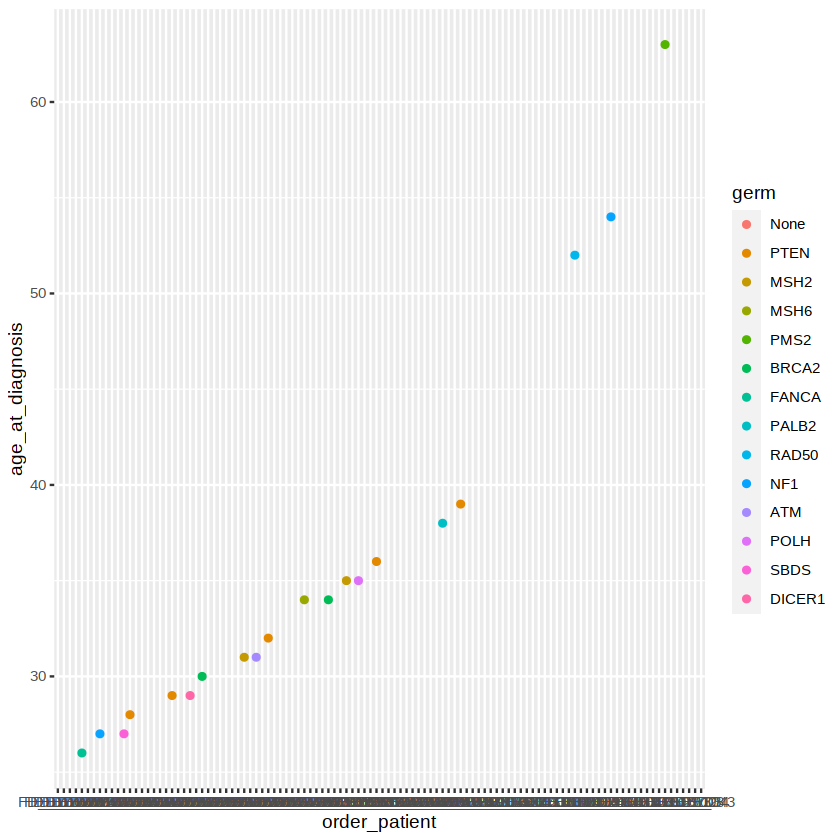

In [498]:
ggplot(common_clin_noAEH_noNAage_sort_IA,aes(x = order_patient,
                y=age_at_diagnosis,color = germ))+
geom_point(aes(y= age_at_diagnosis_na))

In [1]:
load("../Fig.9.2022_0618_1809.rdata")

In [2]:
head(common_clin_noAEH_noNAage_sort_IA)

ERROR: Error in head(common_clin_noAEH_noNAage_sort_IA): object 'common_clin_noAEH_noNAage_sort_IA' not found


In [3]:
ls()

[1] "a"                                   
  [2] "age_freq"                            
  [3] "age_order"                           
  [4] "alter_fun"                           
  [5] "cgc"                                 
  [6] "cgc_log"                             
  [7] "cgc_log_plot"                        
  [8] "chi_input"                           
  [9] "col"                                 
 [10] "common_age_laml"                     
 [11] "common_Clin"                         
 [12] "common_clin_noAEH_noNAage"           
 [13] "common_clin_noAEH_noNAage_sort"      
 [14] "common_clin_noAEH_noNAage_sort_early"
 [15] "common_clin_noAEH_noNAage_sort_old"  
 [16] "common_cosmic_count"                 
 [17] "common_cosmic_count_clin"            
 [18] "common_early_laml"                   
 [19] "common_early_maf"                    
 [20] "common_fga"                          
 [21] "common_final_purity"                 
 [22] "common_freq_input"                   
 [23] "common_gene_age"                     
 [24] "common_maf"                          
 [25] "common_nonsyn_maf"                   
 [26] "common_nonsyn_matrix"                
 [27] "common_nonsyn_matrix_age"            
 [28] "common_old_laml"                     
 [29] "common_old_maf"                      
 [30] "common_oncopritn_input"              
 [31] "common_sample"                       
 [32] "common_sig_count"                    
 [33] "common_sig_count_clin"               
 [34] "common_tumor_t_cell"                 
 [35] "COSMIC_29_order"                     
 [36] "cosmic_legacy_absolute_fit"          
 [37] "cosmic_legacy_absolute_fit_input"    
 [38] "cosmic_legacy_absolute_fit_t"        
 [39] "cosmic_legacy_relative_fit"          
 [40] "cosmic_legacy_relative_fit_input"    
 [41] "data_long_m"                         
 [42] "data_long_relative_m"                
 [43] "df"                                  
 [44] "df_input"                            
 [45] "df_long"                             
 [46] "Figure1E"                            
 [47] "Figure1F"                            
 [48] "Figure1G"                            
 [49] "Figure1H"                            
 [50] "Figure3"                             
 [51] "Figure3A"                            
 [52] "Firgure.3A1"                         
 [53] "Firgure.3A2"                         
 [54] "focal_clin"                          
 [55] "freq_input_long"                     
 [56] "freq_input_long_noNA"                
 [57] "freq_input_wide"                     
 [58] "gene_mut_data"                       
 [59] "gene_name"                           
 [60] "i"                                   
 [61] "j"                                   
 [62] "lgd"                                 
 [63] "logistic_df"                         
 [64] "m1"                                  
 [65] "mats"                                
 [66] "mt_sig"                              
 [67] "mt_tally"                            
 [68] "my_fit"                              
 [69] "my_gene_plot"                        
 [70] "mycol"                               
 [71] "mygene_new"                          
 [72] "mytheme"                             
 [73] "noNA_merge_xlsx_BY_Clin"             
 [74] "p_signif"                            
 [75] "p_withfreq"                          
 [76] "p1"                                  
 [77] "p1_age_newcol"                       
 [78] "p1_age_withtest"                     
 [79] "p1_BY_newcol"                        
 [80] "p1_BY_withtest"                      
 [81] "p2"                                  
 [82] "p2star"                              
 [83] "pct_input"                           
 [84] "predict_freq"                        
 [85] "sample_maf"                          
 [86] "sample_name"                         
 [87] "SBS_age_compare_plot"                
 [88] "SBS_age_compare_plot_long"           
 [89] "SBS_BY_compare_plot"               

Warning message:
“Removed 88 rows containing missing values (geom_point).”
Warning message:
“Removed 2 rows containing missing values (geom_segment).”


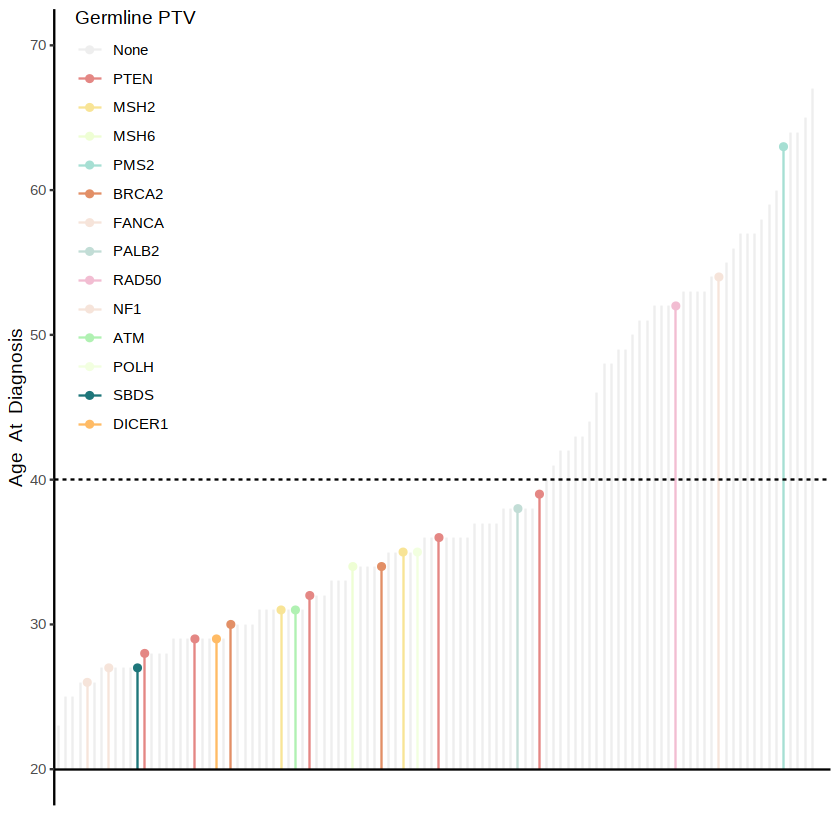

In [504]:
ggplot(common_clin_noAEH_noNAage_sort_IA,aes(x = order_patient,
                y=age_at_diagnosis,color = germ))+
  geom_point(aes(y= age_at_diagnosis_na))+
  geom_segment(aes(x=reorder(patient,age_at_diagnosis),xend=reorder(patient,age_at_diagnosis),
                   y=20,yend=age_at_diagnosis))+
  scale_color_manual(values = c('#eeeeee','#e48784',"#f8e496",'#eefed4',
                                '#a6dfd3','#e28f66','#f6e4da',"#c2ddd6",
                                '#f2bdd2','#f6e4da',"#b0f1b2","#f2ffe0",
                                "#1e767a","#ffbb65"))+
  theme_bw()+
  labs(x="",
      y = "Age  At  Diagnosis",
      color = "Germline PTV")+
  geom_hline(yintercept = 40,linetype="dashed")+
  scale_y_continuous(limits = c(20, 70))+
theme(legend.position = c(0.10,0.73),
  panel.grid =element_blank()) +   ## 删去网格线
  theme(axis.text.x = element_blank()) +   ## 删去刻度标签
  theme(axis.ticks.x = element_blank()) +   ## 删去刻度线
  theme(panel.border = element_blank()) +   ## 删去外层边框
  theme(axis.line.y = element_line(size=0.5, colour = "black"))+## 再加上坐标轴（无刻度、无标签）
  geom_hline(yintercept = 20)

In [505]:
IA_germ = ggplot(common_clin_noAEH_noNAage_sort_IA,aes(x = order_patient,
                y=age_at_diagnosis,color = germ))+
  geom_point(aes(y= age_at_diagnosis_na))+
  geom_segment(aes(x=reorder(patient,age_at_diagnosis),xend=reorder(patient,age_at_diagnosis),
                   y=20,yend=age_at_diagnosis))+
  scale_color_manual(values = c('#eeeeee','#e48784',"#f8e496",'#eefed4',
                                '#a6dfd3','#e28f66','#f6e4da',"#c2ddd6",
                                '#f2bdd2','#f6e4da',"#b0f1b2","#f2ffe0",
                                "#1e767a","#ffbb65"))+
  theme_bw()+
  labs(x="",
      y = "Age  At  Diagnosis",
      color = "Germline PTV")+
  geom_hline(yintercept = 40,linetype="dashed")+
  scale_y_continuous(limits = c(20, 70))+
theme(legend.position = c(0.10,0.73),
  panel.grid =element_blank()) +   ## 删去网格线
  theme(axis.text.x = element_blank()) +   ## 删去刻度标签
  theme(axis.ticks.x = element_blank()) +   ## 删去刻度线
  theme(panel.border = element_blank()) +   ## 删去外层边框
  theme(axis.line.y = element_line(size=0.5, colour = "black"))+## 再加上坐标轴（无刻度、无标签）
  geom_hline(yintercept = 20)

In [516]:
ggsave(IA_germ,file ="Figure5_IA_germline_loliipop.pdf",width = 10)

Saving 10 x 6.67 in image

Warning message:
“Removed 88 rows containing missing values (geom_point).”
Warning message:
“Removed 2 rows containing missing values (geom_segment).”


## 7.save data

In [308]:
save.image(file="Fig.9.2022_0618_1611.rdata")

In [362]:
save.image(file="Fig.9.2022_0618_1809.rdata")

In [3]:
load("../Fig.9.2022_0618_1809.rdata")